# Book Club Assignment 1 - Bank Marketing Data

## Attribute Information:

### Input variables:

#### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')



In [1]:
import numpy as np
import scipy
from scipy.stats import uniform,truncnorm,randint,loguniform

import pandas as pd

import os
import pickle
import time
from joblib import dump, load

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,\
                                    StratifiedKFold,TimeSeriesSplit, \
                                    cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,plot_confusion_matrix, average_precision_score, \
                            plot_precision_recall_curve,roc_auc_score,roc_curve, auc,log_loss,\
                            confusion_matrix,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier

import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style('white')

In [2]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

In [3]:
from skopt.space import Real,Integer,Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [4]:
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.activations import selu
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU, PReLU, ELU, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.optimizers import SGD,Adam,Nadam
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 1. Import Dataset

In [5]:
pwd

'/Users/kunhu/Dropbox/Current/UCI Data'

In [6]:
df = pd.read_csv('./bank-additional/bank-additional-full.csv',sep = ';')\
        .assign(y = lambda df: 1*(df['y']=='yes'))
df.head().T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed            5191         5191         5191         5191   
y                         0            0            0            0   

                          4  
age                      56  
job                services  
marital             married  
education       high.school  
default                  no  
housing                  no  
loan                    yes  
contact           telephone  
month                   may  
day_of_week             mon  
duration                307  
campaign                  1  
pdays                   999  
previous                  0  
poutcome        nonexistent  
emp.var.rate            1.1  
cons.price.idx       93.994  
cons.conf.idx         -36.4  
euribor3m             4.857  
nr.employed            5191  
y                         0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
print('Numerical Data')
df.describe(include = 'number')

Numerical Data


age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  41188.000000    41188.000000   41188.000000  41188.000000   
mean       0.081886       93.575664     -40.502600      3.621291   
std        1.570960        0.578840       4.628198      1.734447   
min       -3.400000       92.201000     -50.800000      0.634000   
25%       -1.800000       93.075000     -42.700000      1.344000   
50%        1.100000       93.749000     -41.800000      4.857000   
75%        1.400000       93.994000     -36.400000      4.961000   
max        1.400000       94.767000     -26.900000      5.045000   

        nr.employed             y  
count  41188.000000  41188.000000  
mean    5167.035911      0.112654  
std       72.251528      0.316173  
min     4963.600000      0.000000  
25%     5099.100000      0.000000  
50%     5191.000000      0.000000  
75%     5228.100000      0.000000  
max     5228.100000      1.000000

In [10]:
print('Categorical Data')
df.describe(exclude = 'number')

Categorical Data


job  marital          education default housing   loan   contact  \
count    41188    41188              41188   41188   41188  41188     41188   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10422    24928              12168   32588   21576  33950     26144   

        month day_of_week     poutcome  
count   41188       41188        41188  
unique     10           5            3  
top       may         thu  nonexistent  
freq    13769        8623        35563

# 2. EDA

In [11]:
client_list_num = ['age']
client_list_cat = 'job marital education default housing loan'.split()
other_list_cat = 'contact month day_of_week poutcome'.split()
other_list_num = 'campaign pdays previous emp.var.rate cons.price.idx euribor3m nr.employed'.split()

## 2.1 Categorical Variables

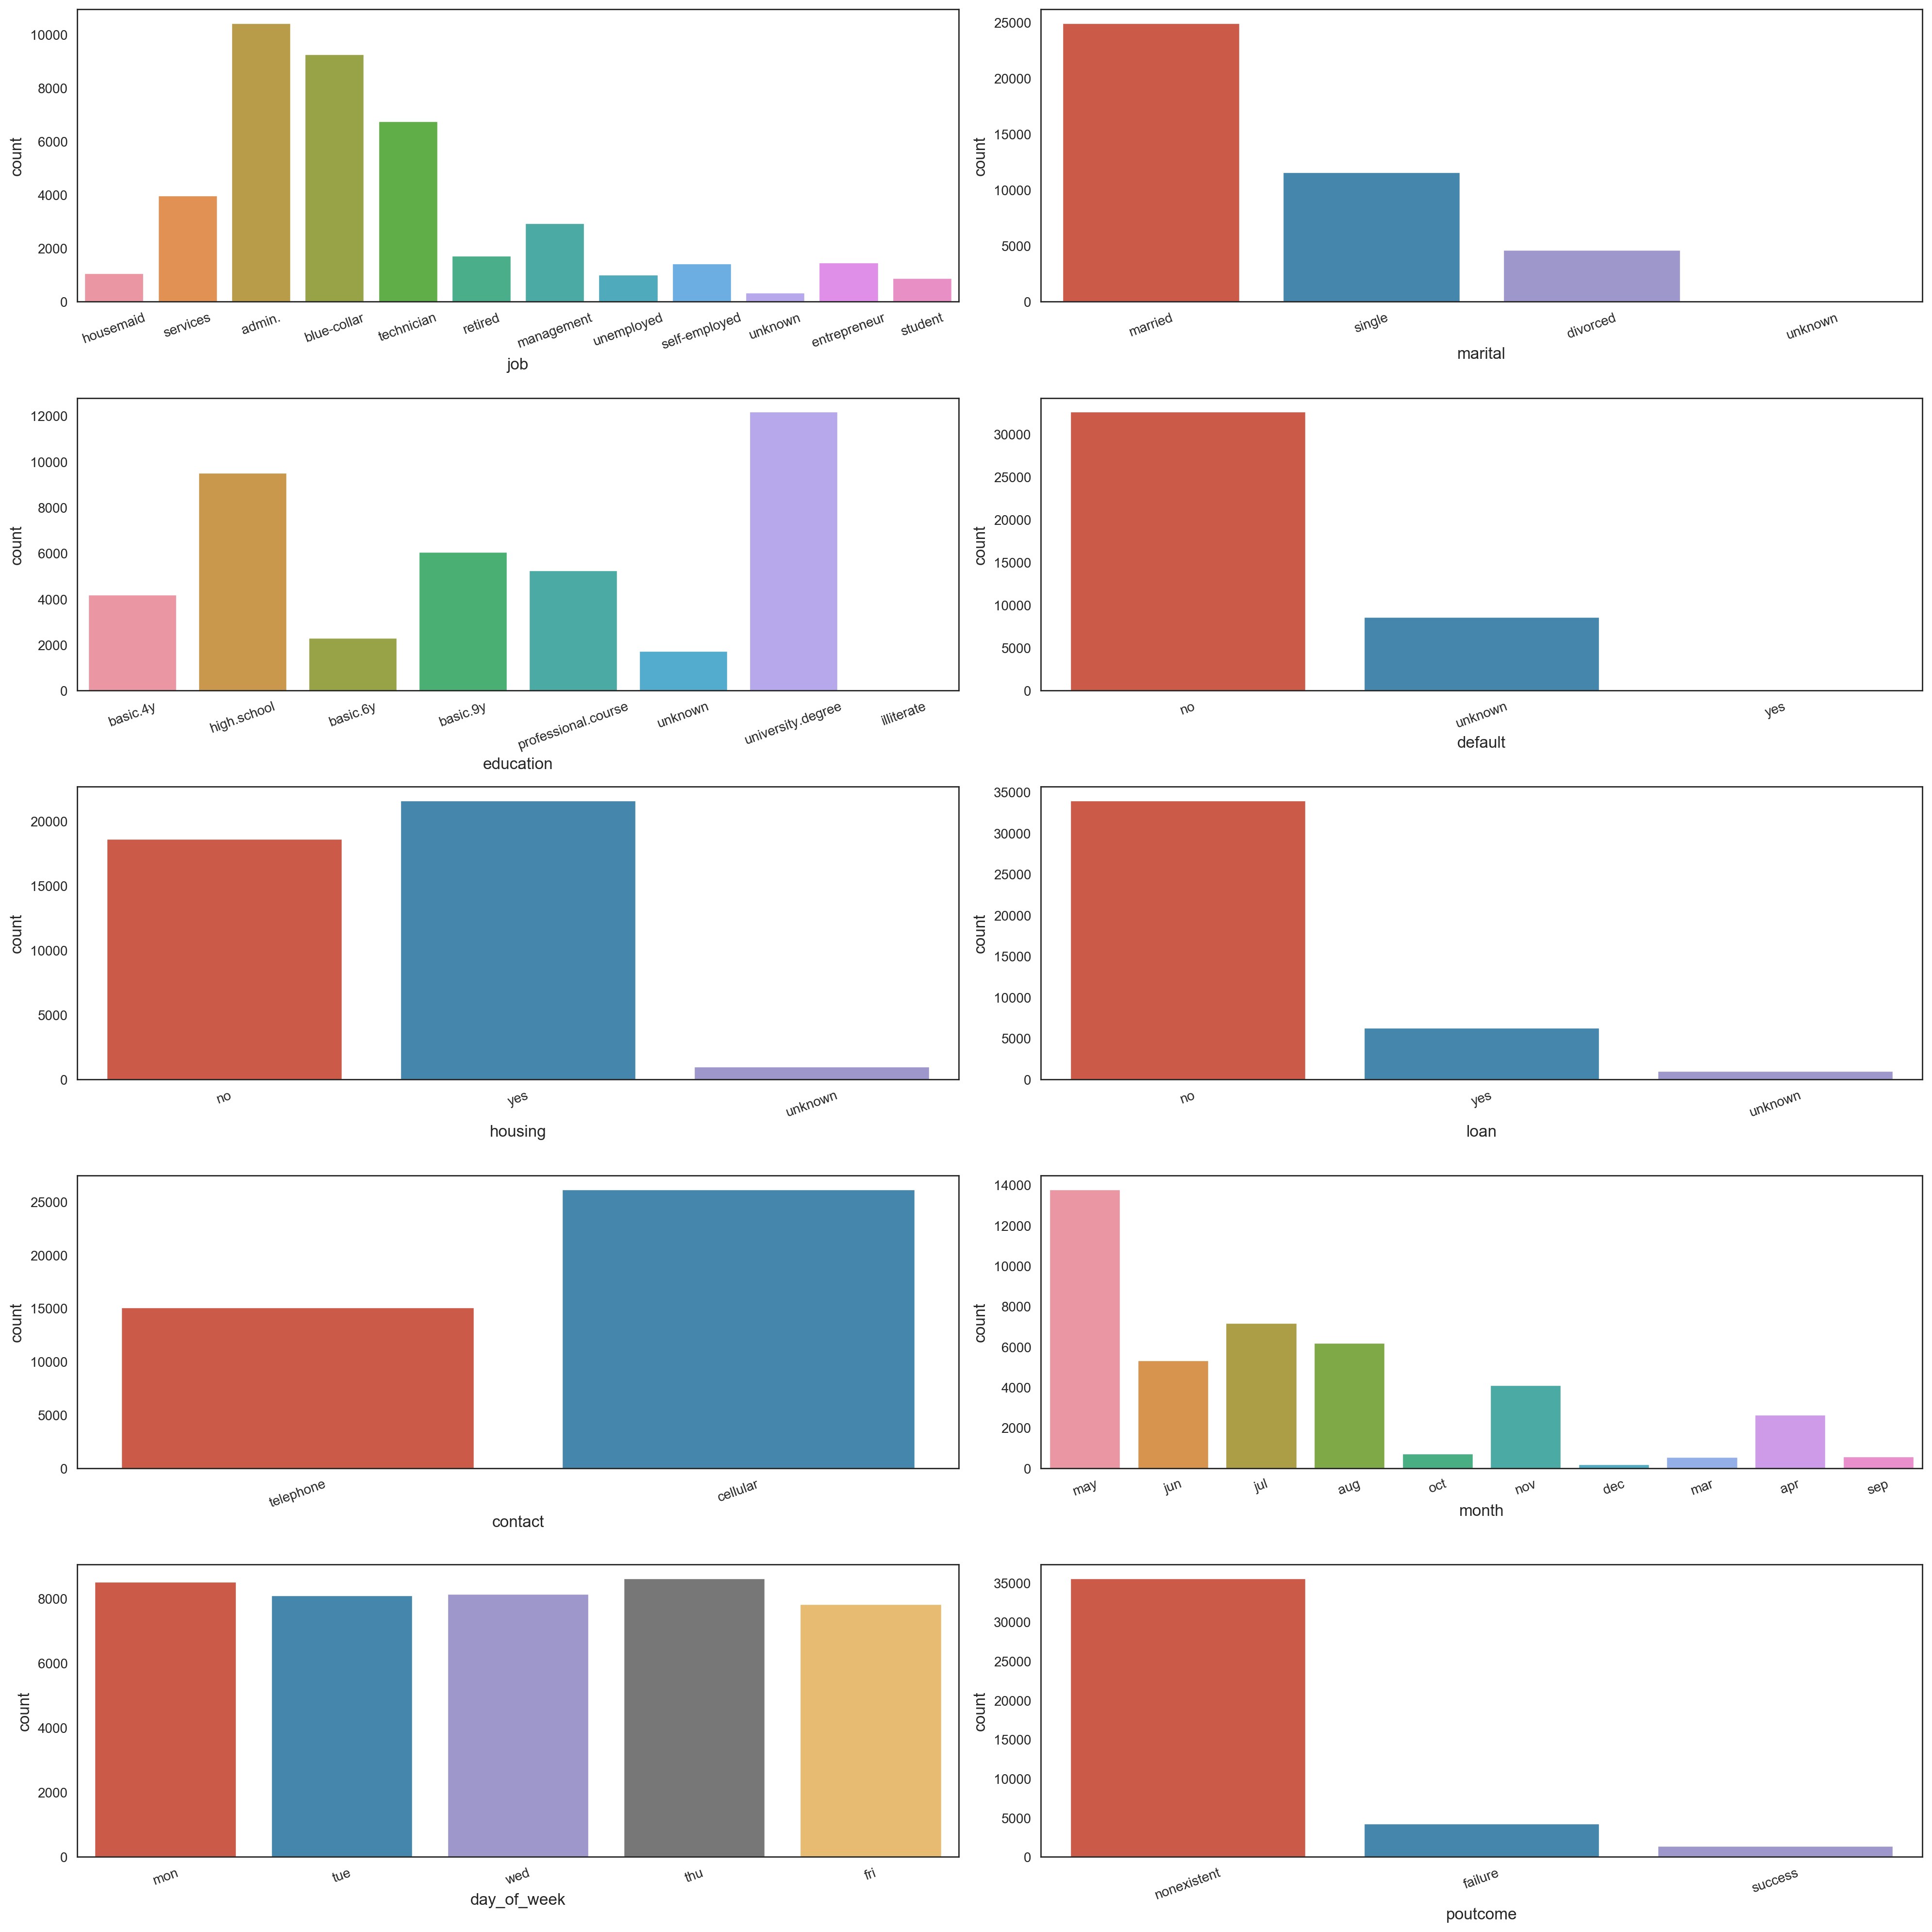

In [12]:
fig,ax = plt.subplots(5,2,figsize=(20,20),dpi=200)
ax = ax.flatten()
for i,arg in enumerate(client_list_cat + other_list_cat):
    sns.countplot(x=arg,data = df,ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
plt.tight_layout()

Not too much info from the above, other than that some categories are not balanced
- Now the share of YES by categories

In [13]:
df_cat = df[client_list_cat + other_list_cat + ['y']].melt(id_vars=['y'],value_vars = client_list_cat + other_list_cat)
df_cat = df_cat.drop(columns = 'y').drop_duplicates(['variable','value']).merge(\
    pd.DataFrame(df_cat.groupby(['variable','value']).agg({'y':'mean'}).reset_index()),
    on = ['variable','value'],suffixes = [False,False],validate = "1:1")


In [14]:
df_cat.set_index( ['variable','value'])

y
variable    value                        
job         housemaid            0.100000
            services             0.081381
            admin.               0.129726
            blue-collar          0.068943
            technician           0.108260
            retired              0.252326
            management           0.112175
            unemployed           0.142012
            self-employed        0.104856
            unknown              0.112121
            entrepreneur         0.085165
            student              0.314286
marital     married              0.101573
            single               0.140041
            divorced             0.103209
            unknown              0.150000
education   basic.4y             0.102490
            high.school          0.108355
            basic.6y             0.082024
            basic.9y             0.078246
            professional.course  0.113485
            unknown              0.145003
            university.degree    0.137245
            illiterate           0.222222
default     no                   0.128790
            unknown              0.051530
            yes                  0.000000
housing     no                   0.108796
            yes                  0.116194
            unknown              0.108081
loan        no                   0.113402
            yes                  0.109315
            unknown              0.108081
contact     telephone            0.052313
            cellular             0.147376
month       may                  0.064347
            jun                  0.105115
            jul                  0.090466
            aug                  0.106021
            oct                  0.438719
            nov                  0.101439
            dec                  0.489011
            mar                  0.505495
            apr                  0.204787
            sep                  0.449123
day_of_week mon                  0.099483
            tue                  0.117800
            wed                  0.116671
            thu                  0.121188
            fri                  0.108087
poutcome    nonexistent          0.088322
            failure              0.142286
            success              0.651129

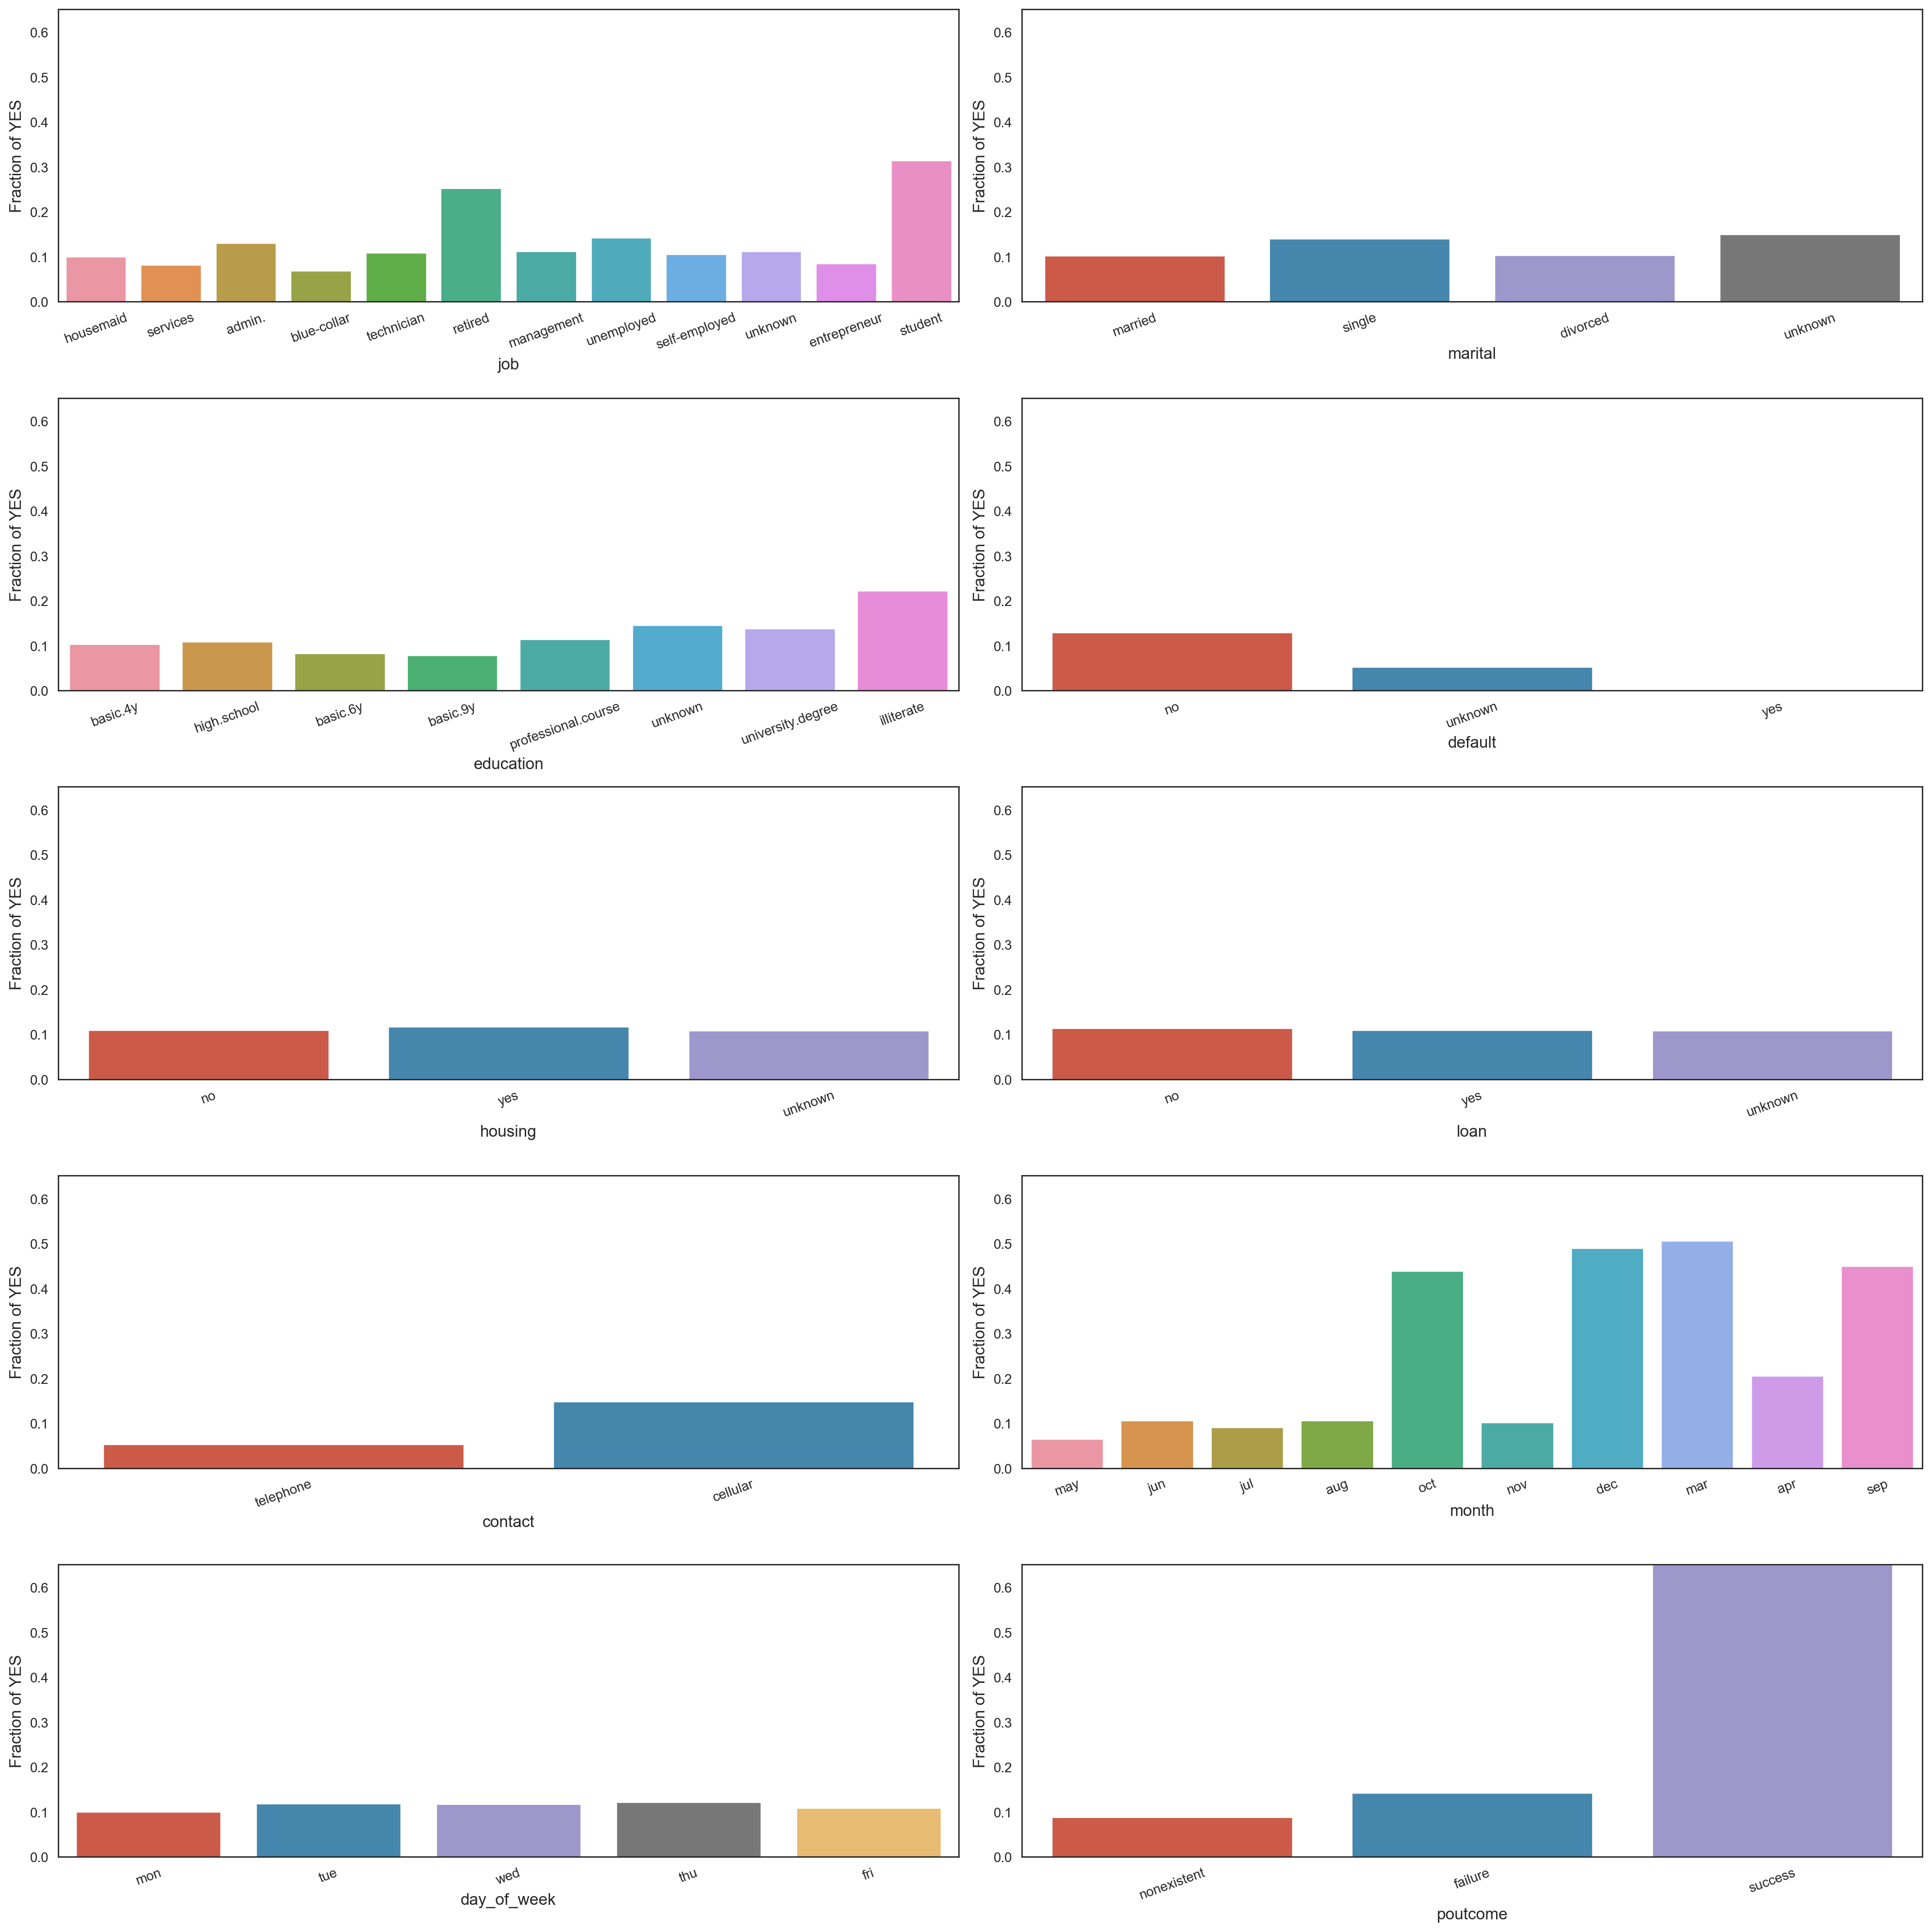

In [15]:
fig,ax = plt.subplots(5,2,figsize=(20,20),dpi=200)
ax = ax.flatten()
for i,arg in enumerate(client_list_cat + other_list_cat):
    sns.barplot(y='y',x = 'value',data =df_cat.query(f'variable =="{arg}"'),ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_ylabel('Fraction of YES')
    ax[i].set_ylim((0,df_cat.y.max()))
    ax[i].set_xlabel(arg)
plt.tight_layout()

### Conclusion for Categorical Variables
- For univariate predictions:
    - Job, education, contact, default, month and previous outcome are important features
    - Marital, housing, loan, day_of_week are less important PER SE
- However, a feature that is unimportant alone may be important once we consider its interactions with other features

## 2.2 Numeric Variables

In [16]:
df_num = df[client_list_num + other_list_num + ['y']].replace(999,np.nan)
df_num.describe()

age      campaign        pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  1515.000000  41188.000000  41188.000000   
mean      40.02406      2.567593     6.014521      0.172963      0.081886   
std       10.42125      2.770014     3.824906      0.494901      1.570960   
min       17.00000      1.000000     0.000000      0.000000     -3.400000   
25%       32.00000      1.000000     3.000000      0.000000     -1.800000   
50%       38.00000      2.000000     6.000000      0.000000      1.100000   
75%       47.00000      3.000000     7.000000      0.000000      1.400000   
max       98.00000     56.000000    27.000000      7.000000      1.400000   

       cons.price.idx     euribor3m   nr.employed             y  
count    41188.000000  41188.000000  41188.000000  41188.000000  
mean        93.575664      3.621291   5167.035911      0.112654  
std          0.578840      1.734447     72.251528      0.316173  
min         92.201000      0.634000   4963.600000      0.000000  
25%         93.075000      1.344000   5099.100000      0.000000  
50%         93.749000      4.857000   5191.000000      0.000000  
75%         93.994000      4.961000   5228.100000      0.000000  
max         94.767000      5.045000   5228.100000      1.000000

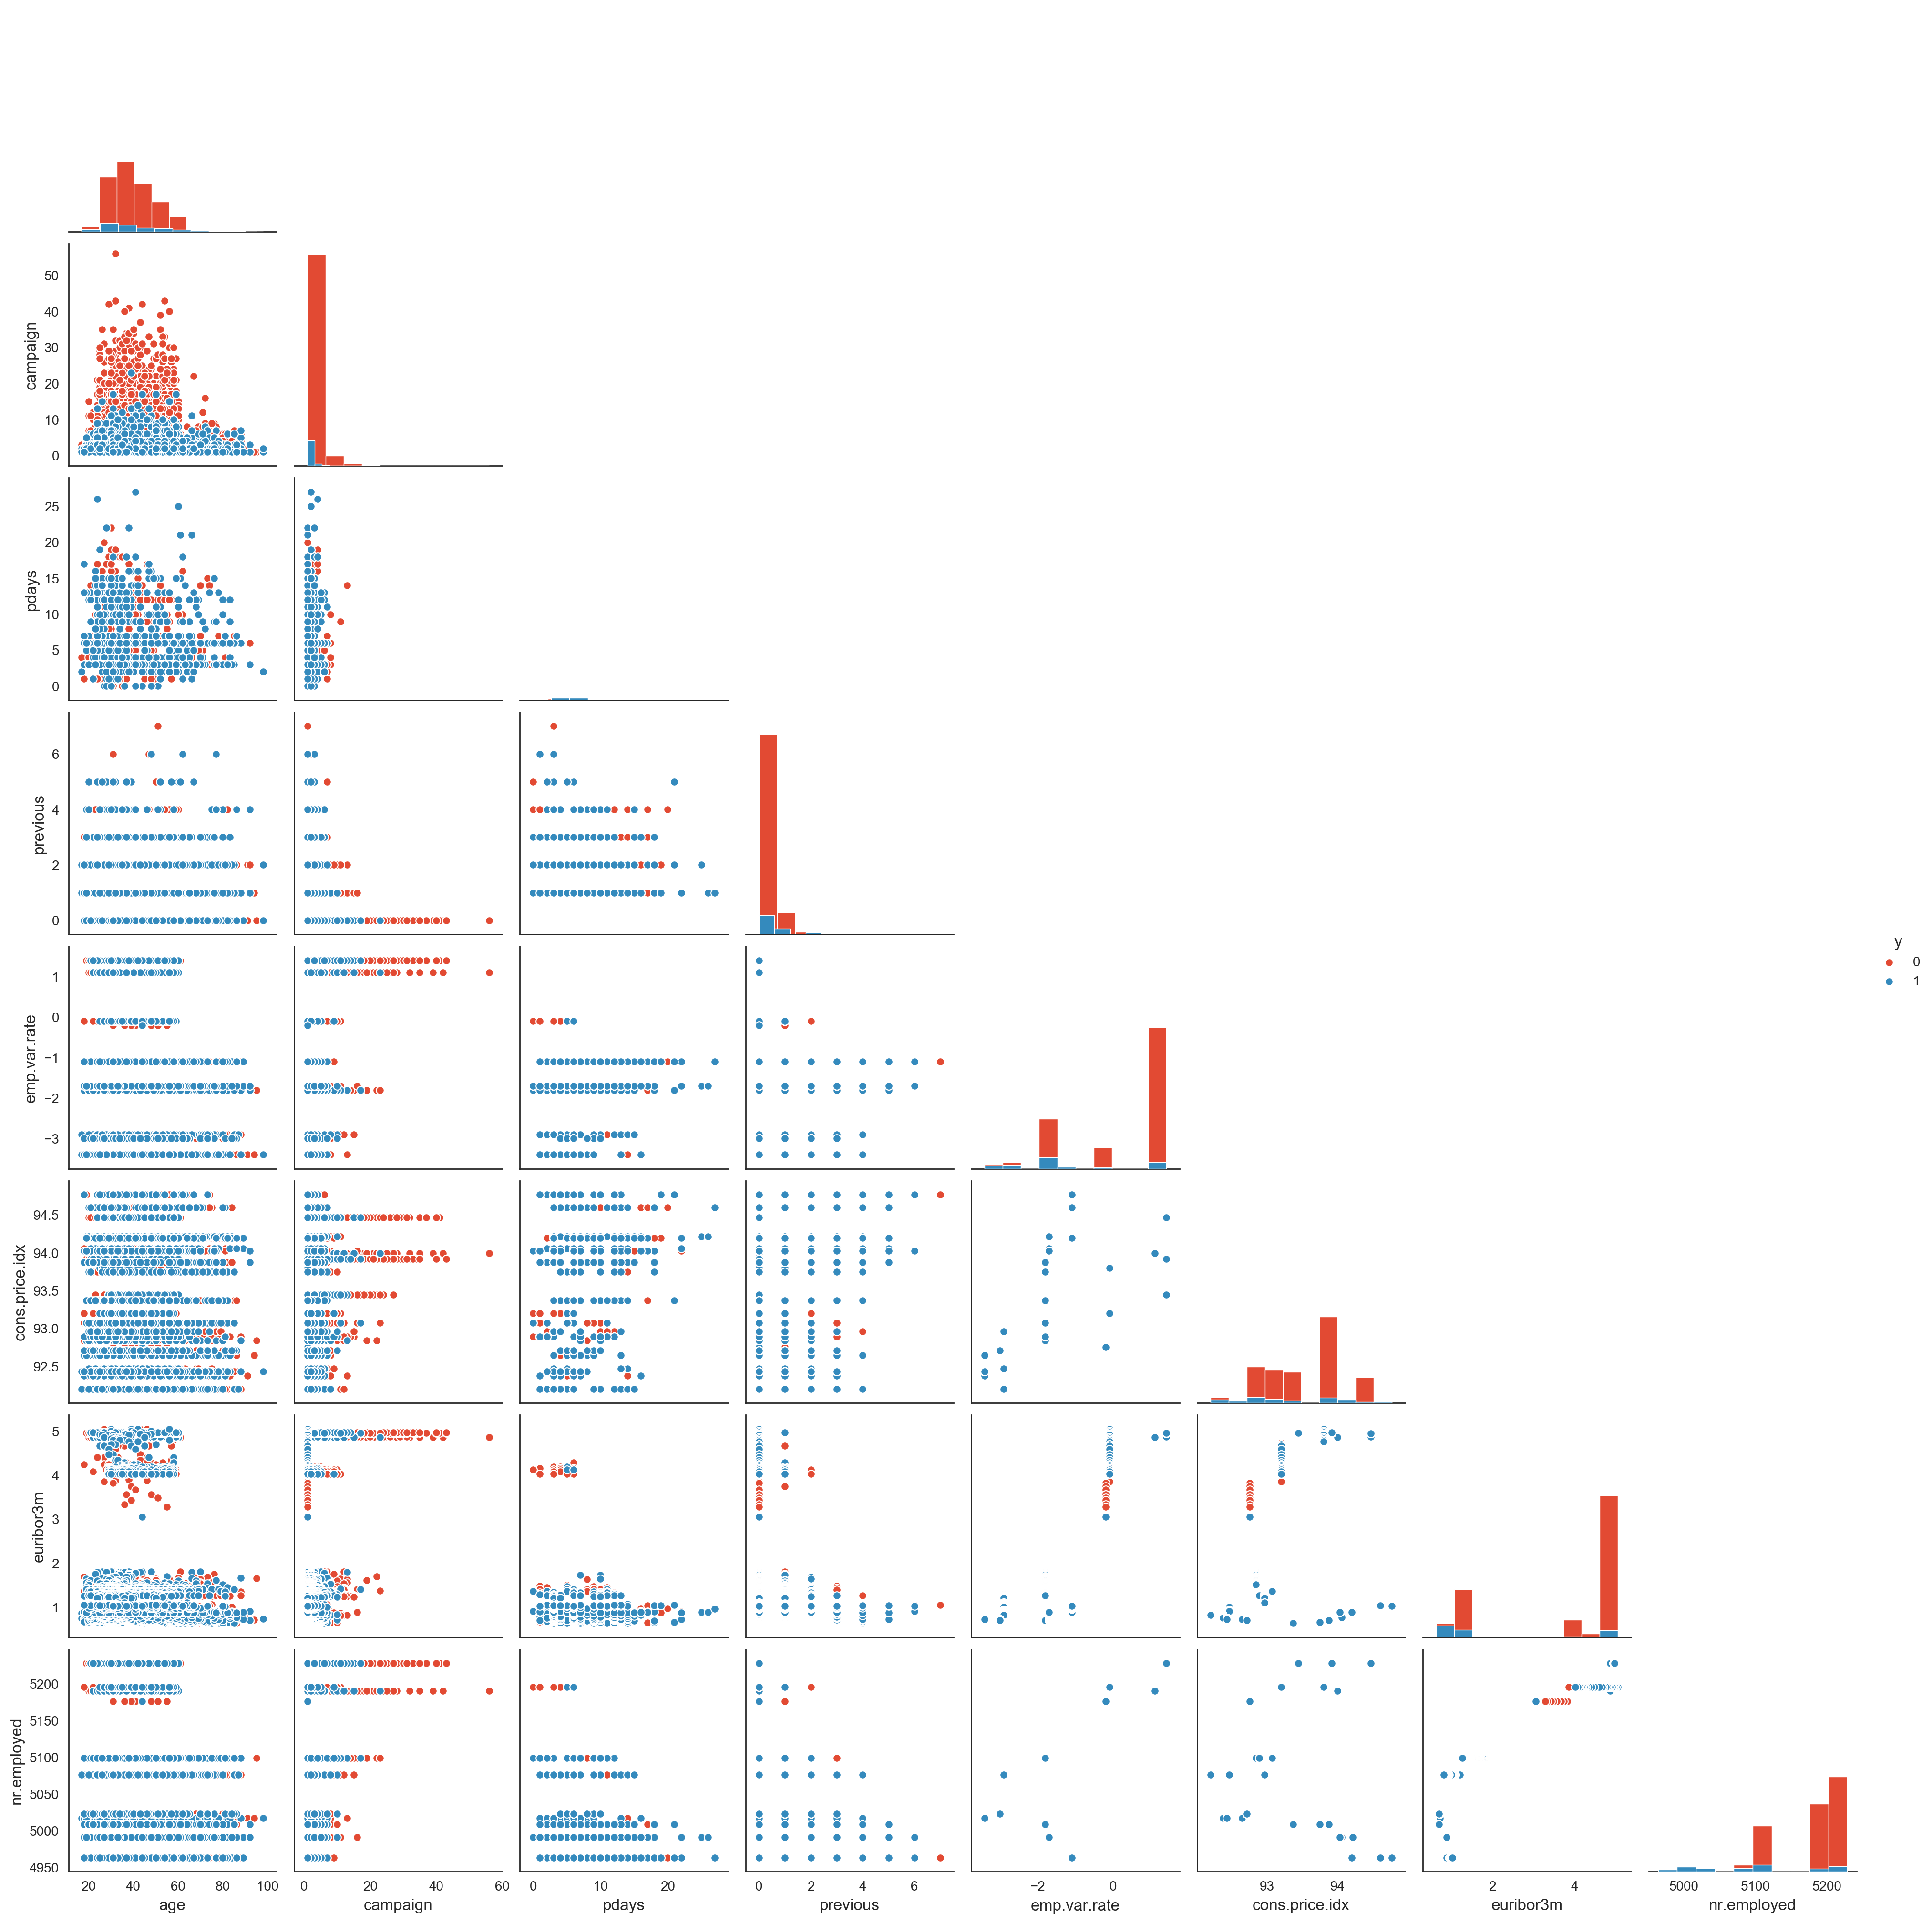

In [17]:
g = sns.pairplot(data = df_num,hue='y',corner=True,diag_kind='hist')
g.fig.set_size_inches(20,20)
g.fig.set_dpi(200)

Not much information. We can check correlation with a heatplot.


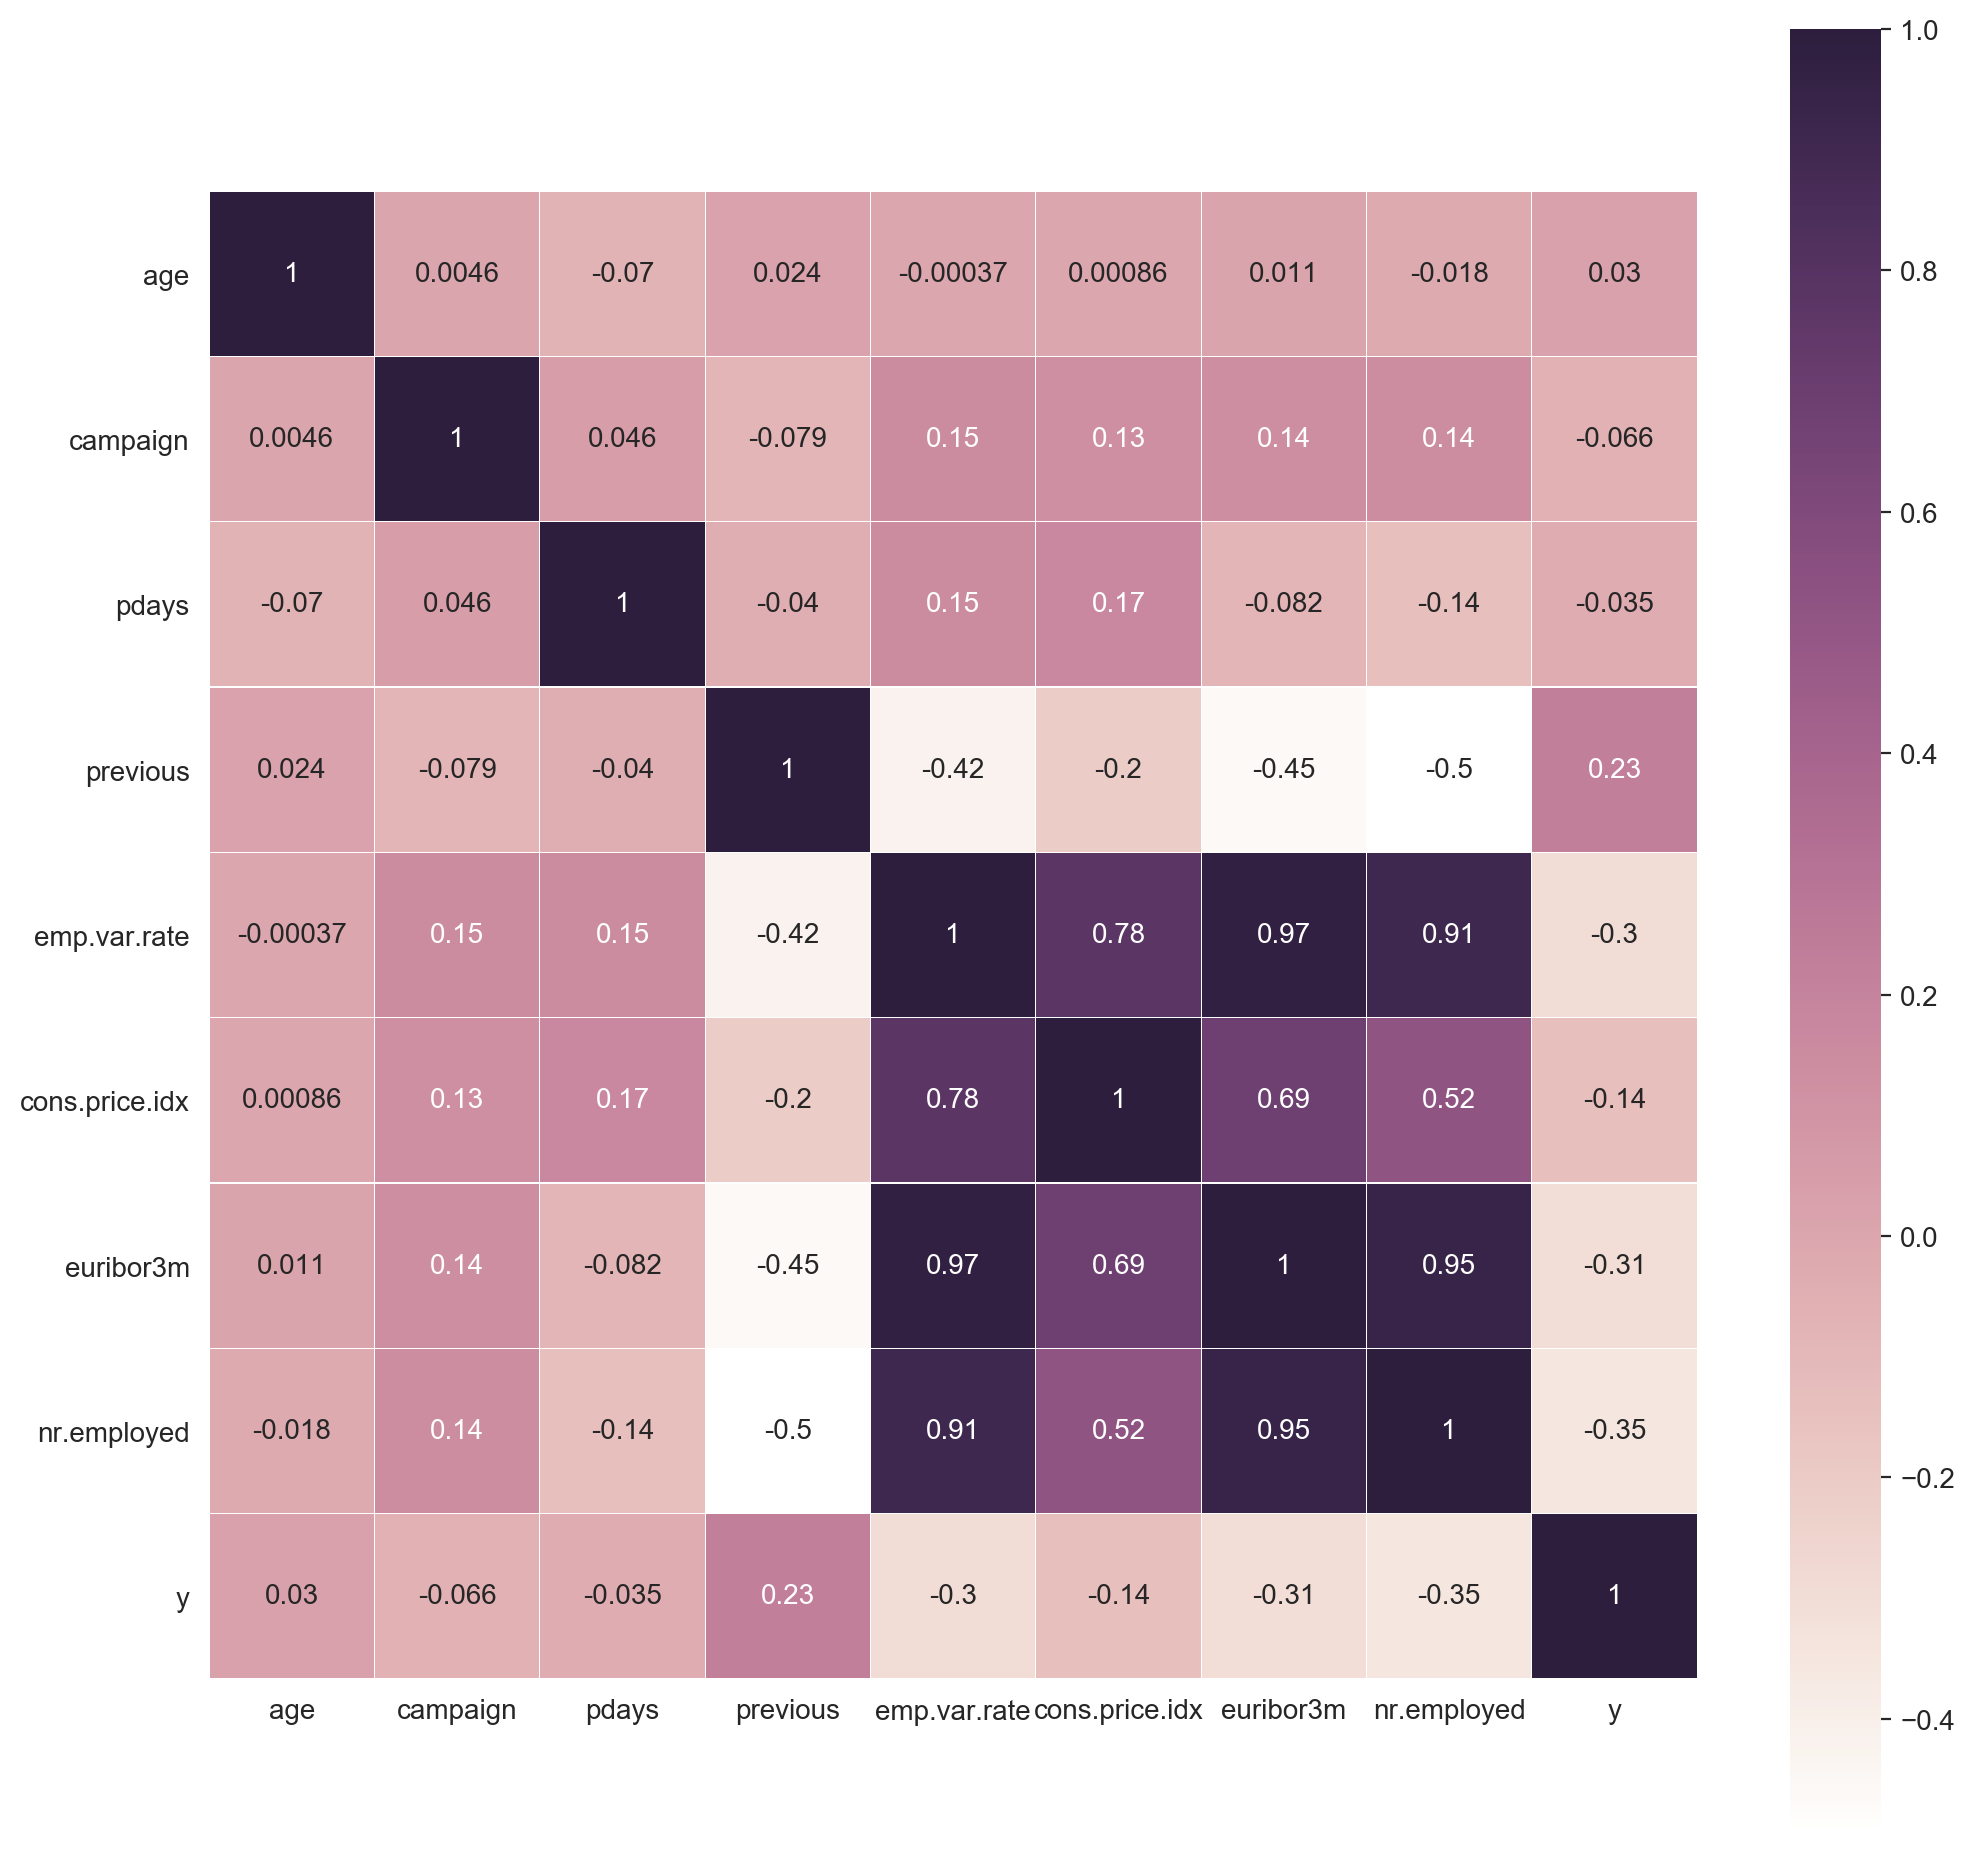

In [18]:
fig,ax = plt.subplots(figsize = (12,12),dpi = 200)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_num.corr(),cmap = cmap, ax=ax, annot=True, linewidth=0.1,square = True)

In [19]:
df_num['y'] = df_num['y'].replace(1,'yes').replace(0,'no')

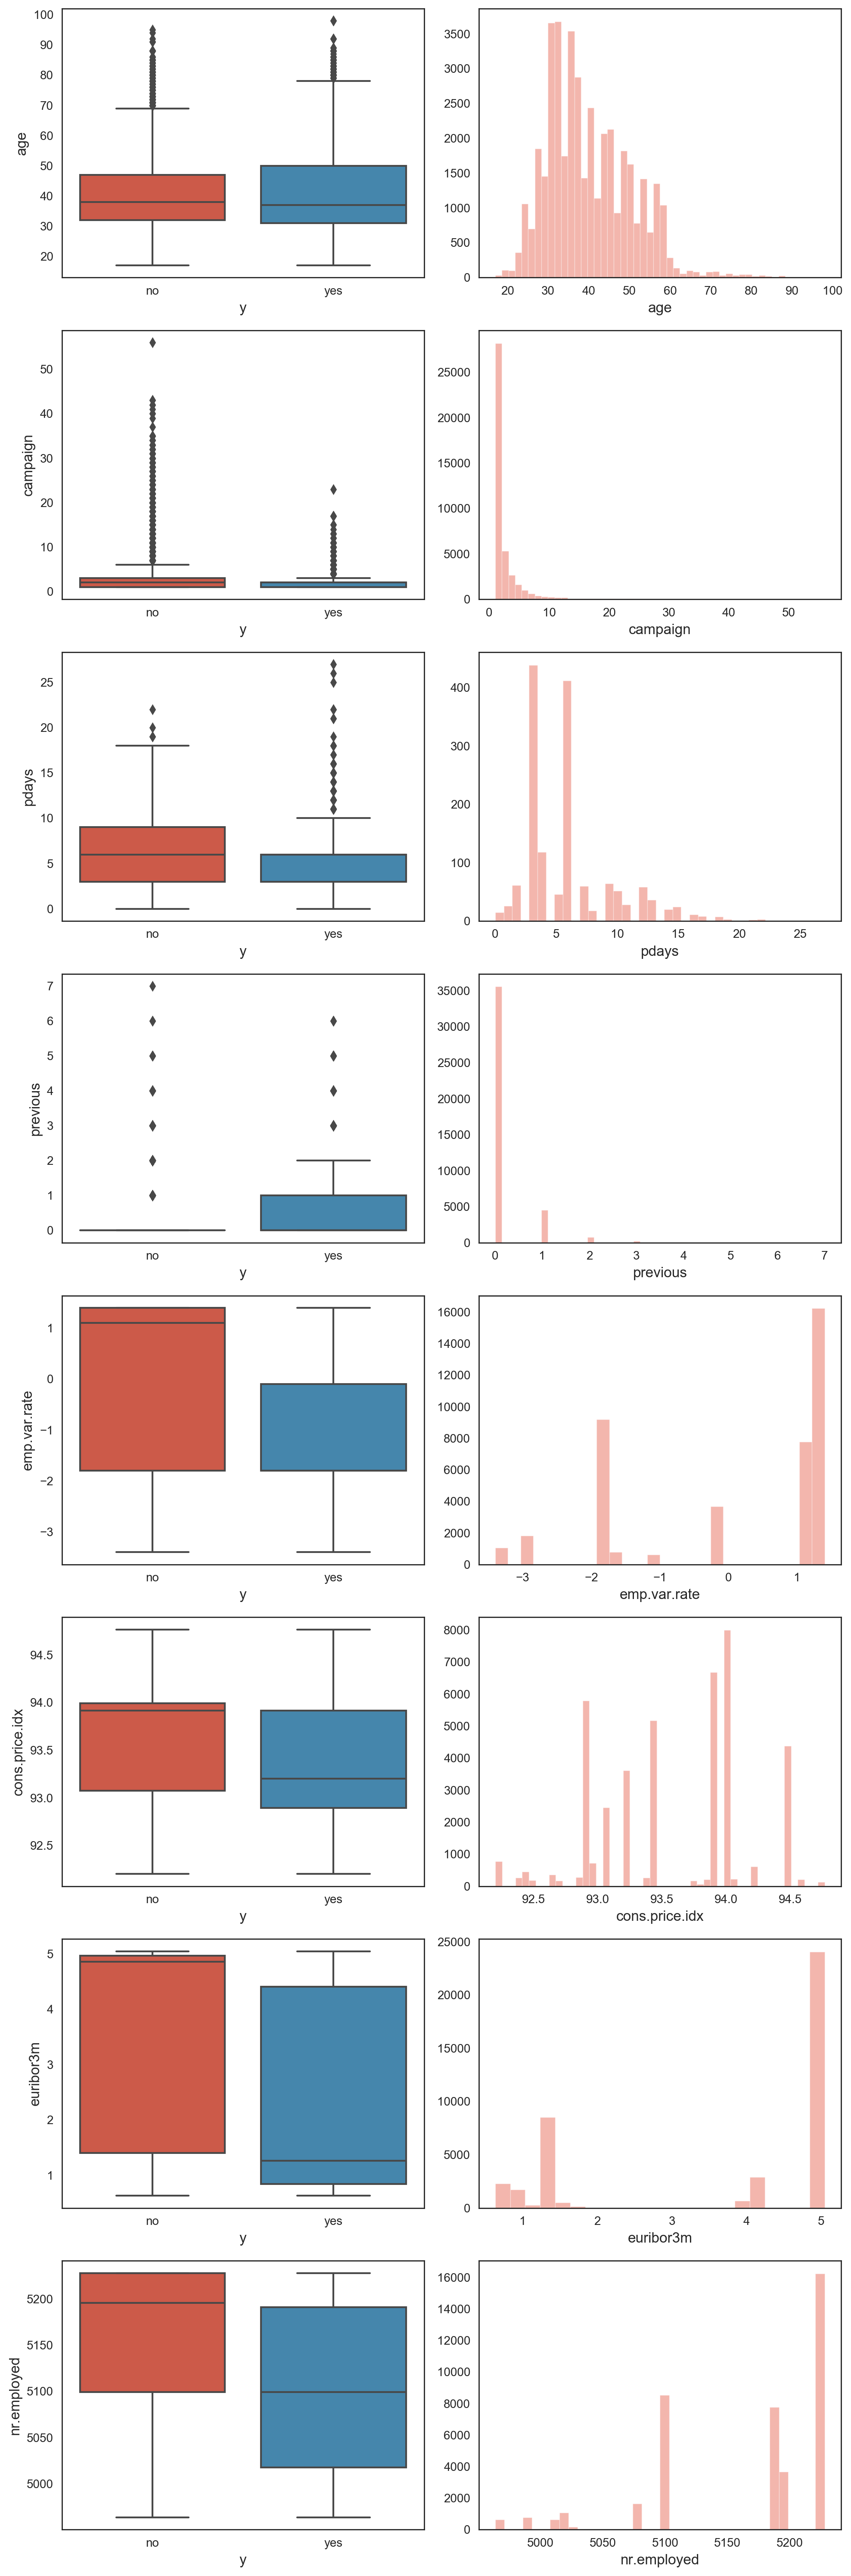

In [20]:
fig,ax = plt.subplots(8,2,figsize=(10,30),dpi=200)
for i,arg in enumerate(client_list_num + other_list_num):
    sns.boxplot(x='y',y=arg,data = df_num[['y', arg]],ax = ax[i,0])
    sns.distplot(df_num[arg],ax = ax[i,1],kde = False)
plt.tight_layout()


- Numerical Variable
    - previous is positively correlated with YES
    - Negatively correlated with economics variables: less likely to have YES when the economy is booming and/or interest rates are high
    
- These can be confirmed by the boxplots

Also, I have replaced pdays = 999 to NA. Now I will check the difference in terms of YES when pday = NA vs. not

In [21]:
df_num['pdays_valid'] = 1*df_num['pdays'].notna()

In [22]:
df_num['pdays_valid'].value_counts()

0    39673
1     1515
Name: pdays_valid, dtype: int64

In [23]:
df_num[['y','pdays_valid']].replace('yes',1).replace('no',0).groupby('pdays_valid').mean().reset_index()

pdays_valid         y
0            0  0.092582
1            1  0.638284

Distribution of Y for pdays
pdays: number of days that passed by after the client was last contacted from a previous campaign
pdays_valid = 0 means client was not previously contacted; 1 otherwise


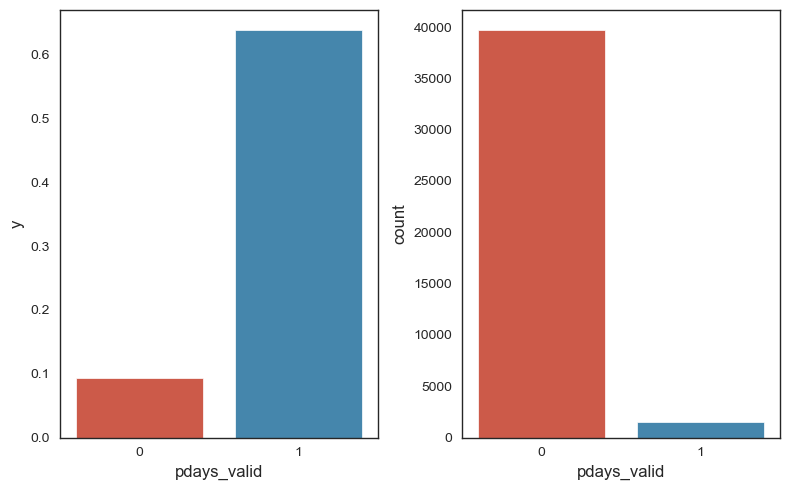

In [24]:
fig,ax = plt.subplots(1,2,figsize=(8,5),dpi=100)
sns.barplot(y='y',x = 'pdays_valid',
            data =df_num[['y','pdays_valid']].replace('yes',1).replace('no',0).groupby('pdays_valid').mean().reset_index(),
            ax = ax[0])
sns.countplot(df_num['pdays_valid'],ax = ax[1])
# fig.suptitle('Distribution of Y for pdays')
# ax[i].tick_params(axis='x', rotation=20)
# ax[i].set_ylabel('Fraction of YES')
# ax[i].set_ylim((0,df_cat.y.max()))
# ax[i].set_xlabel(arg)
plt.tight_layout()
print('''Distribution of Y for pdays
pdays: number of days that passed by after the client was last contacted from a previous campaign
pdays_valid = 0 means client was not previously contacted; 1 otherwise''')

In conclusion, pdays is weakly negatively correlated with response. However, if clients have never been contacted, is it less likely for them to say yes. For logistic regressions, a better feature will by pdays_valid.

## 2.3 Distribution of Y

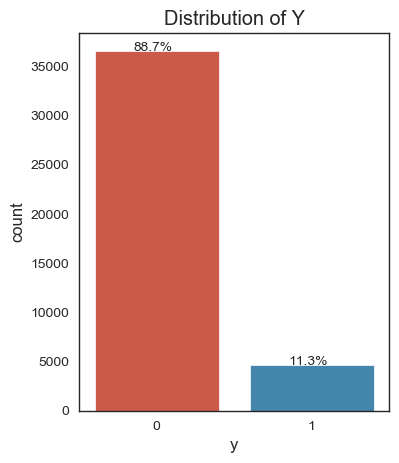

In [25]:
fig,ax = plt.subplots(figsize=(4,5),dpi=100)
sns.countplot(df['y'],ax = ax)
ax.set_title('Distribution of Y')
for p in ax.patches:
    ax.annotate(f"{100*p.get_height()/len(df['y']):.1f}%", (p.get_x()+0.25, p.get_height()+5))

# 3.Discussion of Success Criteria
In order of importance: **assuming the cost of missing out is the highest**
- Recall (True Positive Rate, Sensitivity) = True Positive/Positive
    - Probability of detection. How many relevant items are selected
    - This is very important
- Specifity = True Negative/Negative = 1 - False Positive Rate
    - how many negative selected items are truly negatuve
    - We want this number to be high as well
- Percision = True Positive/Predicted Positive: 
    - How many selected items are relevant. 
    - We want high number of this because marketing is costly, but it is less important

Two curves: Percison/Recall and ROC
- Use ROC, which plots true positive rate aginst false positive rate. We calculate area under curve AUC
    - To get the optimial point under ROC curve, we use the J-statistics (or the geometric mean) J = Sensitivity + Specificity – 1
- But keep in mind that the positive cases (Y=1) is only 11.3%, so even for a naive classifier that labels every item to be negative will have a high specifity: 88.7%.
- For percision-recall trade-off, to find the optimal threshold, we use F-Measure or the harmonic mean = (2 * Precision * Recall) / (Precision + Recall)


In [77]:
ann_clf.__class__.__name__

'KerasClassifier'

In [91]:
def binary_testing(classifier_list,X,y_true,classifier_name_list = None):
    
    '''
    This function outputs the confusion matrix, classification reports, 
    Precesion-Recall Curve and ROC Curve for a list of binary classifiers.
    
    Example: binary_testing([gb_clf,clf],X,y_test,['XGBoost','RandomForrest'])
    '''
    
    if not isinstance(classifier_list,list):
        classifier_list = [classifier_list]
        
    if classifier_name_list is None:
        classifier_name_list = [x.__class__.__name__ for x in classifier_list]
    
    num_clf = len(classifier_list)
    
    fig,ax = plt.subplots(1,3,figsize = (21,6),dpi = 150)
    
    if num_clf%3 == 0:
        rows = int(num_clf/3)
    else:
        rows = int(num_clf//3 + 1)
    
    fig2,ax_cm = plt.subplots(rows,min(3,num_clf),figsize = (6*num_clf,6*rows),dpi = 150)
    
    if num_clf == 1:
        ax_cm = [ax_cm]
    else:
        ax_cm = ax_cm.flatten()
     
    for i,(classifier,name) in enumerate(zip(classifier_list,classifier_name_list)):
        
#         if 'Keras' in name:
#             X = X.toarray()
#         elif 'Sequential' in name:
#             X = X.toarray()
   
        if name != "Sequential":
            
            y_pred = classifier.predict(X)
            y_score = classifier.predict_proba(X)[:,1]
        else:
            y_pred = classifier.predict_classes(X).ravel()
            y_score = classifier.predict_proba(X).ravel()
        

        
        print(f'\n Calssification Report of {name}')
        print(classification_report(y_true, y_pred, labels = [0,1], target_names=['No','Yes']))

        if (name != "Sequential") and (name != 'KerasClassifier'):
            disp = plot_confusion_matrix(classifier,X,y_true,
                                         labels = [0,1],
                                  display_labels = ['No','Yes'],
                                  cmap=plt.cm.Blues,
                                  normalize = 'true',
                                         ax=ax_cm[i])
            disp.ax_.set_title(f'Normalized confusion matrix of {name}')
            print(f'confusion_matrix of {name}')
            print(disp.confusion_matrix)
        else:
            mat = confusion_matrix(y,y_pred)
            nmat = mat/np.repeat(np.sum(mat,axis = 1),2).reshape((2,2))
            
            sns.heatmap(nmat, annot=True,cmap=plt.cm.Blues,ax=ax_cm[i],square = True)
            ax_cm[i].set_title(f'Normalized confusion matrix of {name}')
            print(f'confusion_matrix of {name}')
            print(nmat)

        if (name != "Sequential") and (name != 'KerasClassifier'):
            disp2 = plot_precision_recall_curve(classifier, X, y_true,ax = ax[0])
            disp2.ax_.set_title('Precision-Recall curve')


        fpr, tpr, thresholds  = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax[1].plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.4f})')
        ax[1].plot([0, 1], [0, 1], 'k--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate (Recall)')
        ax[1].set_title('Receiver operating characteristic Curve')
        ax[1].legend(loc="lower right")

        ax[2].plot([0, 1], [0, 1], 'k--')
        ax[2].set_xlim(0, 0.4)
        ax[2].set_ylim(0.6, 1)
        ax[2].plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.4f})')
        ax[2].set_xlabel('False Positive Rate')
        ax[2].set_ylabel('True Positive Rate (Recall)')
        ax[2].set_title('Receiver operating characteristic Curve (zoomed in at top left)')
        ax[2].legend(loc='best')
        
        print('\n')

    plt.tight_layout()

# 4. Data Processing

In [7]:
df = pd.read_csv('./bank-additional/bank-additional-full.csv',sep = ';')\
        .assign(y = lambda df: 1*(df['y']=='yes')).drop('duration',axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

- Before modeling, I would like to check the relative important of different feature.
- From the correlation plot, we see that previous emp.var.rate cons.price.idx euribor3m nr.employed have high correlation with y

In [8]:
# encode dummy variables

client_list_num = ['age']
client_list_cat = 'job marital education default housing loan'.split()
other_list_cat = 'contact month day_of_week poutcome'.split()
other_list_num = 'campaign pdays previous emp.var.rate cons.price.idx euribor3m nr.employed'.split()

df = pd.get_dummies(df,drop_first = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  float64
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   y                              41188 non-null  int64  
 10  job_blue-collar                41188 non-null  uint8  
 11  job_entrepreneur               41188 non-null  uint8  
 12  job_housemaid                  41188 non-null 

## 4.1 Splitting

In [9]:
# for model selection, I would use train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop('y',axis = 1), df['y'],test_size=0.1,random_state=42) 
# for algo with early stopping, I use the validation set; otherwise I will use cross validation on the training set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train,y_train,test_size=0.06, random_state=43)

# To test realistic predictive performance, I would use a expanding window time series split
tscv = TimeSeriesSplit(n_splits=5) # data is from May 2008 to November 2010, so this is akin to semi-annual window

In [10]:
for y in [y_train,y_train_small,y_val,y_test]:
    print(f"The number of observation is {len(y)}")
    print(f"The fraction of YES is {np.mean(y):.2f}\n")

The number of observation is 37069
The fraction of YES is 0.11

The number of observation is 34844
The fraction of YES is 0.11

The number of observation is 2225
The fraction of YES is 0.12

The number of observation is 4119
The fraction of YES is 0.11



## 4.2 Rebalance the Training and Validaton Data

In [11]:
def rebalance(X,y):
    
    '''
    The function balances the binary classes sample
    '''
    
    df_Xy = X.merge(pd.DataFrame(y),
                    left_index = True,right_index = True,how = 'inner',
                     suffixes = [False,False], validate = '1:1')
    
    df_0 = df_Xy[df_Xy['y']==0]
    df_1 = df_Xy[df_Xy['y']==1]
    sample_size = int(len(df_0)) - len(df_1)
    df_bal = pd.concat([df_0,df_1,df_1.sample(sample_size,replace = True)]).sample(frac=1)
    
    fig,ax = plt.subplots(figsize=(4,5),dpi=100)
    sns.countplot(df_bal['y'],ax = ax)
    ax.set_title('Distribution of Y')
    for p in ax.patches:
        ax.annotate(f"{100*p.get_height()/len(df_bal['y']):.1f}%", (p.get_x()+0.25, p.get_height()+5))
    
    print(f"The number of observation is {len(df_bal)}")
    print(f"The fraction of YES is {np.mean(df_bal['y']):.2f}\n")
        
    return df_bal.iloc[:,:-1],df_bal.iloc[:,-1]

The number of observation is 65782
The fraction of YES is 0.50

The number of observation is 61858
The fraction of YES is 0.50

The number of observation is 3924
The fraction of YES is 0.50



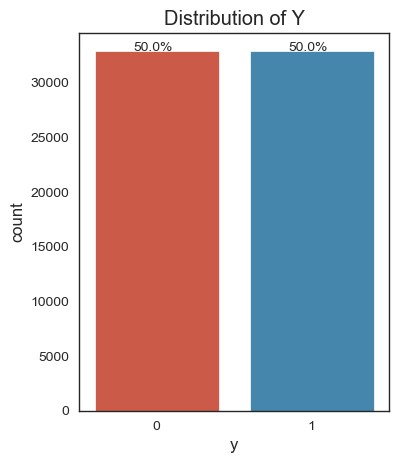

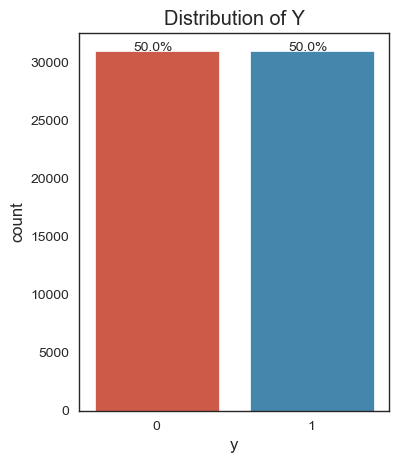

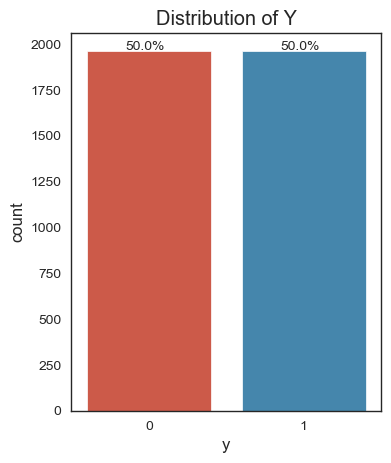

In [12]:
X_train,y_train = rebalance(X_train,y_train)
X_train_small,y_train_small = rebalance(X_train_small,y_train_small)
X_val,y_val = rebalance(X_val,y_val)

## 4.3 Transformation
- Standardize numerical features (excluding dummy variables)

In [13]:
# client_list_num = ['age']
# client_list_cat = 'job marital education default housing loan'.split()
# other_list_cat = 'contact month day_of_week poutcome'.split()
# other_list_num = 'campaign pdays previous emp.var.rate cons.price.idx euribor3m nr.employed'.split()

# def create_dummy(df,cat_list):
#     # create named dummy vairable for a dataframe
#     for cat in cat_list:
#         print(f"Now creating dummy variables (One Hot Encoder) for {cat}")
#         ec = OneHotEncoder()
#         data = ec.fit_transform(df[[cat]])
#         for i,kind in enumerate(ec.categories_[0]):
#             print(f"\t{kind}")
#             df[f"{cat}_{kind}"] = data[:,i].toarray().ravel()
            
            
full_pipeline = ColumnTransformer([
    ('number',StandardScaler(),client_list_num + other_list_num),
#     ('categories',OneHotEncoder(),client_list_cat + other_list_cat)
],remainder = 'passthrough')

X_train = full_pipeline.fit_transform(X_train)


X_train_small = full_pipeline.transform(X_train_small)
X_val = full_pipeline.transform(X_val)
X_test = full_pipeline.transform(X_test)

In [14]:
X_train.shape

(65782, 52)

# 5. Model Selection
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- KNN
- SVM
- Neural Network

## 5.1 Gradient Boosting Decision Trees

I will try two types of gradient boosting implementation: XGBoost and LightGBM. They differ mostly in their ways to determine split-points in trees.
- XGboost: uses pre-sorted algorithm (e.g. quick sort $O(n\log(n))$) & Histogram-based algorithm for computing the best split.  level-wise algorithm
    - Weighted Quantile Sketch (split points in the weighted samples that perform the best, where previously poorly fit samples receive higher weights)
    - Sparsity-aware Split finding: introduces a default direction in each tree node when a value is missing in the sparse column

- LightGBM:  leaf-wise algorithm
    - Gradient-based One-Side Sampling (GOSS): exclude a significant propor- tion of data instances with small gradients, and only use the rest to estimate the information gain
    - Exclusive Feature Bundling: bundle mutually exclusive features (i.e., they rarely take nonzero values simultaneously), to reduce the number of features (Whereas XGBoost’s Sparsity-aware split finding skips samples with empty values, reducing complexity row-wise, EFB bins similar features, reducing complexity column-wise.)

[(Source 1)](https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb)
[(Source 2)](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)


Some reference of how to tune hyper-parameters for boosting [(Source 3)](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db):

<img src="https://cdn-images-1.medium.com/max/2600/1*A0b_ahXOrrijazzJengwYw.png" alt="" title="Tunning" />

Other discussions:
[(Source 4)](https://rohitgr7.github.io/lightgbm-another-gradient-boosting/)
[(Source 5)](https://www.kaggle.com/c/home-credit-default-risk/discussion/60921)



In [125]:
# # clf = xgb.XGBClassifier(n_estimators=500,random_state = 46)

# train_gb = {'X':X_train_small,'y':y_train_small,'eval_set':[(X_val,y_val)],
#             'eval_metric': 'logloss',
#             'early_stopping_rounds':5}

# space  = [Integer(2, 10, name='max_depth'),
#           Real(10**-3, 10**0, "log-uniform", name='learning_rate'),
#           Integer(1, 200, name='min_child_weight'),
# #           Real(0.2,1, name='subsample'),
# #           Real(0.2,1, name='colsample_bytree'),
#           Real(10**-4, 10**0, "log-uniform", name='reg_lambda'),
#           Real(10**-4, 10**0, "log-uniform", name='reg_alpha')]


# @use_named_args(space)
# def objective(**params):
#     print(params)
#     try:
#         clf = xgb.XGBClassifier(n_estimators=500,random_state = 46,**params)
#     #     clf.set_params(**params)
#         clf.fit(**train_gb,verbose = True)
#         obj = np.mean(log_loss(y_val,clf.predict_proba(X_val)[:,1]))
#     except:
#         obj = 1e6
        
#     return obj

# %%time
# clf_gp = gp_minimize(objective, space, n_calls=40, random_state=11)

# print(f"Best score={clf_gp.fun:.4f}" )

# gb_params = {
#               'max_depth': 4,
#               'learning_rate': 0.3,
#               'min_child_weight': 1,
#               'subsample': 0.8,
# #               'colsample_bytree': 0.8,
#               'reg_lambda': 1, # l2 norm
#               'reg_alpha': 0, # l1 norm
#               'n_estimators':100}

# for key,value in zip(gb_params.keys(),clf_gp_x):
#     print(f"{key} is {value} \n")
#     gb_params[key] = value

In [16]:
clf = xgb.XGBClassifier()

param_dist = {
        'max_depth': randint(2,15),
        'learning_rate':  loguniform(10**-2, 10**0),
        'subsample': uniform(0,1),
        'colsample_bytree': uniform(0,1),
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0,100.0,500.0],
        'reg_lambda': loguniform(10**-2, 10**2),
        'n_estimators': [500],
        'random_state':[46]}

fit_params = {'X':X_train_small,
              'y':y_train_small,
              'eval_set':[(X_val,y_val)],
            'eval_metric': 'logloss',
            'early_stopping_rounds':5,
             'verbose':True}

rs_clf = RandomizedSearchCV(clf, param_dist, n_iter=120,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=11)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.3min


Randomized search time: 1000.0806112289429
Best score: -0.42738386205204154
Best params: 
colsample_bytree: 0.6160183850726514
learning_rate: 0.05284052019225355
max_depth: 13
min_child_weight: 3.0
n_estimators: 500
random_state: 46
reg_lambda: 0.5558578389628266
subsample: 0.7328253363481761


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 16.7min finished


In [17]:
# Now fit the best model
paras_xgb = best_params
xgb_clf = xgb.XGBClassifier(**paras_xgb)
xgb_clf.fit(**fit_params)

[0]	validation_0-logloss:0.676398
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.661479
[2]	validation_0-logloss:0.647397
[3]	validation_0-logloss:0.635177
[4]	validation_0-logloss:0.623971
[5]	validation_0-logloss:0.614939
[6]	validation_0-logloss:0.605782
[7]	validation_0-logloss:0.598084
[8]	validation_0-logloss:0.591847
[9]	validation_0-logloss:0.584182
[10]	validation_0-logloss:0.577261
[11]	validation_0-logloss:0.571676
[12]	validation_0-logloss:0.566802
[13]	validation_0-logloss:0.562093
[14]	validation_0-logloss:0.558491
[15]	validation_0-logloss:0.553682
[16]	validation_0-logloss:0.549315
[17]	validation_0-logloss:0.546415
[18]	validation_0-logloss:0.543773
[19]	validation_0-logloss:0.540812
[20]	validation_0-logloss:0.537527
[21]	validation_0-logloss:0.534687
[22]	validation_0-logloss:0.532033
[23]	validation_0-logloss:0.530621
[24]	validation_0-logloss:0.529292
[25]	validation_0-logloss:0.527868
[26]	validation_0-logloss:0.52736

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6160183850726514, gamma=0,
              learning_rate=0.05284052019225355, max_delta_step=0, max_depth=13,
              min_child_weight=3.0, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=46,
              reg_alpha=0, reg_lambda=0.5558578389628266, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7328253363481761,
              verbosity=1)

In [18]:
print(f'best_ntree_limit {xgb_clf.best_ntree_limit}')

best_ntree_limit 37


In [19]:
clf = lgb.LGBMClassifier(boosting_type='goss') #Gradient-based One-Side Sampling.

# learning rate decay (not recomended, because it may actual lead to overfitting (not the same as deep learning
# where decay is recommended))

# callbacks=[lgb.reset_parameter(learning_rate = lambda current_round: alpha * e**(k*current_round)

param_dist = {
#         'max_depth': randint(10,30), # I would use the num_leaves to control complexity rather than depth
                                    # we should let it be smaller than 2^(max_depth); default is -1, i.e. no limit
    'num_leaves':  randint(low = 20,high=200),
    'min_child_samples':randint(low = 20,high=200),
    'learning_rate':  loguniform(10**-2, 10**0),
        'subsample': uniform(0,1),
        'colsample_bytree': uniform(0,1),
        'reg_lambda': loguniform(10**-2, 10**2),
        'n_estimators': [500],
        'random_state':[1418]}

fit_params = {'X':X_train_small,
              'y':y_train_small,
              'eval_set':[(X_val,y_val)],
            'eval_metric': 'logloss',
            'early_stopping_rounds':10,
             'verbose':True}

rs_clf = RandomizedSearchCV(clf, param_dist, n_iter=400,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=11)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.8min


Randomized search time: 289.04913210868835
Best score: -0.4640508246170652
Best params: 
colsample_bytree: 0.6968256352874312
learning_rate: 0.020560195558211727
min_child_samples: 54
n_estimators: 500
num_leaves: 171
random_state: 1418
reg_lambda: 0.1336284586702551
subsample: 0.6592353418218574


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  4.8min finished


In [20]:
# Now fit the best model
paras_lgb = best_params
lgb_clf = lgb.LGBMClassifier(boosting_type='goss',**paras_lgb)
# lgb_clf = lgb.LGBMClassifier(**{
#  'learning_rate': 0.043672255117886805,
#  'min_child_samples': 58,
#  'n_estimators': 500,
#  'num_leaves': 187,
#  'random_state': 1418,
#  'reg_lambda': 0.07231266322246098})

lgb_clf.fit(**fit_params)


[1]	valid_0's binary_logloss: 0.686056
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.679611
[3]	valid_0's binary_logloss: 0.673143
[4]	valid_0's binary_logloss: 0.667081
[5]	valid_0's binary_logloss: 0.661369
[6]	valid_0's binary_logloss: 0.655549
[7]	valid_0's binary_logloss: 0.650232
[8]	valid_0's binary_logloss: 0.644957
[9]	valid_0's binary_logloss: 0.639684
[10]	valid_0's binary_logloss: 0.634641
[11]	valid_0's binary_logloss: 0.630147
[12]	valid_0's binary_logloss: 0.625704
[13]	valid_0's binary_logloss: 0.62153
[14]	valid_0's binary_logloss: 0.617316
[15]	valid_0's binary_logloss: 0.613376
[16]	valid_0's binary_logloss: 0.609369
[17]	valid_0's binary_logloss: 0.605764
[18]	valid_0's binary_logloss: 0.602342
[19]	valid_0's binary_logloss: 0.598768
[20]	valid_0's binary_logloss: 0.595362
[21]	valid_0's binary_logloss: 0.592339
[22]	valid_0's binary_logloss: 0.588989
[23]	valid_0's binary_logloss: 0.585895
[24]	valid_0's binary_logloss

LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.6968256352874312, importance_type='split',
               learning_rate=0.020560195558211727, max_depth=-1,
               min_child_samples=54, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=171, objective=None,
               random_state=1418, reg_alpha=0.0, reg_lambda=0.1336284586702551,
               silent=True, subsample=0.6592353418218574,
               subsample_for_bin=200000, subsample_freq=0)


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]




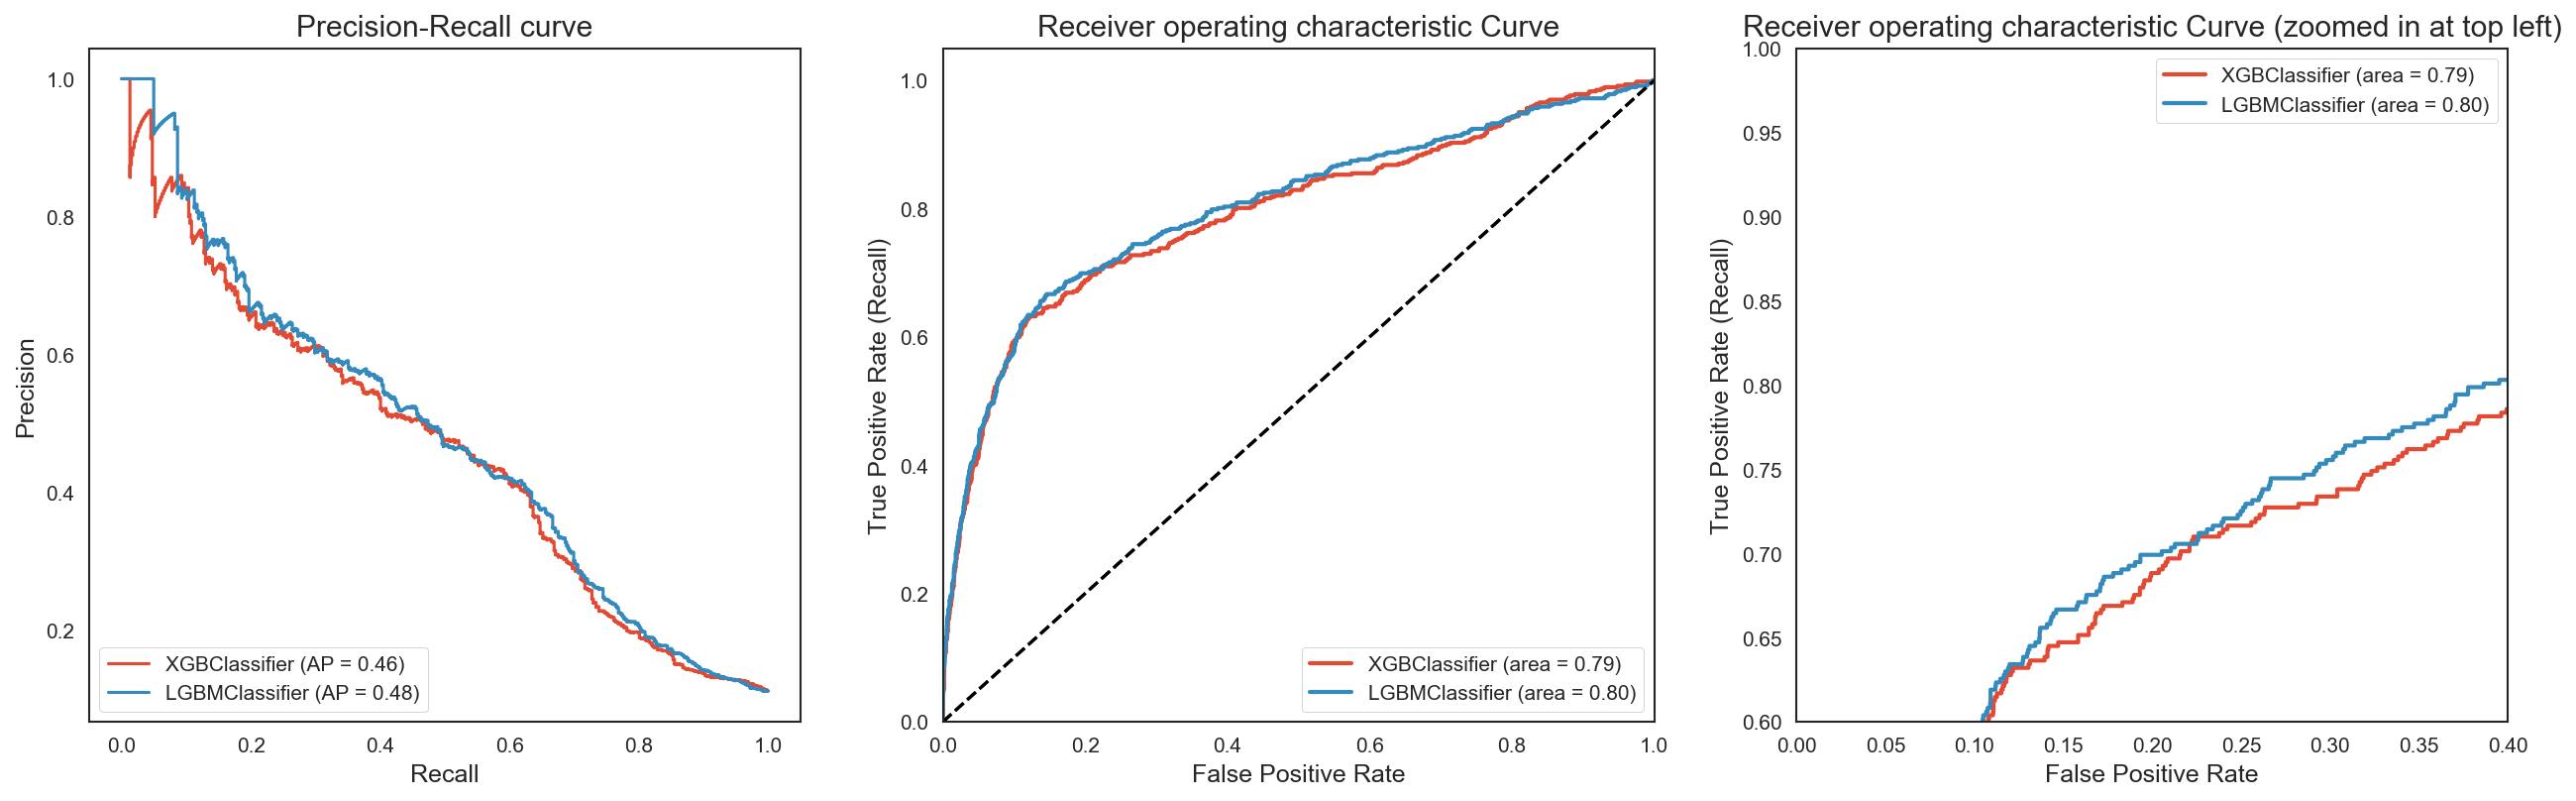

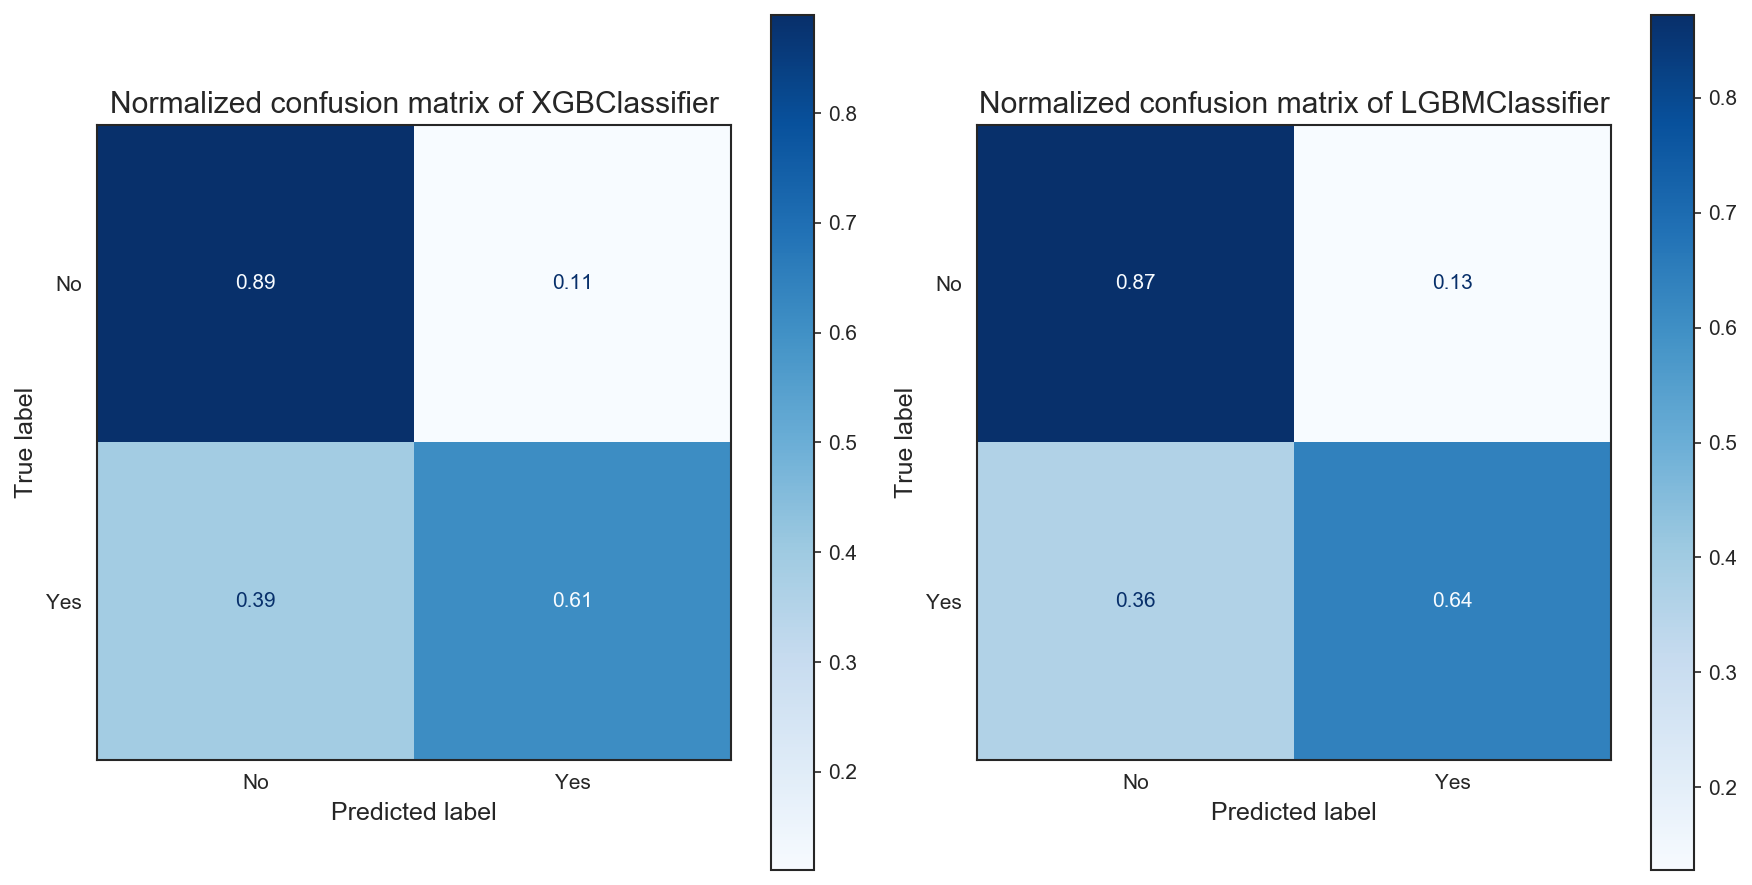

In [21]:
binary_testing([xgb_clf,lgb_clf],X_test,y_test)

In [22]:
# xgb_clf.save_model('xgb_clf.h5')

## 5.2 Random Forrest

In [23]:
# The following uses Scikit-Learn Implementation
# clf = RandomForestClassifier()

# param_dist = {
#         'n_estimators': [100,200,300,400,500,1000,2000],
#         'max_depth': [10,20,40,80,120,None],
#         'min_samples_split':  [2, 5, 10],
#         'min_samples_leaf': randint(1,100),
#         'max_leaf_nodes': [10,100,None],
#          'random_state':[46],
#         'n_jobs':[-1],
#             'verbose':[True]}

# fit_params = {'X':X_train,
#               'y':y_train}


# I would use XGBoost implementation of RF
clf = xgb.XGBRFClassifier()

param_dist = {
        'num_parallel_tree': [100,200,300,400,500,1000,2000],
        'subsample': uniform(0,0.99),
        'max_depth': [5,10,20,40,80,120,1000],
        'reg_lambda': loguniform(10**-2, 10**2),
        'random_state':[46],
        'n_jobs':[-1],
        'verbose':[True]}

rs_clf = RandomizedSearchCV(clf, param_dist, n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=42)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 15.9min


Randomized search time: 1213.728754043579
Best score: -0.27195787615567196
Best params: 
max_depth: 120
n_jobs: -1
num_parallel_tree: 1000
random_state: 46
reg_lambda: 0.010071984838809191
subsample: 0.9822894436983053
verbose: True


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 20.2min finished


In [24]:
# Now fit the best model

paras_rf = best_params
rf_clf = clf = xgb.XGBRFClassifier(**paras_rf)
rf_clf.fit(**fit_params)

[0]	validation_0-logloss:0.62314
Will train until validation_0-logloss hasn't improved in 10 rounds.


XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=120, min_child_weight=1, missing=None,
                n_estimators=100, n_jobs=-1, nthread=None,
                num_parallel_tree=1000, objective='binary:logistic',
                random_state=46, reg_alpha=0, reg_lambda=0.010071984838809191,
                scale_pos_weight=1, seed=None, silent=None,
                subsample=0.9822894436983053, verbose=True, verbosity=1)


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

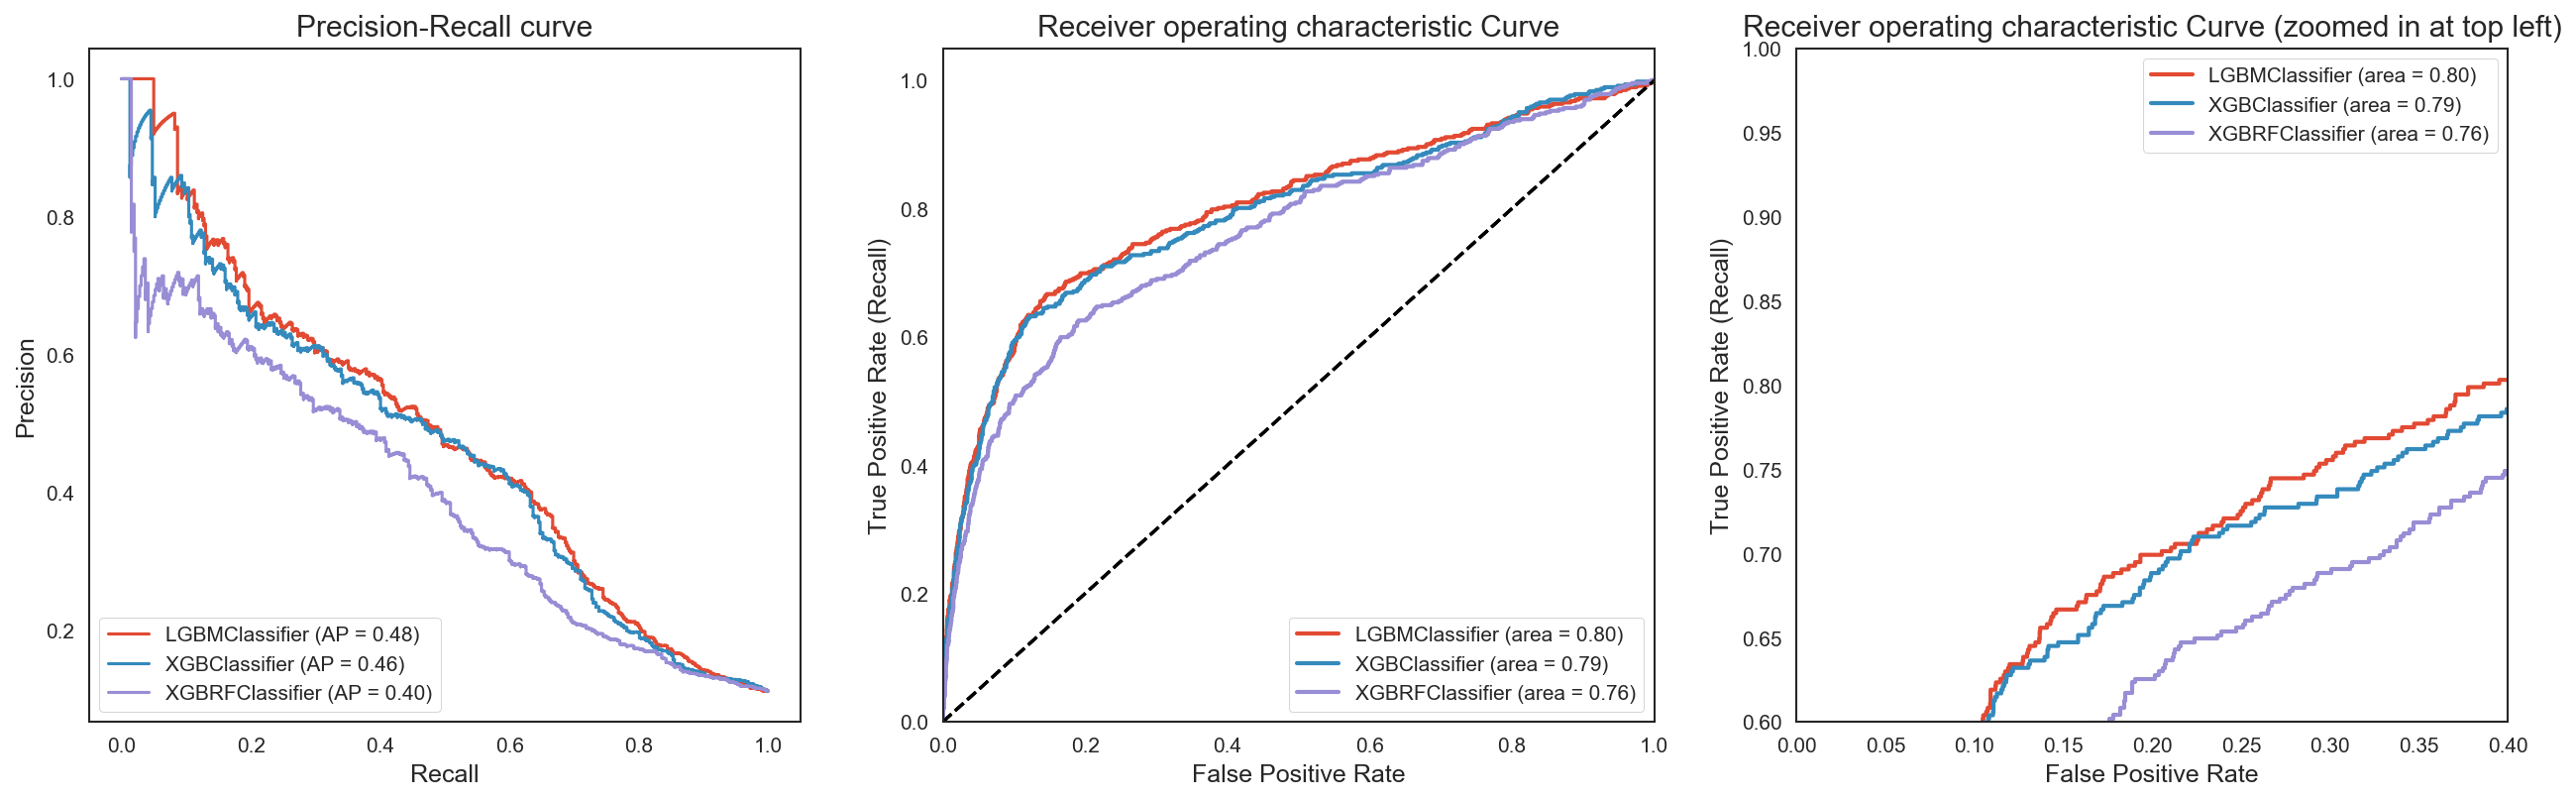

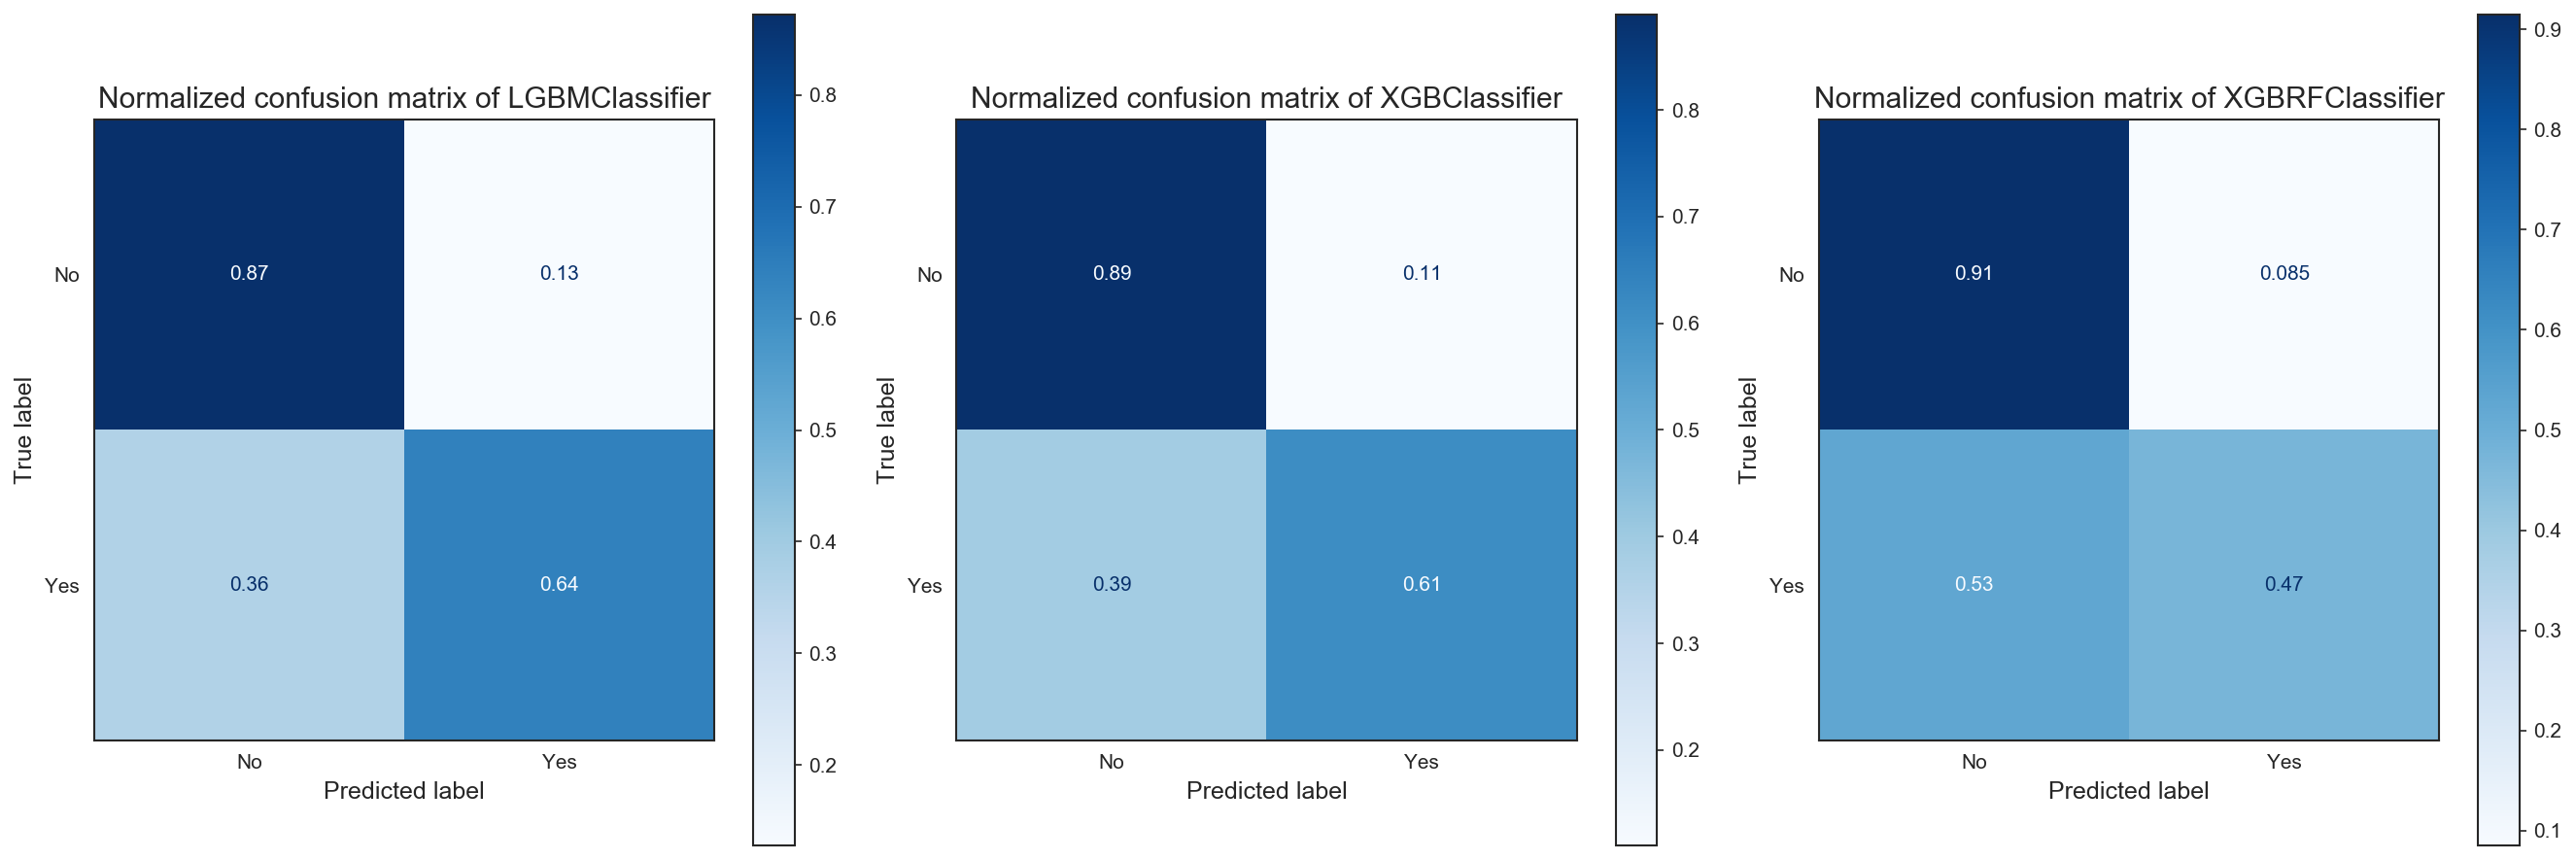

In [25]:
binary_testing([lgb_clf,xgb_clf,rf_clf],X_test,y_test)

# 5.3 Logistic Regression

In [26]:
clf = LogisticRegression()

param_dist = {
        'penalty':  ['elasticnet'], #['l1','l2'],
        'solver': ['saga'], # only saga supports elastic net
        'C': np.logspace(-5, 5, 60),
        'l1_ratio':  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
        'random_state':[46],
        'n_jobs':[-1],
        'verbose':[1]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = GridSearchCV(clf, param_dist, # n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 660 candidates, totalling 1980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 23.6min


Randomized search time: 2062.9546213150024
Best score: -0.5329633820743039
Best params: 
C: 100000.0
l1_ratio: 1
n_jobs: -1
penalty: 'elasticnet'
random_state: 46
solver: 'saga'
verbose: 1


[Parallel(n_jobs=-1)]: Done 1980 out of 1980 | elapsed: 34.4min finished


In [27]:
# Now fit the best model
paras_log = best_params
log_clf = LogisticRegression(**paras_log)
log_clf.fit(**fit_params)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 6 seconds


/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                   max_iter=100, multi_class='auto', n_jobs=-1,
                   penalty='elasticnet', random_state=46, solver='saga',
                   tol=0.0001, verbose=1, warm_start=False)


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

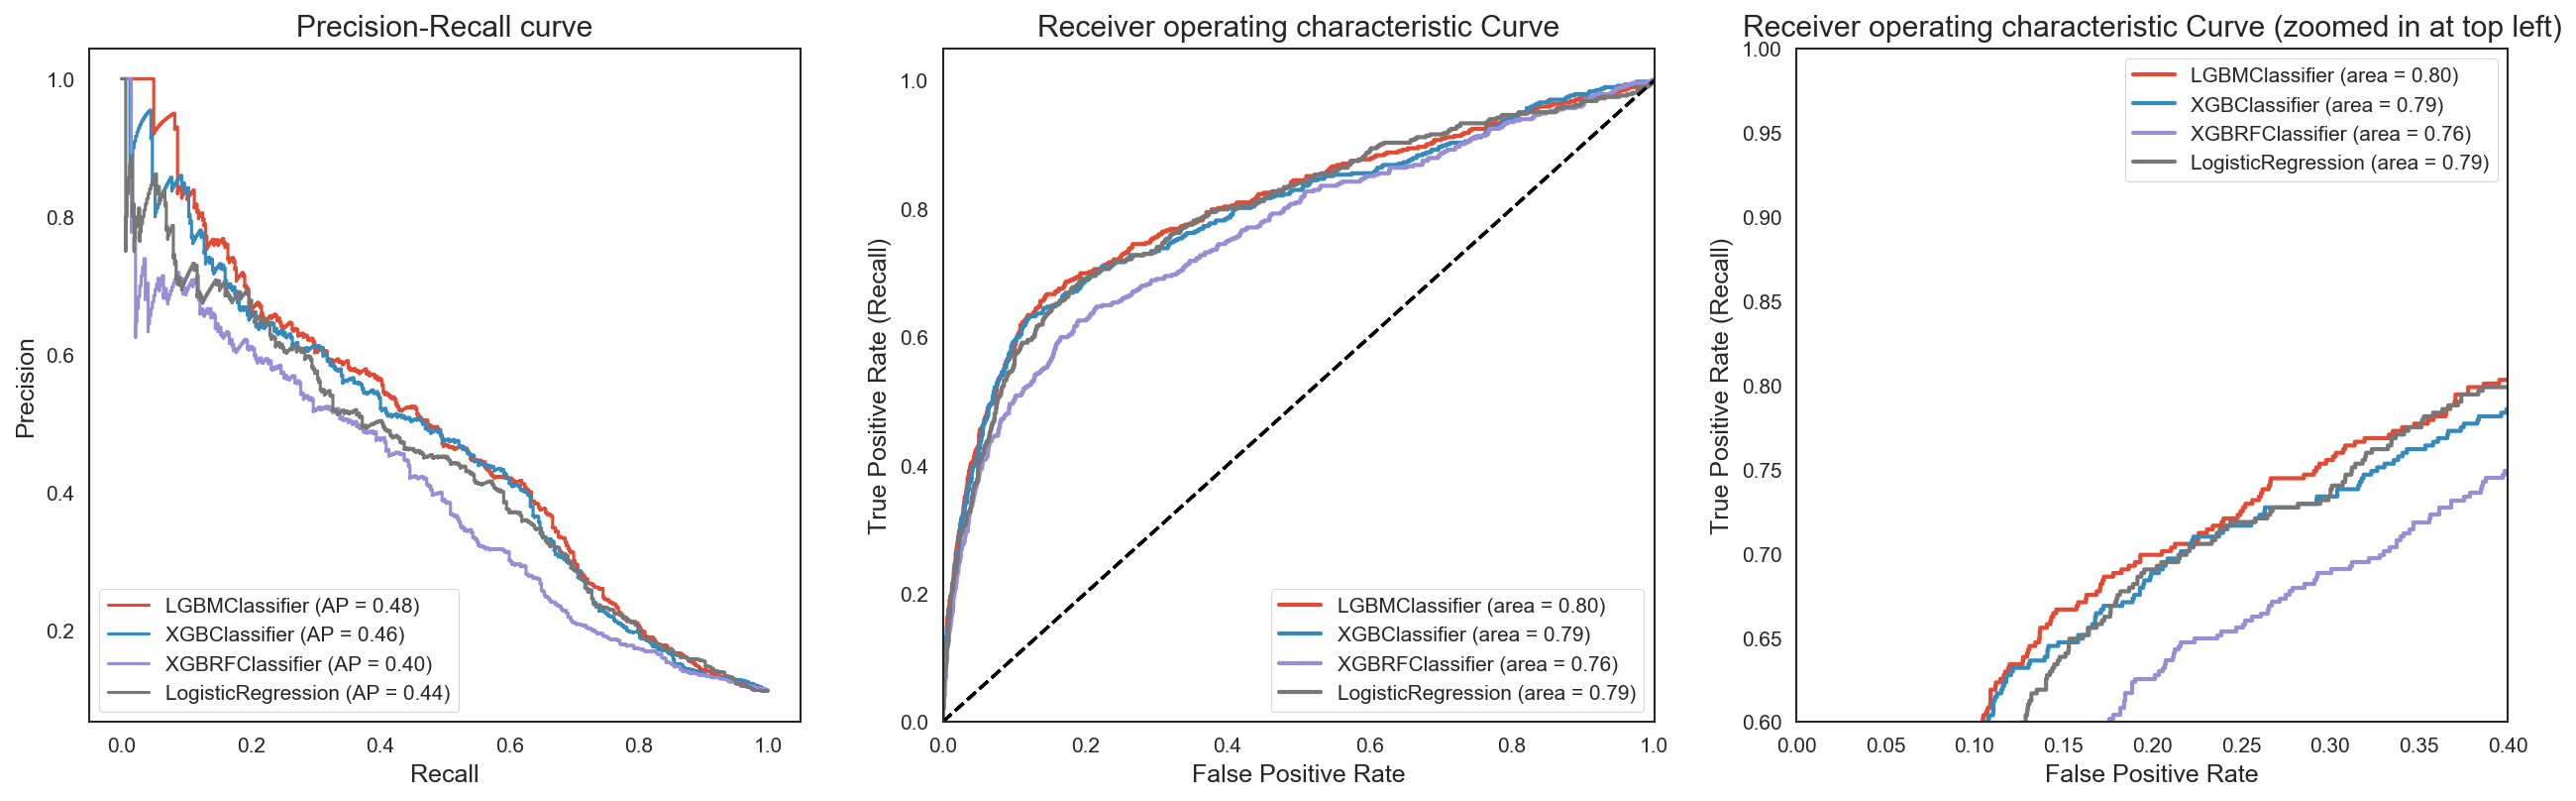

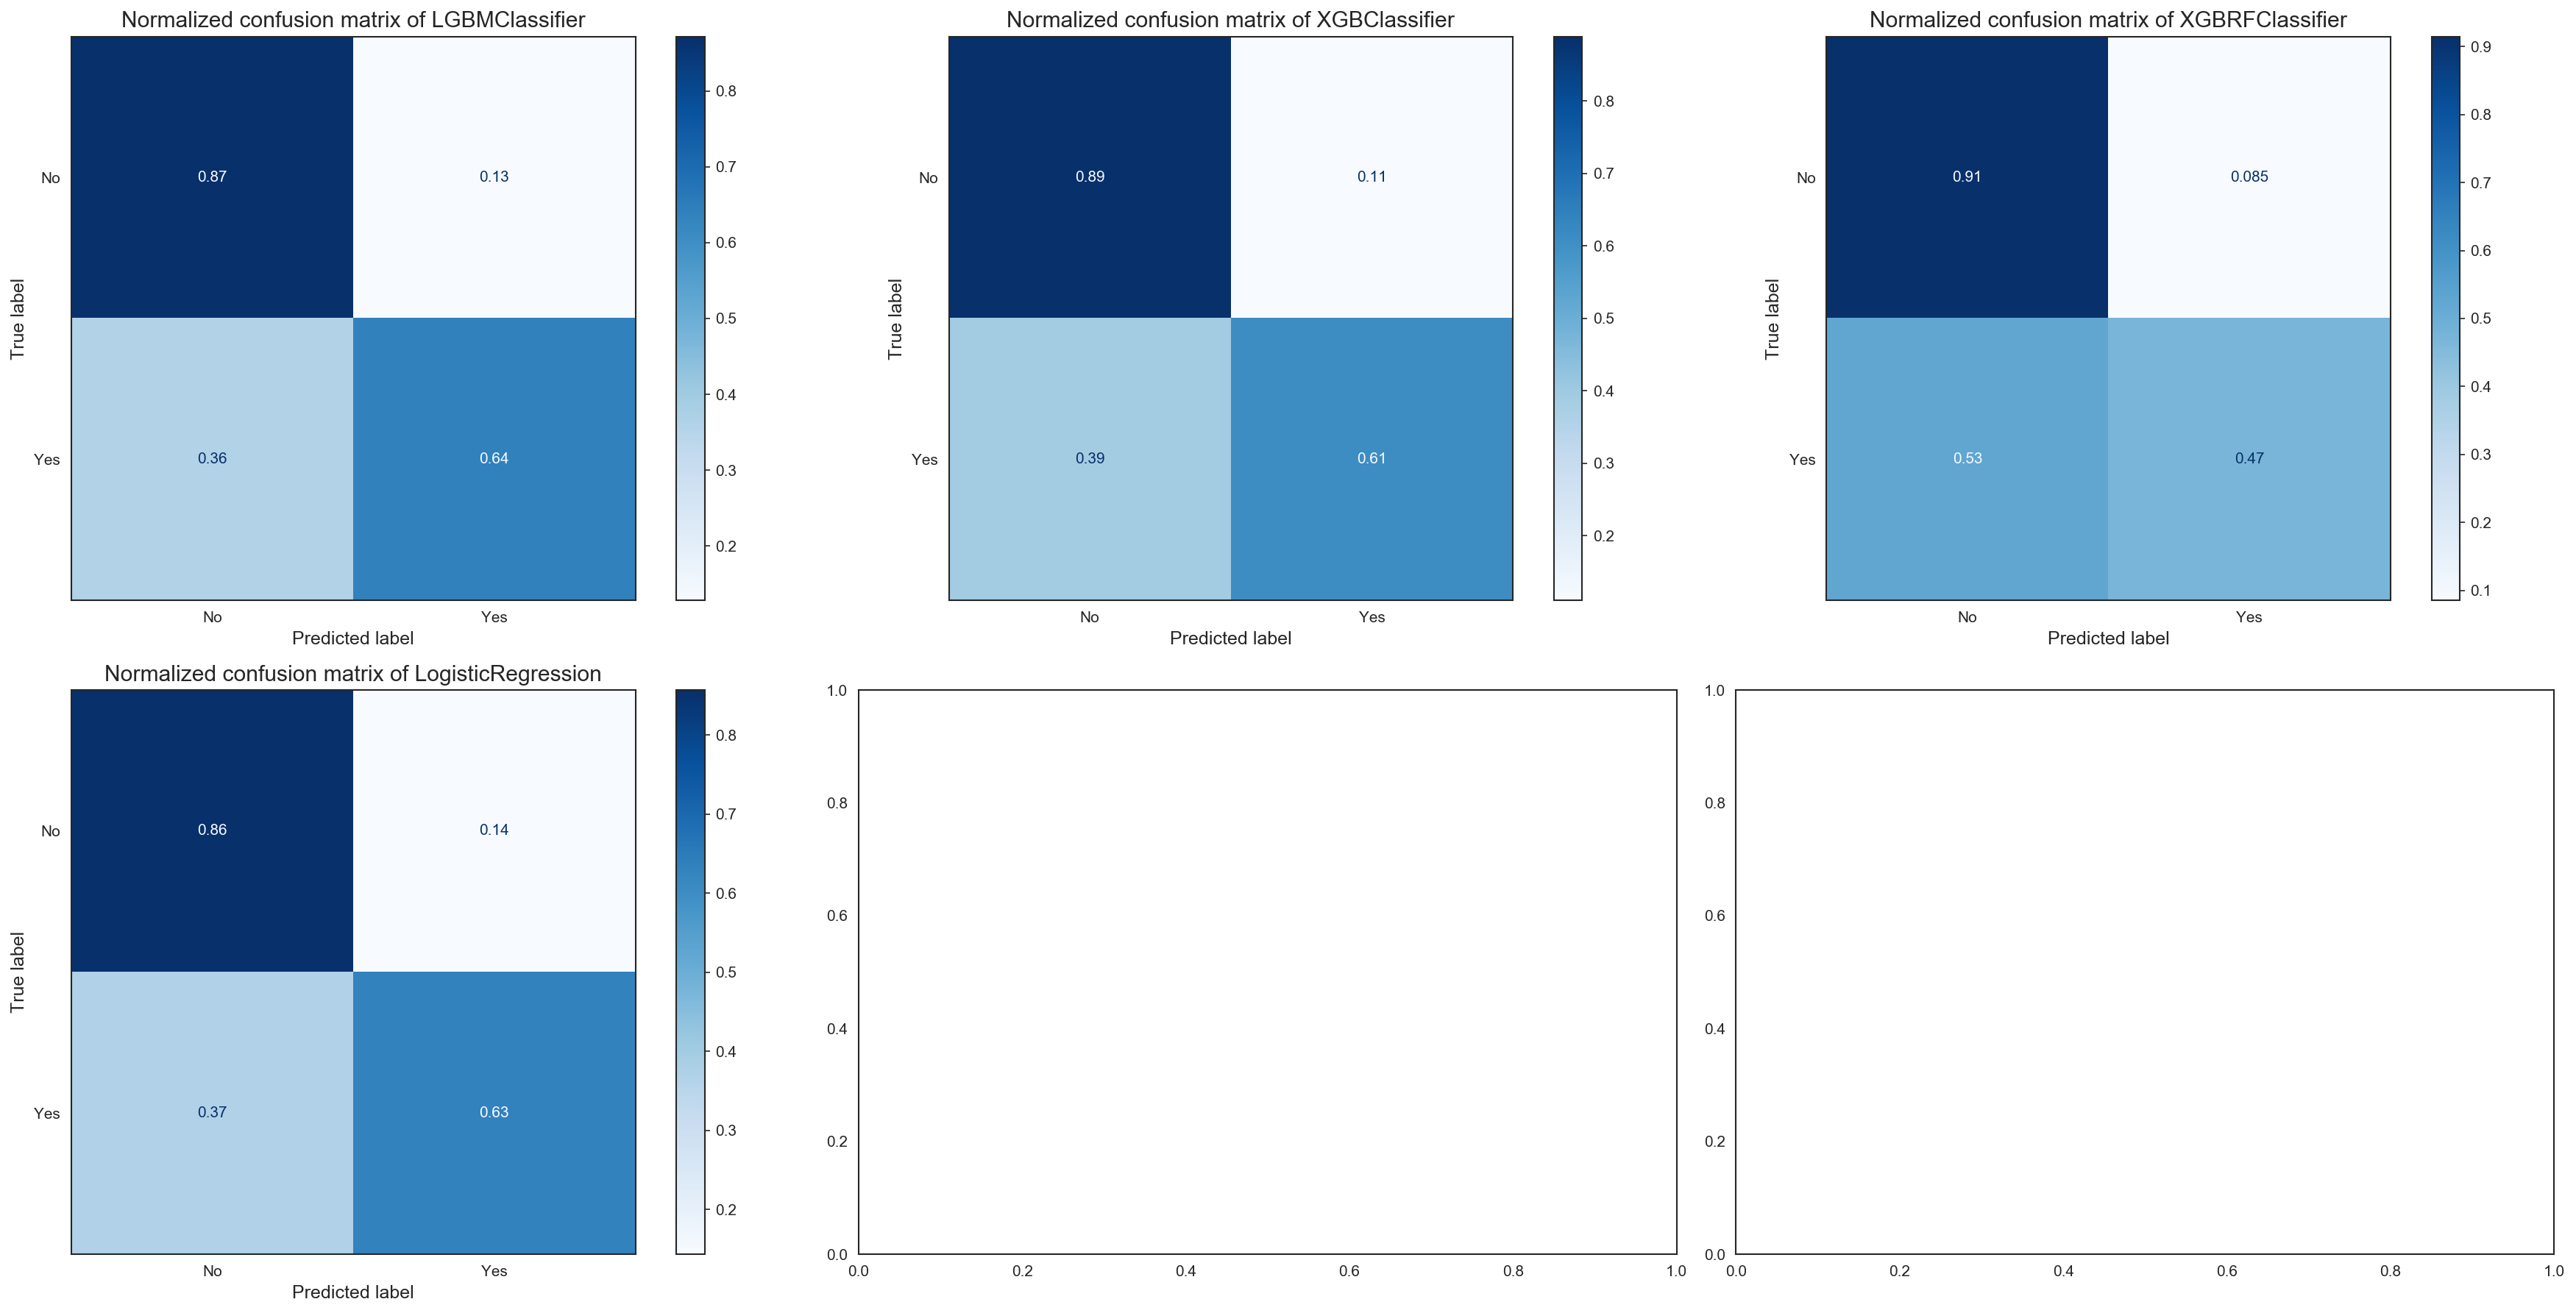

In [28]:
binary_testing([lgb_clf,xgb_clf,rf_clf,log_clf],X_test,y_test)

# 5.4 SDG
- linear regression + hinge loss see page 355 of ISL
- For classification purposes, a variant of the Huber loss called modified Huber is sometimes used. 

In [29]:
clf = SGDClassifier()

param_dist = {
        'loss':['modified_huber'],
        'penalty': ['elasticnet'],#['l1','l2'],
        'l1_ratio':  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
        'alpha': np.logspace(-4, 4, 40),
        'random_state':[46],
        'verbose':[1],
        'n_jobs':[-1]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = GridSearchCV(clf, param_dist, # n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 440 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.1min


Randomized search time: 257.8650109767914
Best score: -0.5527255114854411
Best params: 
alpha: 0.11937766417144358
l1_ratio: 0.3
loss: 'modified_huber'
n_jobs: -1
penalty: 'elasticnet'
random_state: 46
verbose: 1


[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed:  4.3min finished


In [30]:
# Now fit the best model
paras_sdg = best_params
sdg_clf = SGDClassifier(**paras_sdg)
sdg_clf.fit(**fit_params)

-- Epoch 1
Norm: 2.50, NNZs: 7, Bias: 1.944298, T: 65782, Avg. loss: 4.938066
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 1.64, NNZs: 8, Bias: 1.732215, T: 131564, Avg. loss: 0.918758
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 1.33, NNZs: 8, Bias: 1.613439, T: 197346, Avg. loss: 0.840747
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 1.16, NNZs: 8, Bias: 1.531645, T: 263128, Avg. loss: 0.815288
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 1.06, NNZs: 9, Bias: 1.472792, T: 328910, Avg. loss: 0.799832
Total training time: 0.20 seconds.
-- Epoch 6
Norm: 1.00, NNZs: 9, Bias: 1.427980, T: 394692, Avg. loss: 0.789027
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 0.95, NNZs: 9, Bias: 1.391216, T: 460474, Avg. loss: 0.781791
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 0.92, NNZs: 9, Bias: 1.361154, T: 526256, Avg. loss: 0.777469
Total training time: 0.32 seconds.
-- Epoch 9
Norm: 0.89, NNZs: 9, Bias: 1.335281, T: 592038, Avg. loss: 0.773435
Total trai

SGDClassifier(alpha=0.11937766417144358, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=46, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=1, warm_start=False)


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

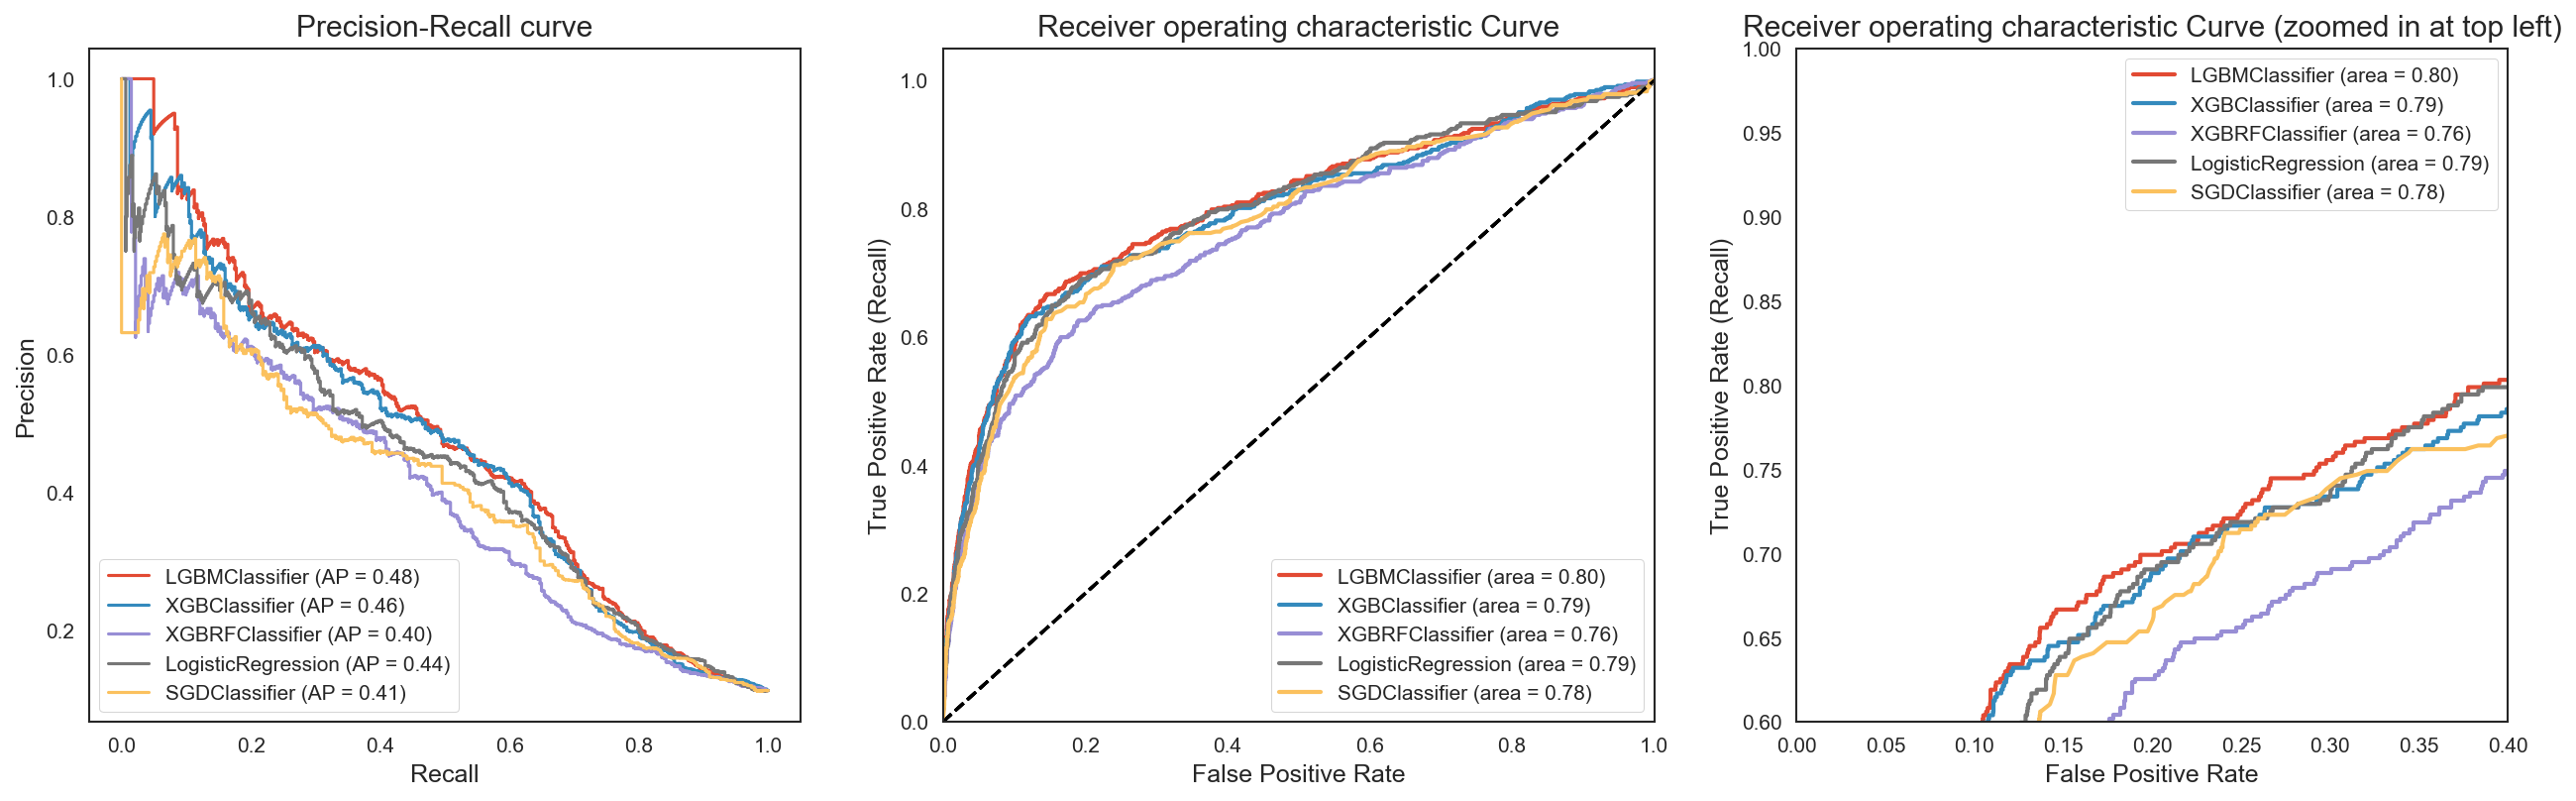

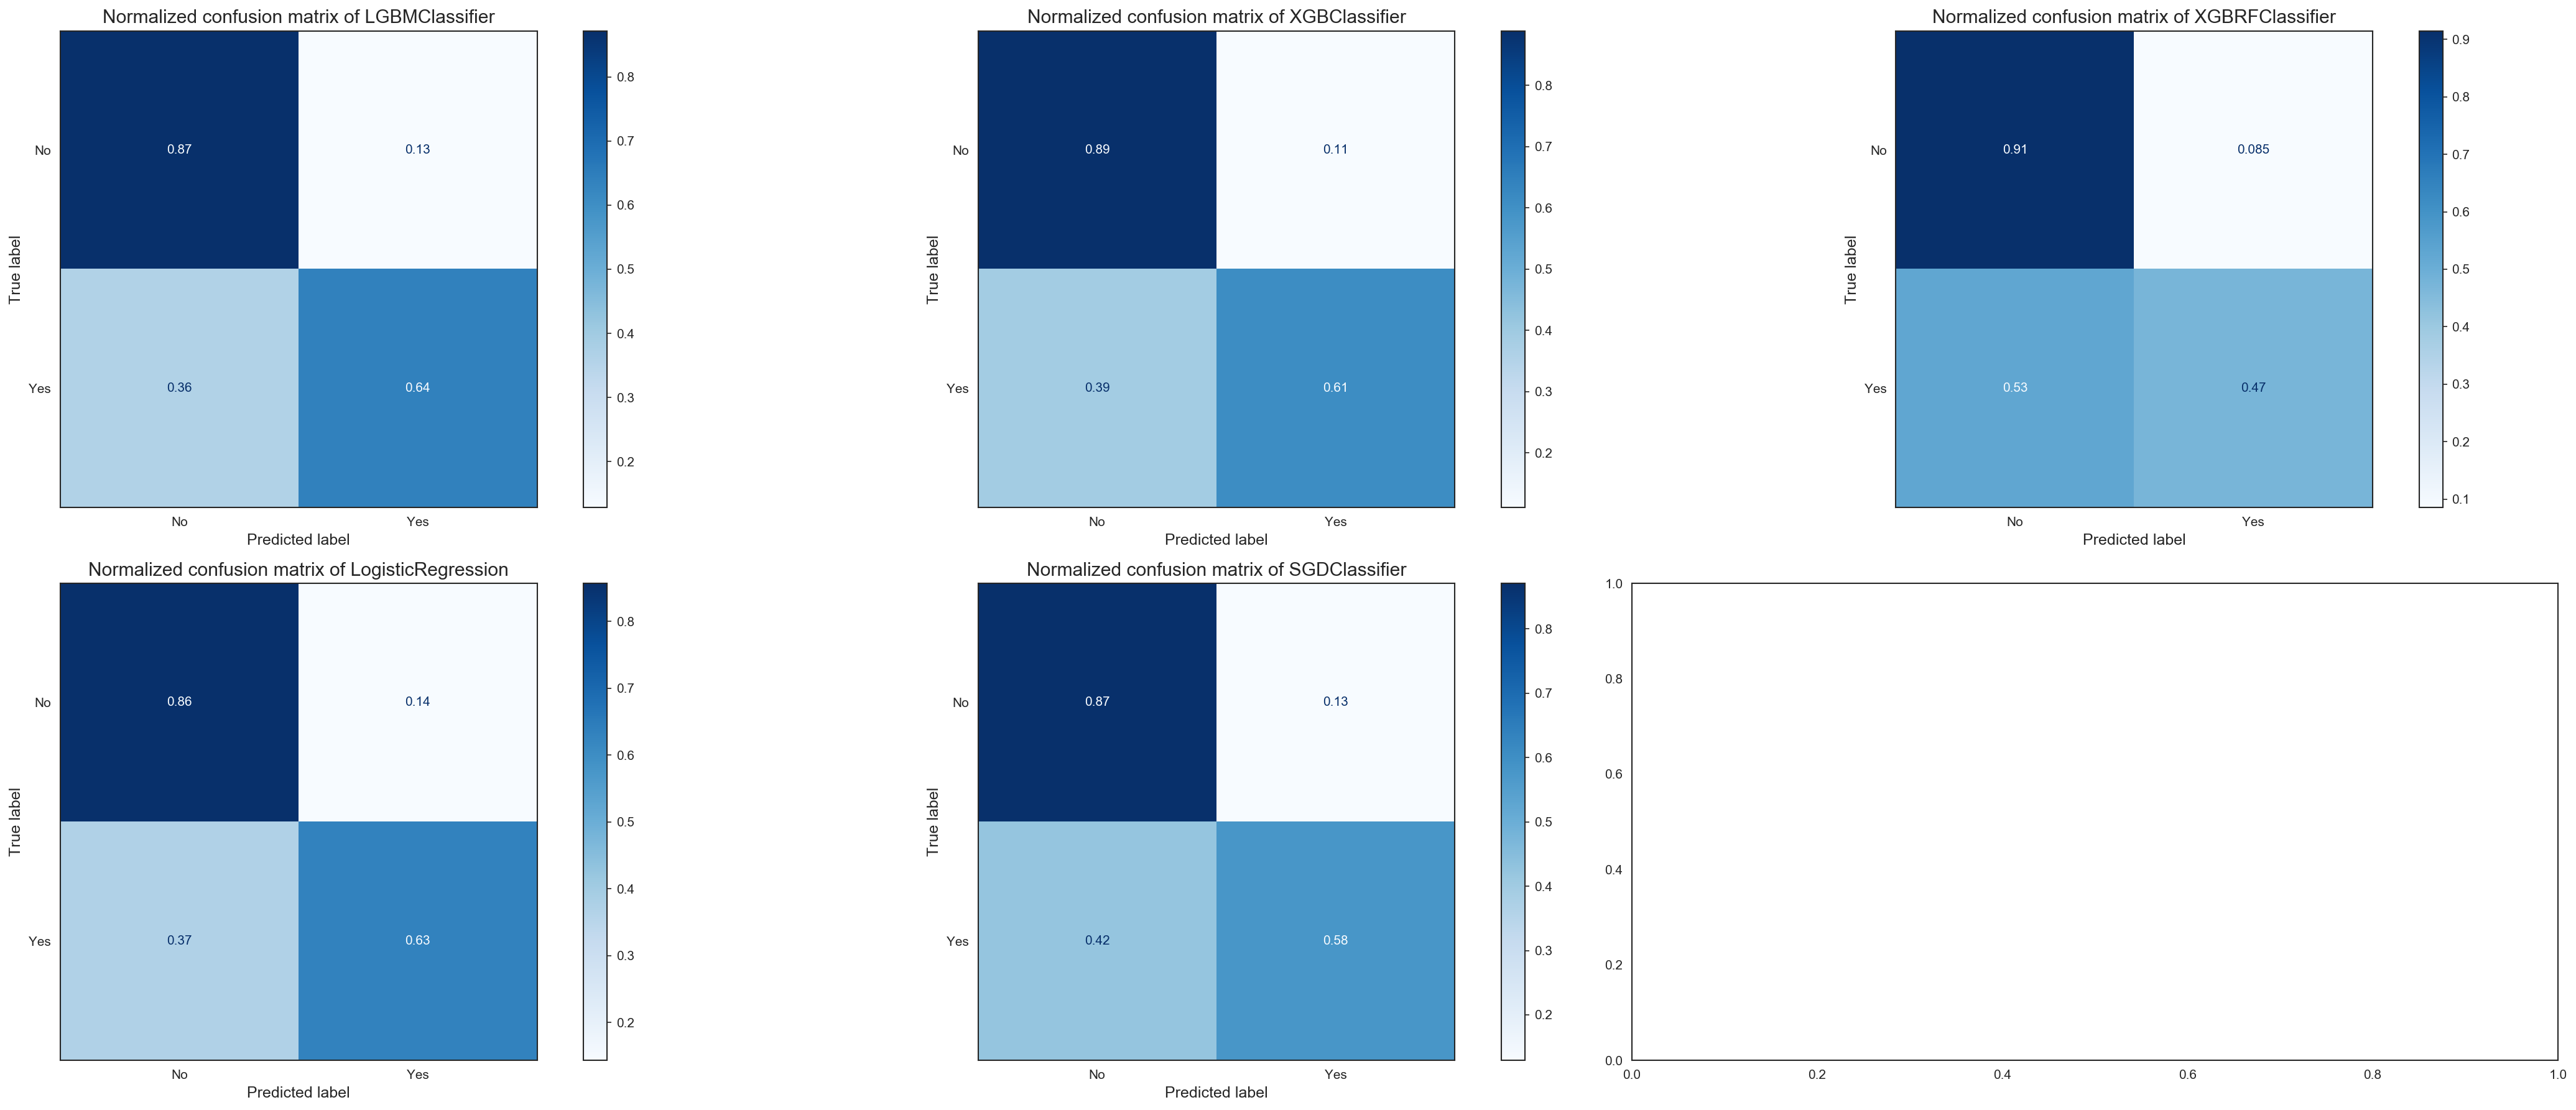

In [31]:
binary_testing([lgb_clf,xgb_clf,rf_clf,log_clf,sdg_clf],X_test,y_test)

# 5.5 AdaBoost

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_dist = {
        'learning_rate':loguniform(10**-3, 10**-1),
        'n_estimators': randint(10,55),
        'random_state':[46]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = RandomizedSearchCV(clf, param_dist,  n_iter=60,random_state=11,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min


Randomized search time: 127.83674597740173
Best score: -0.5736354418364843
Best params: 
learning_rate: 0.02676232669306173
n_estimators: 11
random_state: 46


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


In [34]:
# Now fit the best model
paras_ada = best_params
ada_clf = AdaBoostClassifier(**paras_ada)
ada_clf.fit(**fit_params)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.02676232669306173, n_estimators=11,
                   random_state=46)


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

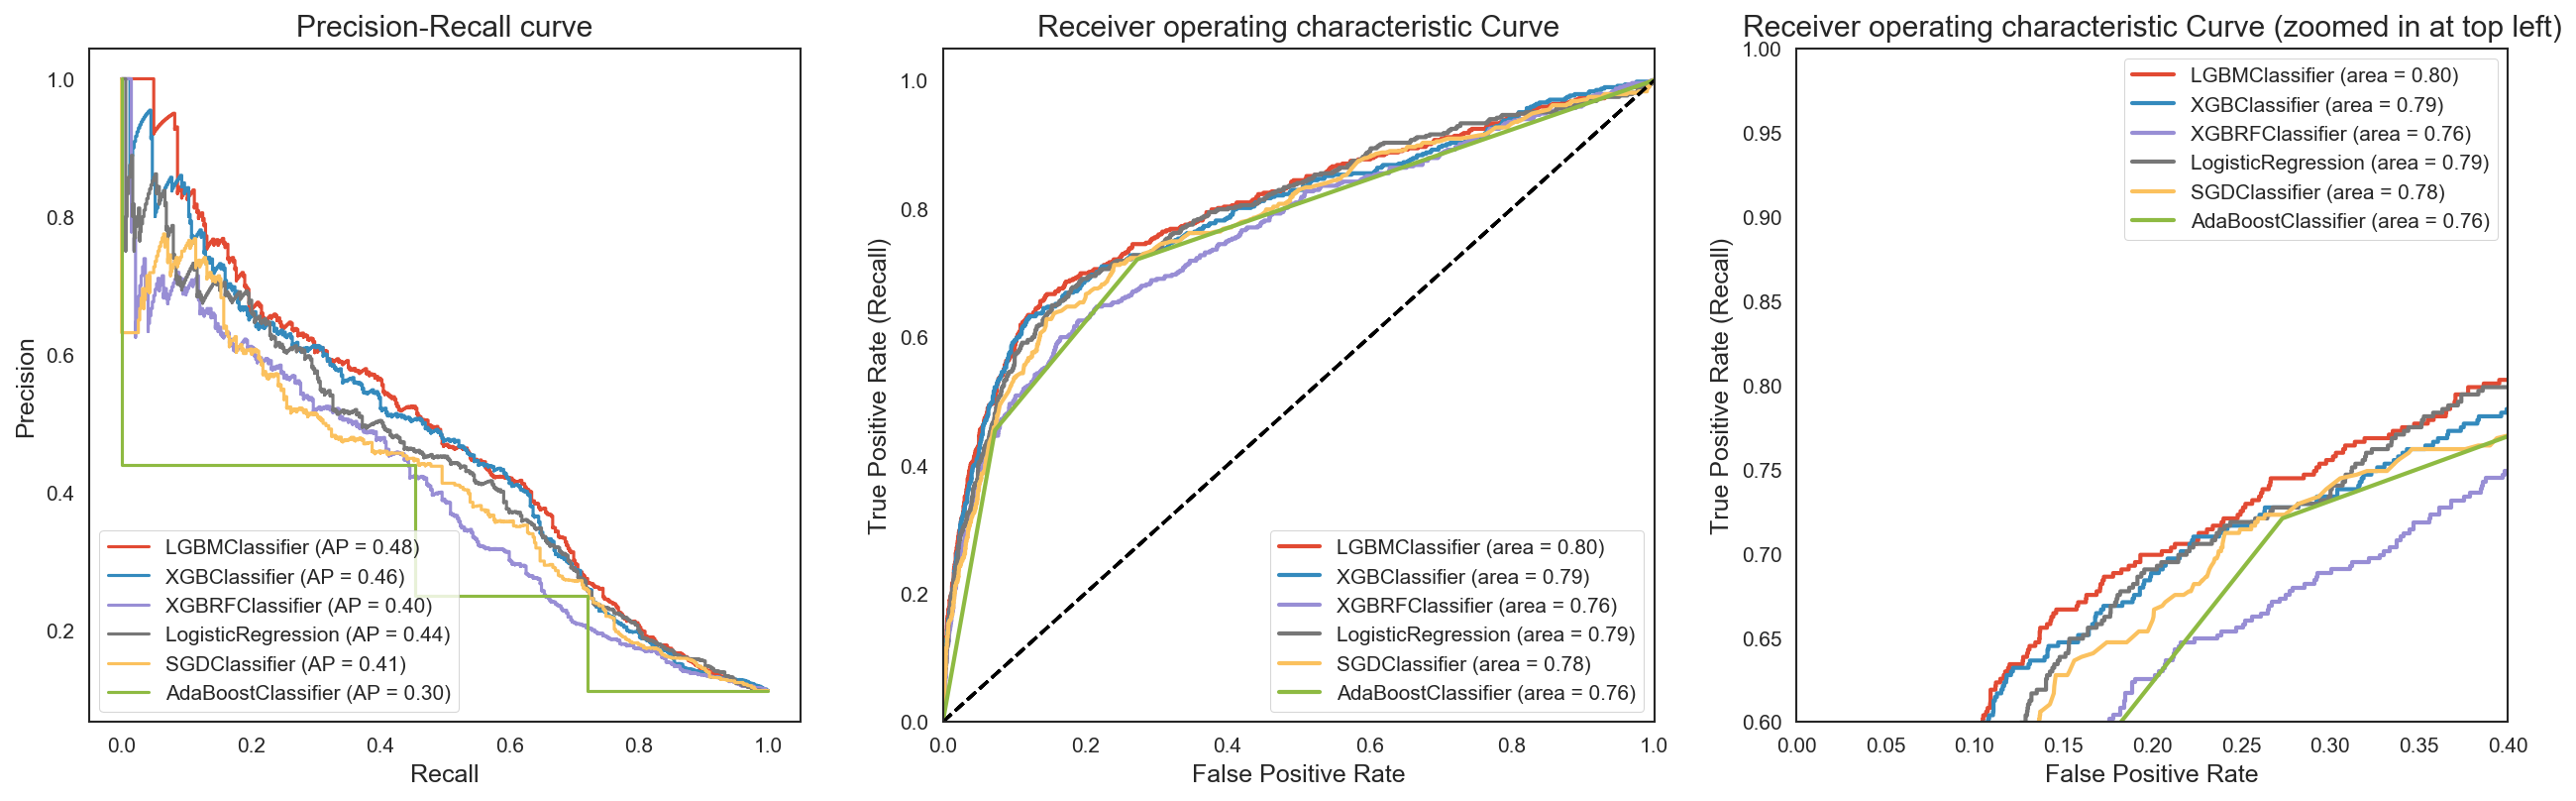

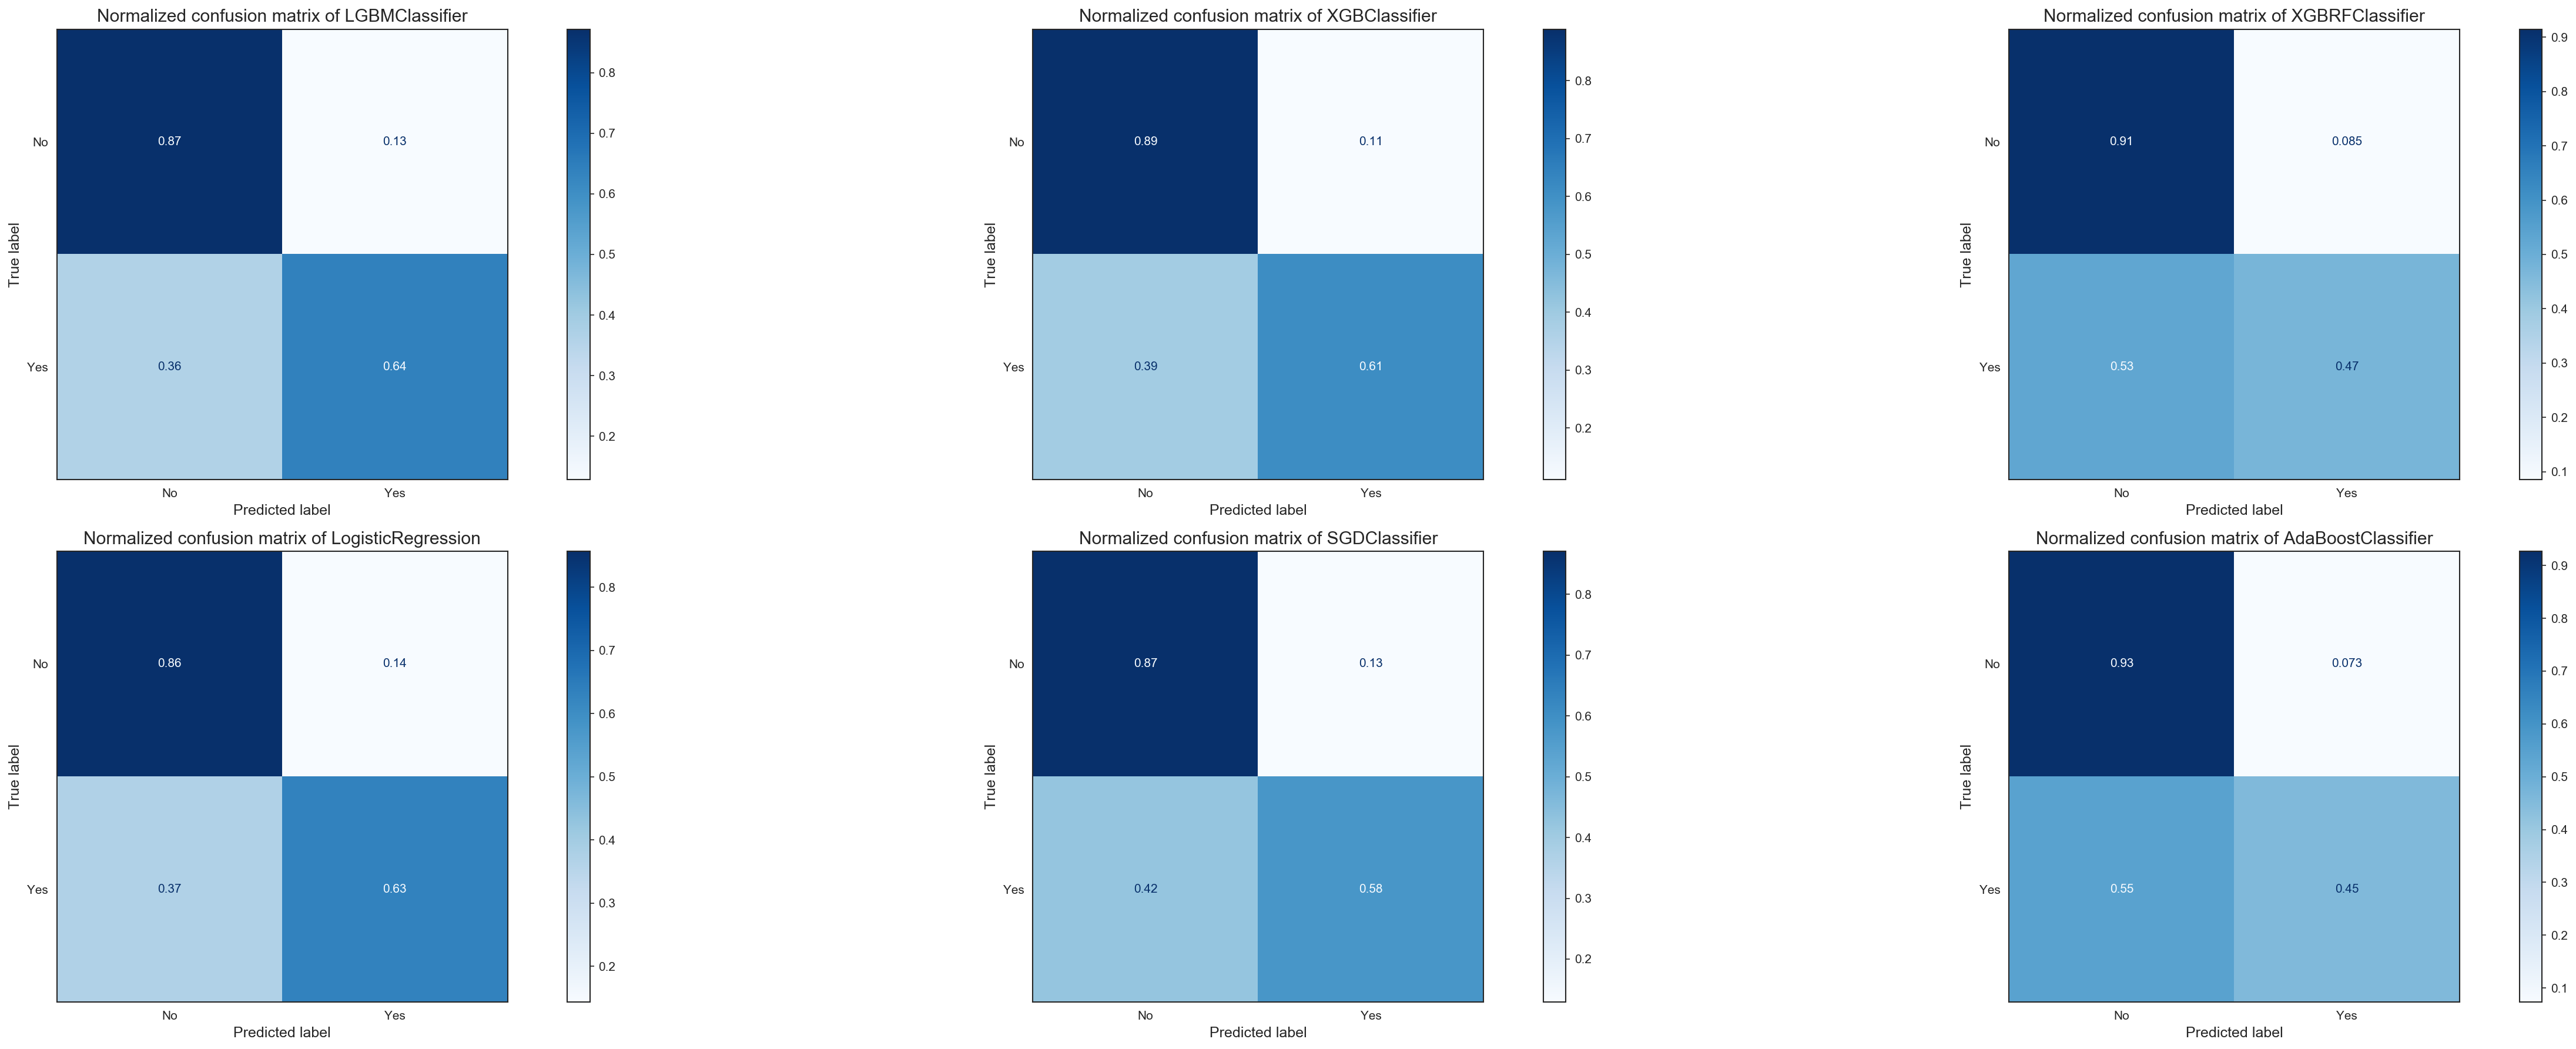

In [35]:
binary_testing([lgb_clf,xgb_clf,rf_clf,log_clf,sdg_clf,ada_clf],X_test,y_test)

# 5.6 Voting Classifier

In [36]:
lgb1 = lgb.LGBMClassifier(boosting_type='goss')
xbg1 = xgb.XGBClassifier()
# rnd1 = RandomForestClassifier()
rf1 = xgb.XGBRFClassifier()
svm1 = SGDClassifier(loss='modified_huber') #LinearSVC(loss = 'hinge',dual=False)
log1 = LogisticRegression()
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

voting_clf = VotingClassifier(
estimators=[('lgb',lgb1),('xgb',xbg1),
            ('rf',rf1),('SVM',svm1),
            ('logistic',log1),('ada',ada1)],
voting = 'soft',n_jobs=-1)

In [37]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(boosting_type='goss',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsam...
                                                          


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

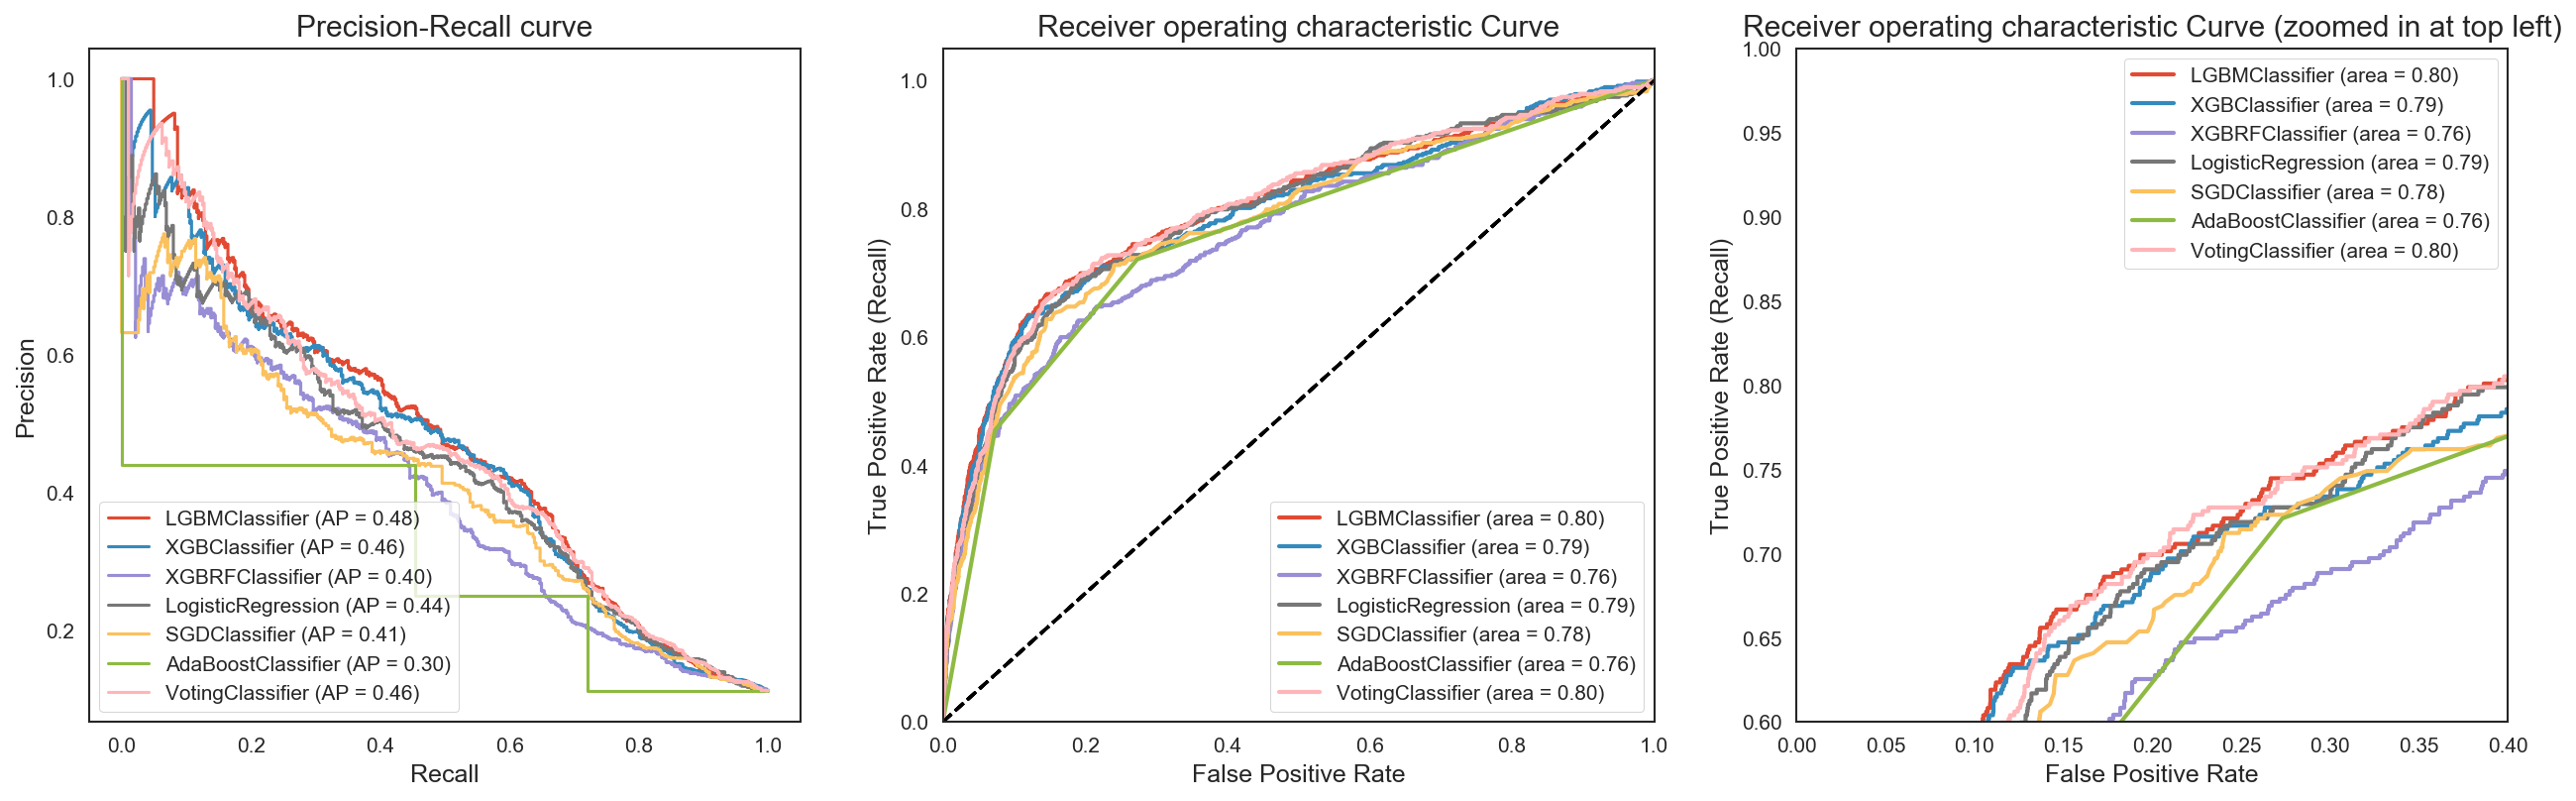

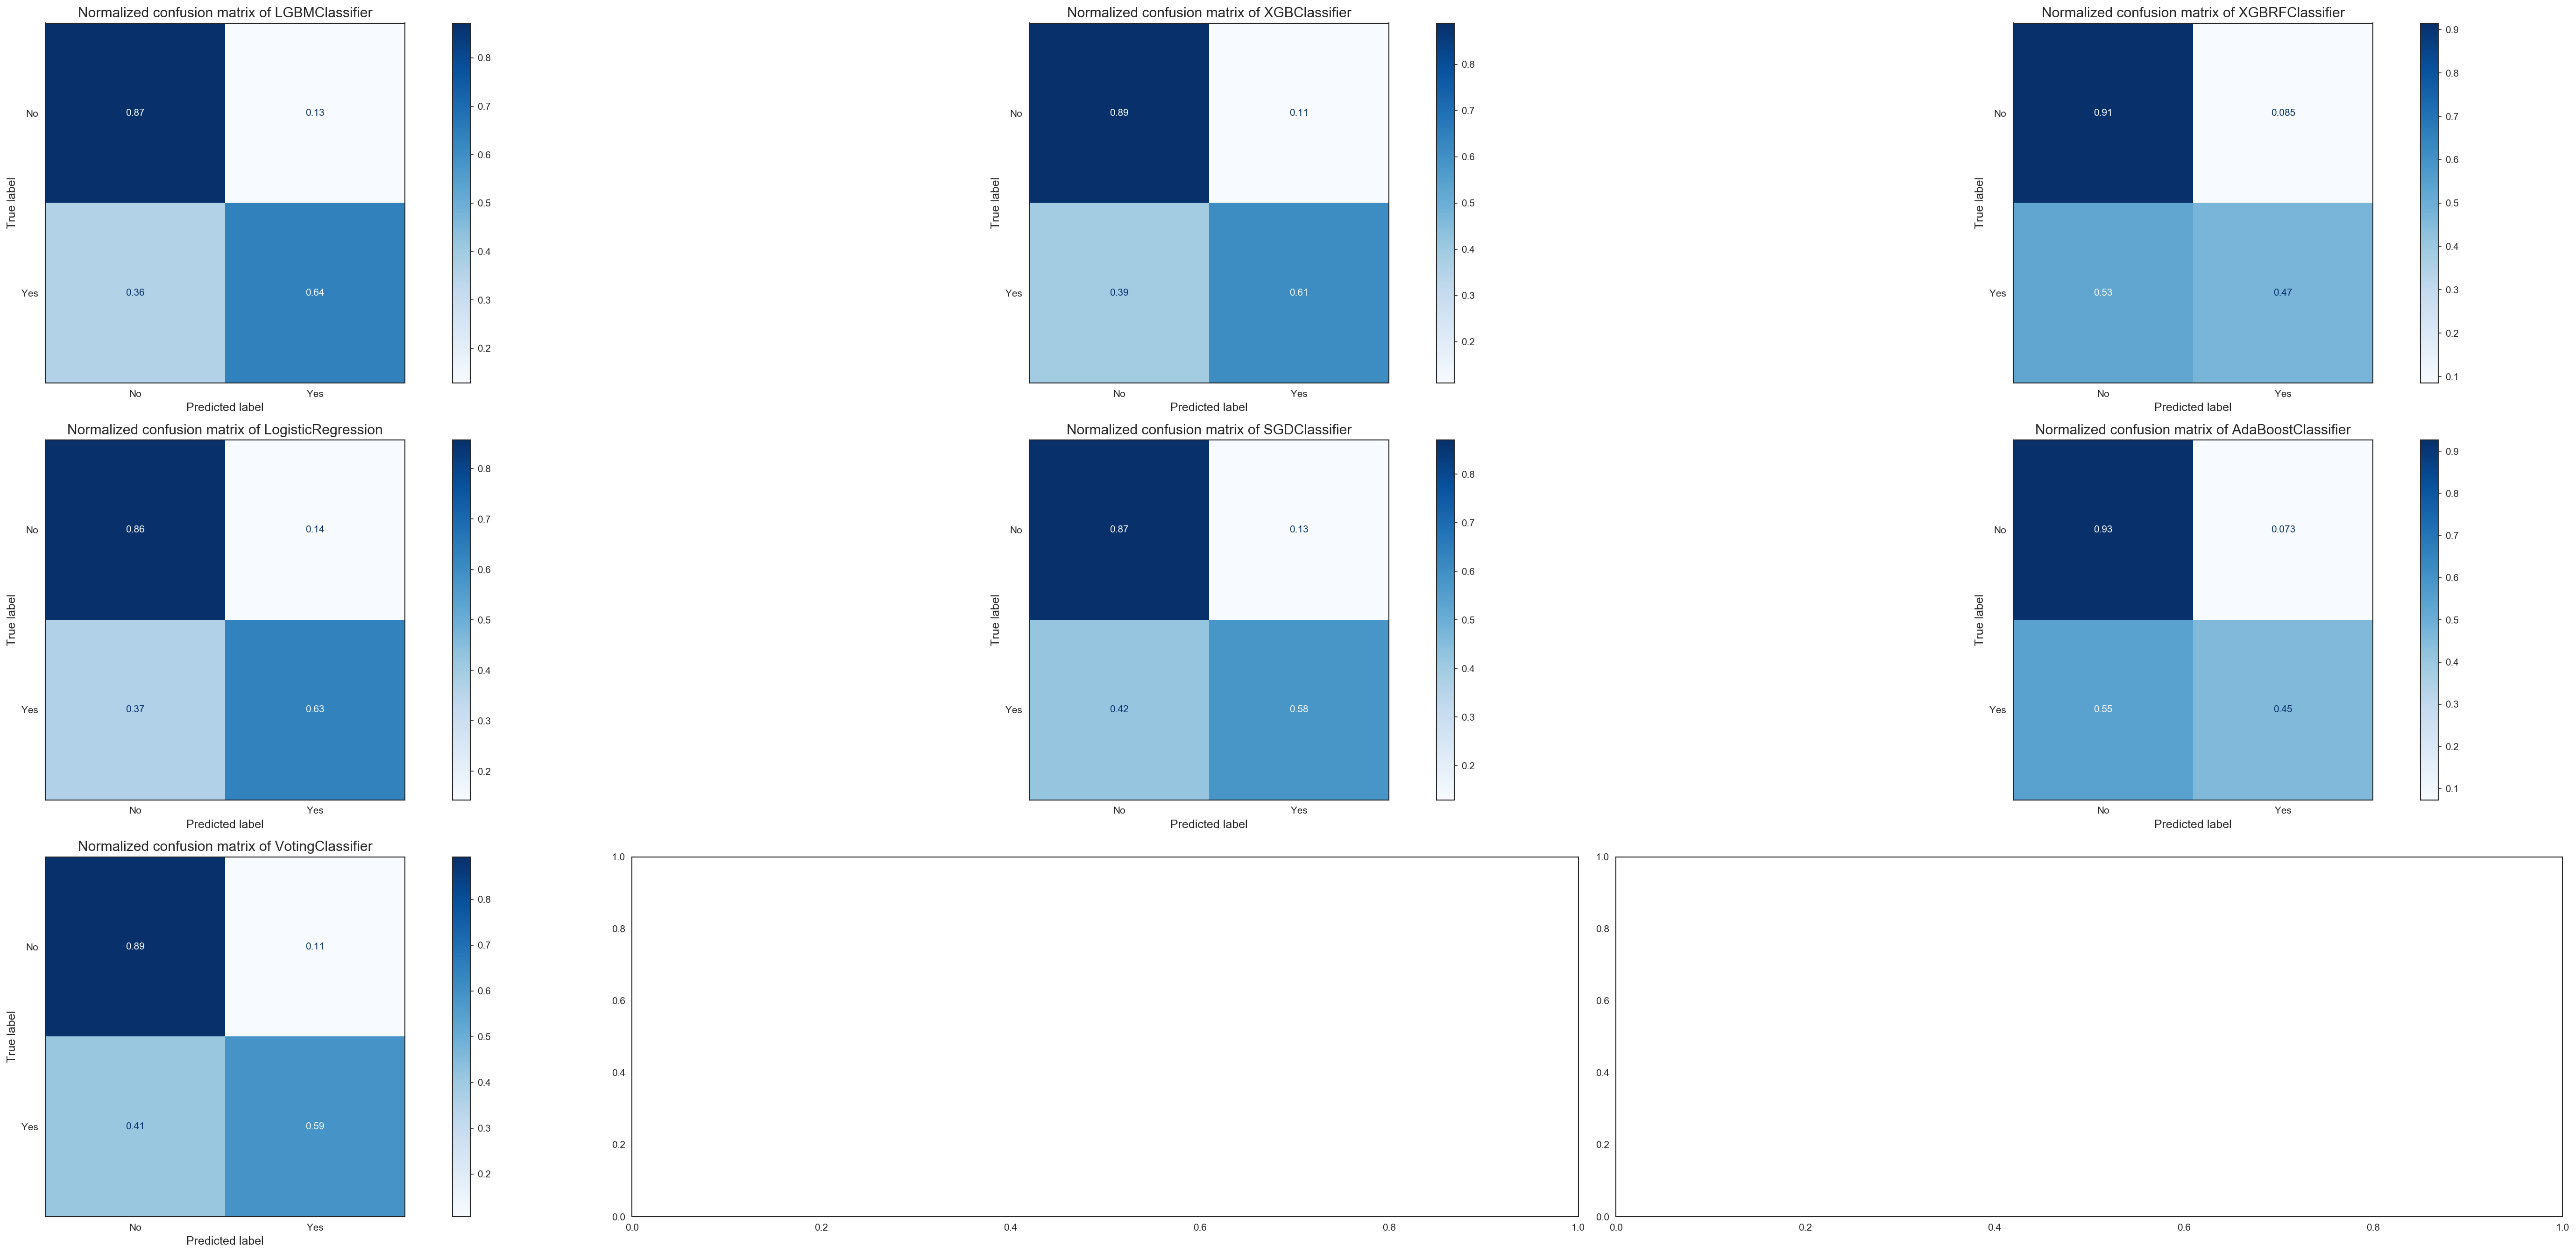

In [38]:
binary_testing([lgb_clf,xgb_clf,rf_clf,log_clf,
                sdg_clf,ada_clf,voting_clf],X_test,y_test)

# 5.7 Decision Tree

In [50]:
tree_clf = DecisionTreeClassifier(ccp_alpha = 0.5*10**-3,random_state=42)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0005, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [51]:
y_pred = tree_clf.predict(X_test)
y_score = tree_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds  = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print(roc_auc)

0.786798016494489



 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

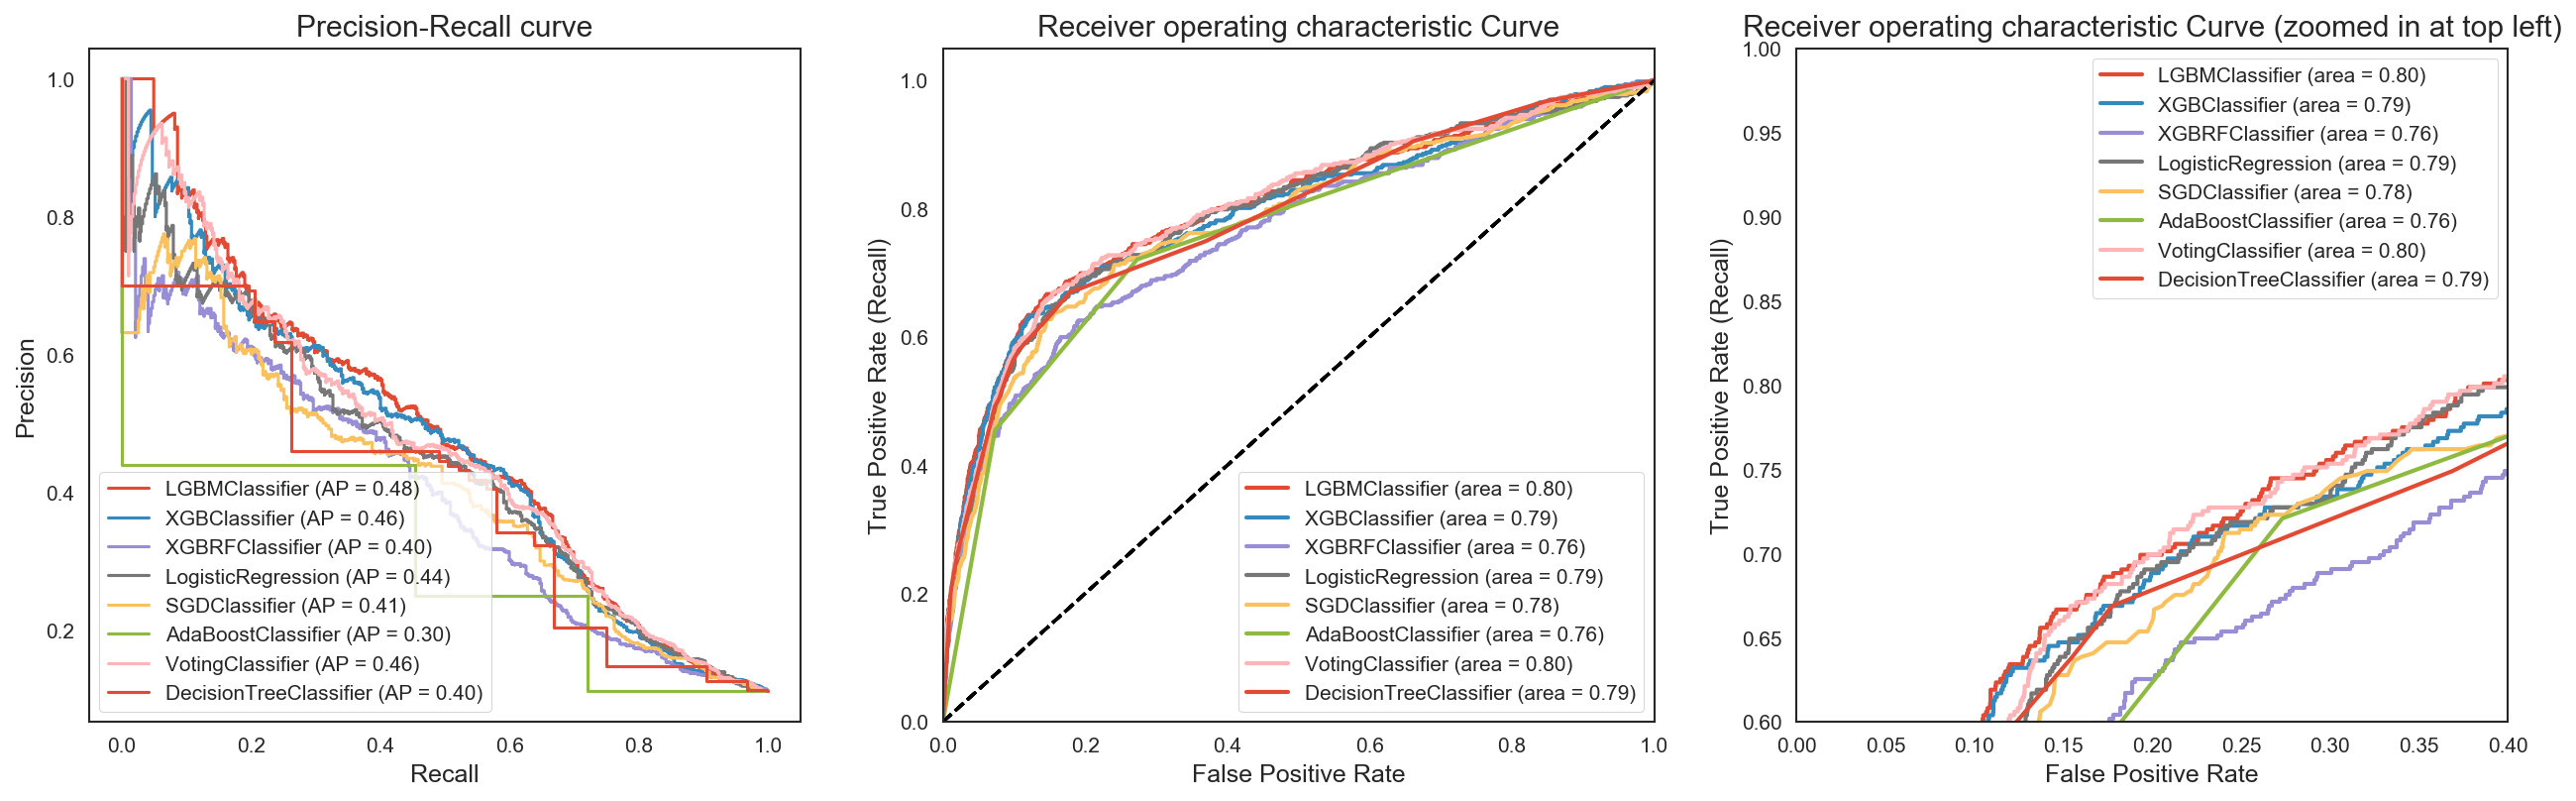

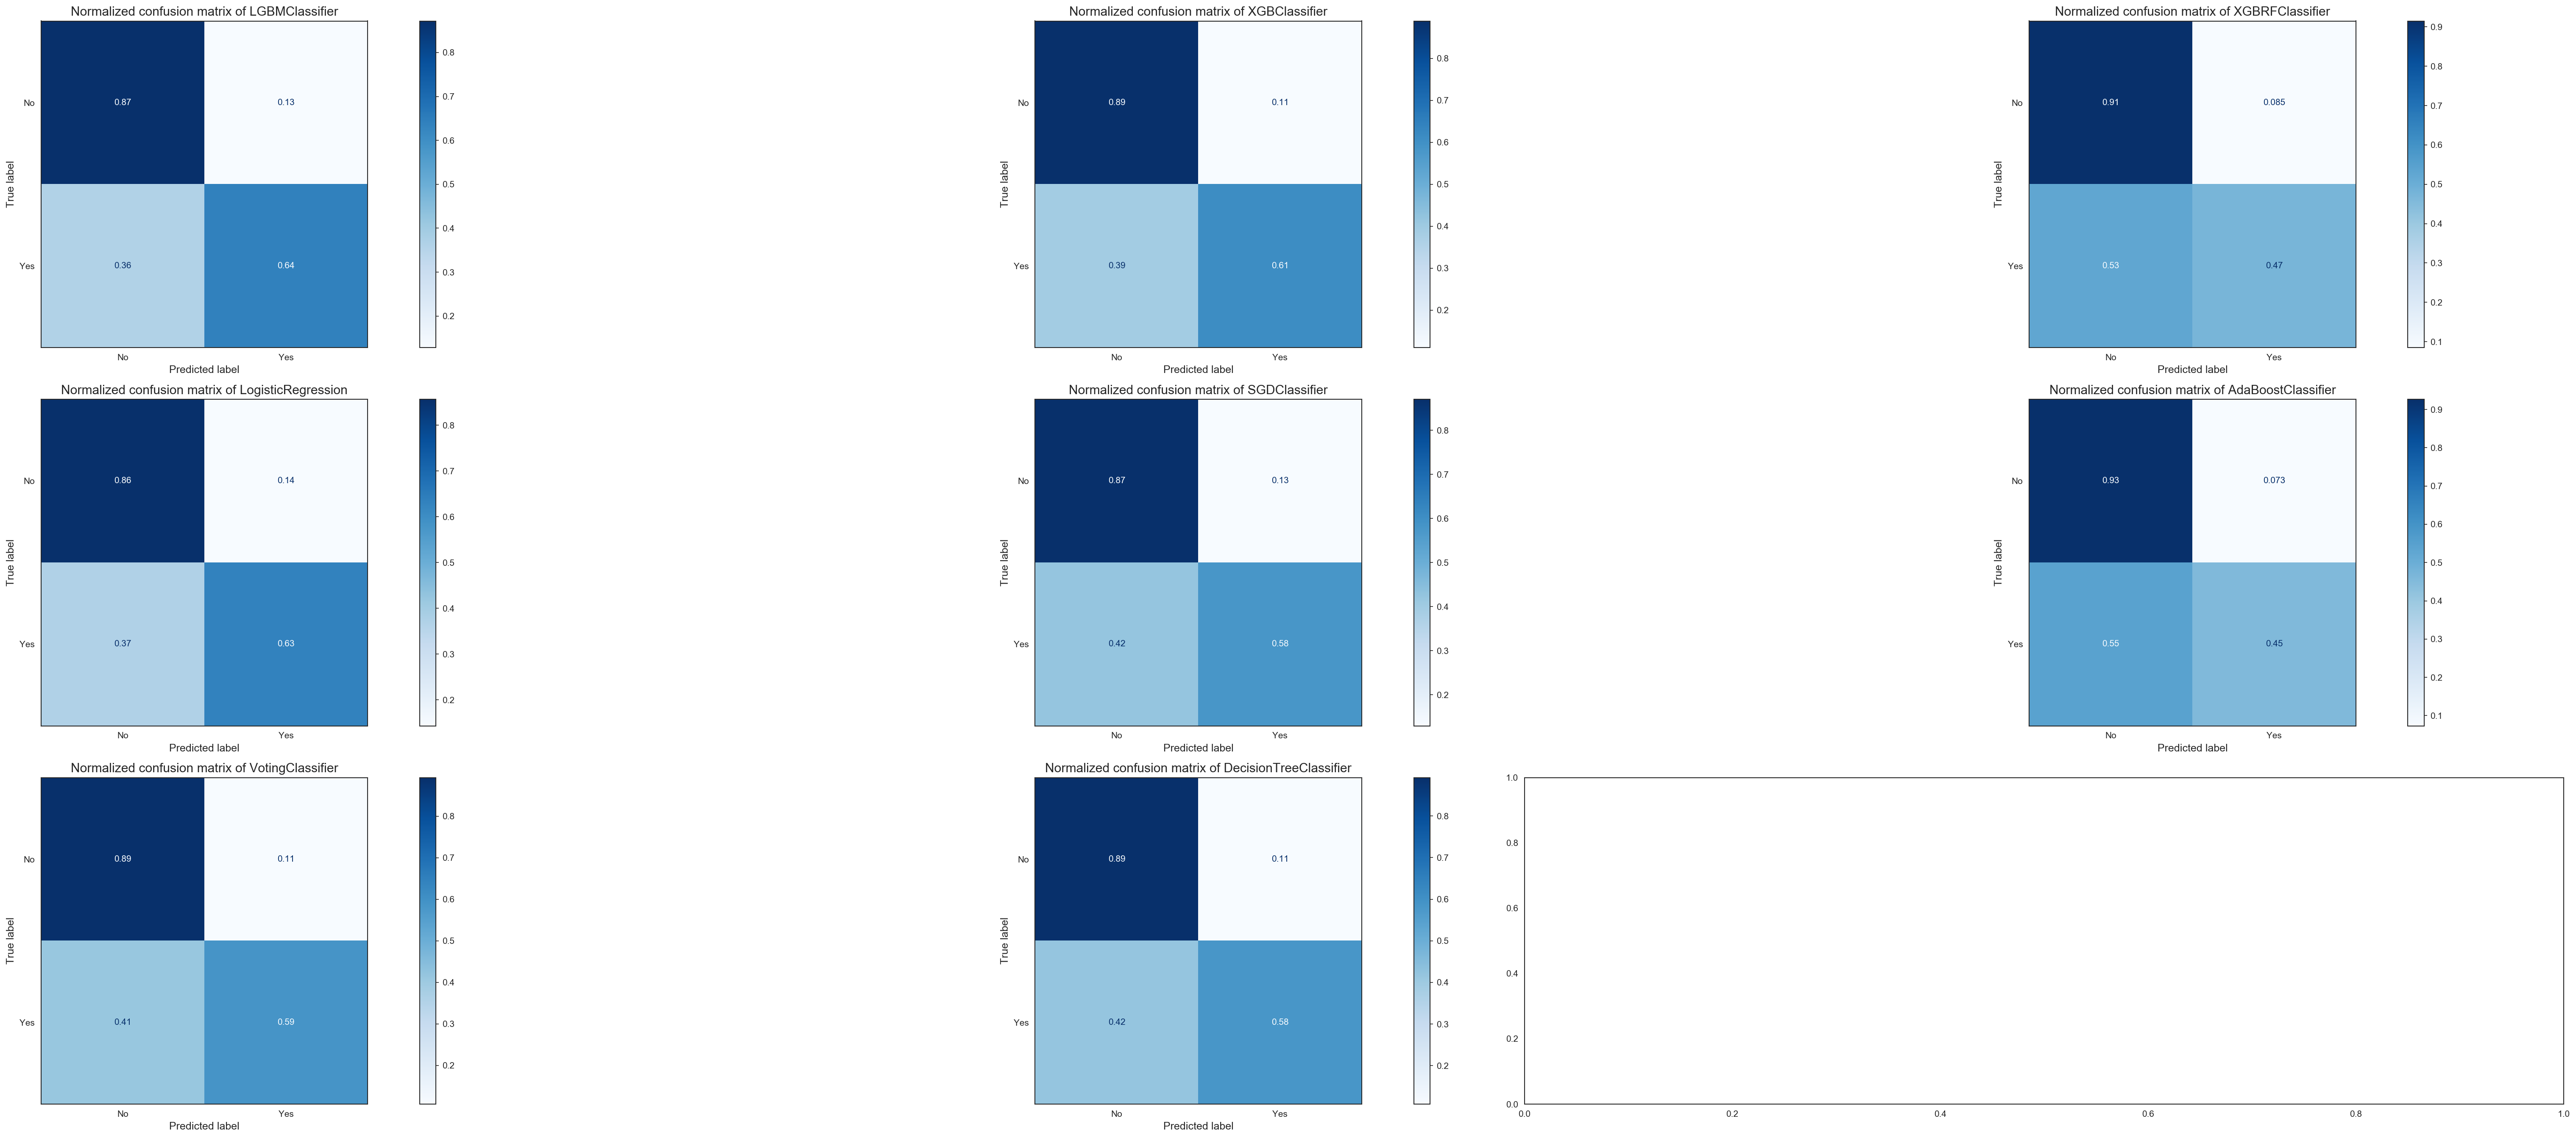

In [52]:
binary_testing([lgb_clf,xgb_clf,
                rf_clf,log_clf,
                sdg_clf,ada_clf,voting_clf,
                tree_clf],X_test,y_test)

# 5.8 Neural Network

In [40]:
def add_layer(model,units=6,l2_rate=0):
    
    if l2_rate>0:
        model.add(Dense(units = units,kernel_regularizer=l2(l2_rate),
                  activation = 'elu',kernel_initializer = 'he_normal'))
    else:
        model.add(Dense(units = units,activation = 'elu',kernel_initializer = 'he_normal'))
    
    return model

                  
def ann(hidden_layers = 1,units = 6,dropout_rate = 0,l2_rate = 0):
    model = Sequential()

    if l2_rate>0:
        model.add(Dense(units = units,input_dim = 52,kernel_regularizer=l2(l2_rate),
                  activation = 'elu',kernel_initializer = 'he_normal'))
    else:
        model.add(Dense(units = units,input_dim = 52,
                  activation = 'elu',kernel_initializer = 'he_normal'))

    for i in range(hidden_layers):
        
        model = add_layer(model,units,l2_rate)
        
        if dropout_rate >0:
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
            

In [41]:
es = EarlyStopping(patience=9,restore_best_weights=True)
ms = ModelCheckpoint('ann.h5',save_best_only = True)
lr_sch = ReduceLROnPlateau(factor = 0.2,patience=3,verbose=1)

In [42]:
fit_params = {'x':X_train_small,
              'y': y_train_small,
              'epochs':100,
#               'batch_size':16,
              'validation_data':(X_val,y_val),
              'callbacks': [es,ms,lr_sch],
                 'verbose':1}

In [57]:
space  = [Integer(1, 6, name='hidden_layers'),
          Integer(6, 100, name='units'),
          Real(10**-10, 10**0, "log-uniform", name='l2_rate'),
         Real(0, 0.9999, name='dropout_rate')]


@use_named_args(space)
def objective(**params):
    print(params)

    clf = ann(**params)
#     clf.set_params(**params)
    clf.fit(**fit_params)
    obj = np.mean(log_loss(y_val,clf.predict_proba(X_val)))

    return obj

In [58]:
%%time
clf_gp = gp_minimize(objective, space, n_calls=60, random_state=60)

{'hidden_layers': 5, 'units': 74, 'l2_rate': 0.0002071684198120053, 'dropout_rate': 0.7409990508214691}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 4s 60us/sample - loss: 3.9548 - accuracy: 0.4987 - val_loss: 0.8444 - val_accuracy: 0.5000
Epoch 2/100
61858/61858 [==============================] - 3s 49us/sample - loss: 0.8479 - accuracy: 0.5034 - val_loss: 0.8360 - val_accuracy: 0.5000
Epoch 3/100
61858/61858 [==============================] - 3s 50us/sample - loss: 0.8308 - accuracy: 0.5206 - val_loss: 0.8254 - val_accuracy: 0.5000
Epoch 4/100
61858/61858 [==============================] - 3s 48us/sample - loss: 0.7711 - accuracy: 0.6185 - val_loss: 0.8033 - val_accuracy: 0.5214
Epoch 5/100
61858/61858 [==============================] - 3s 47us/sample - loss: 0.7279 - accuracy: 0.6613 - val_loss: 0.7264 - val_accuracy: 0.6190
Epoch 6/100
61858/61858 [==============================] - 3s 48us/sample - loss: 0.6882 - accura

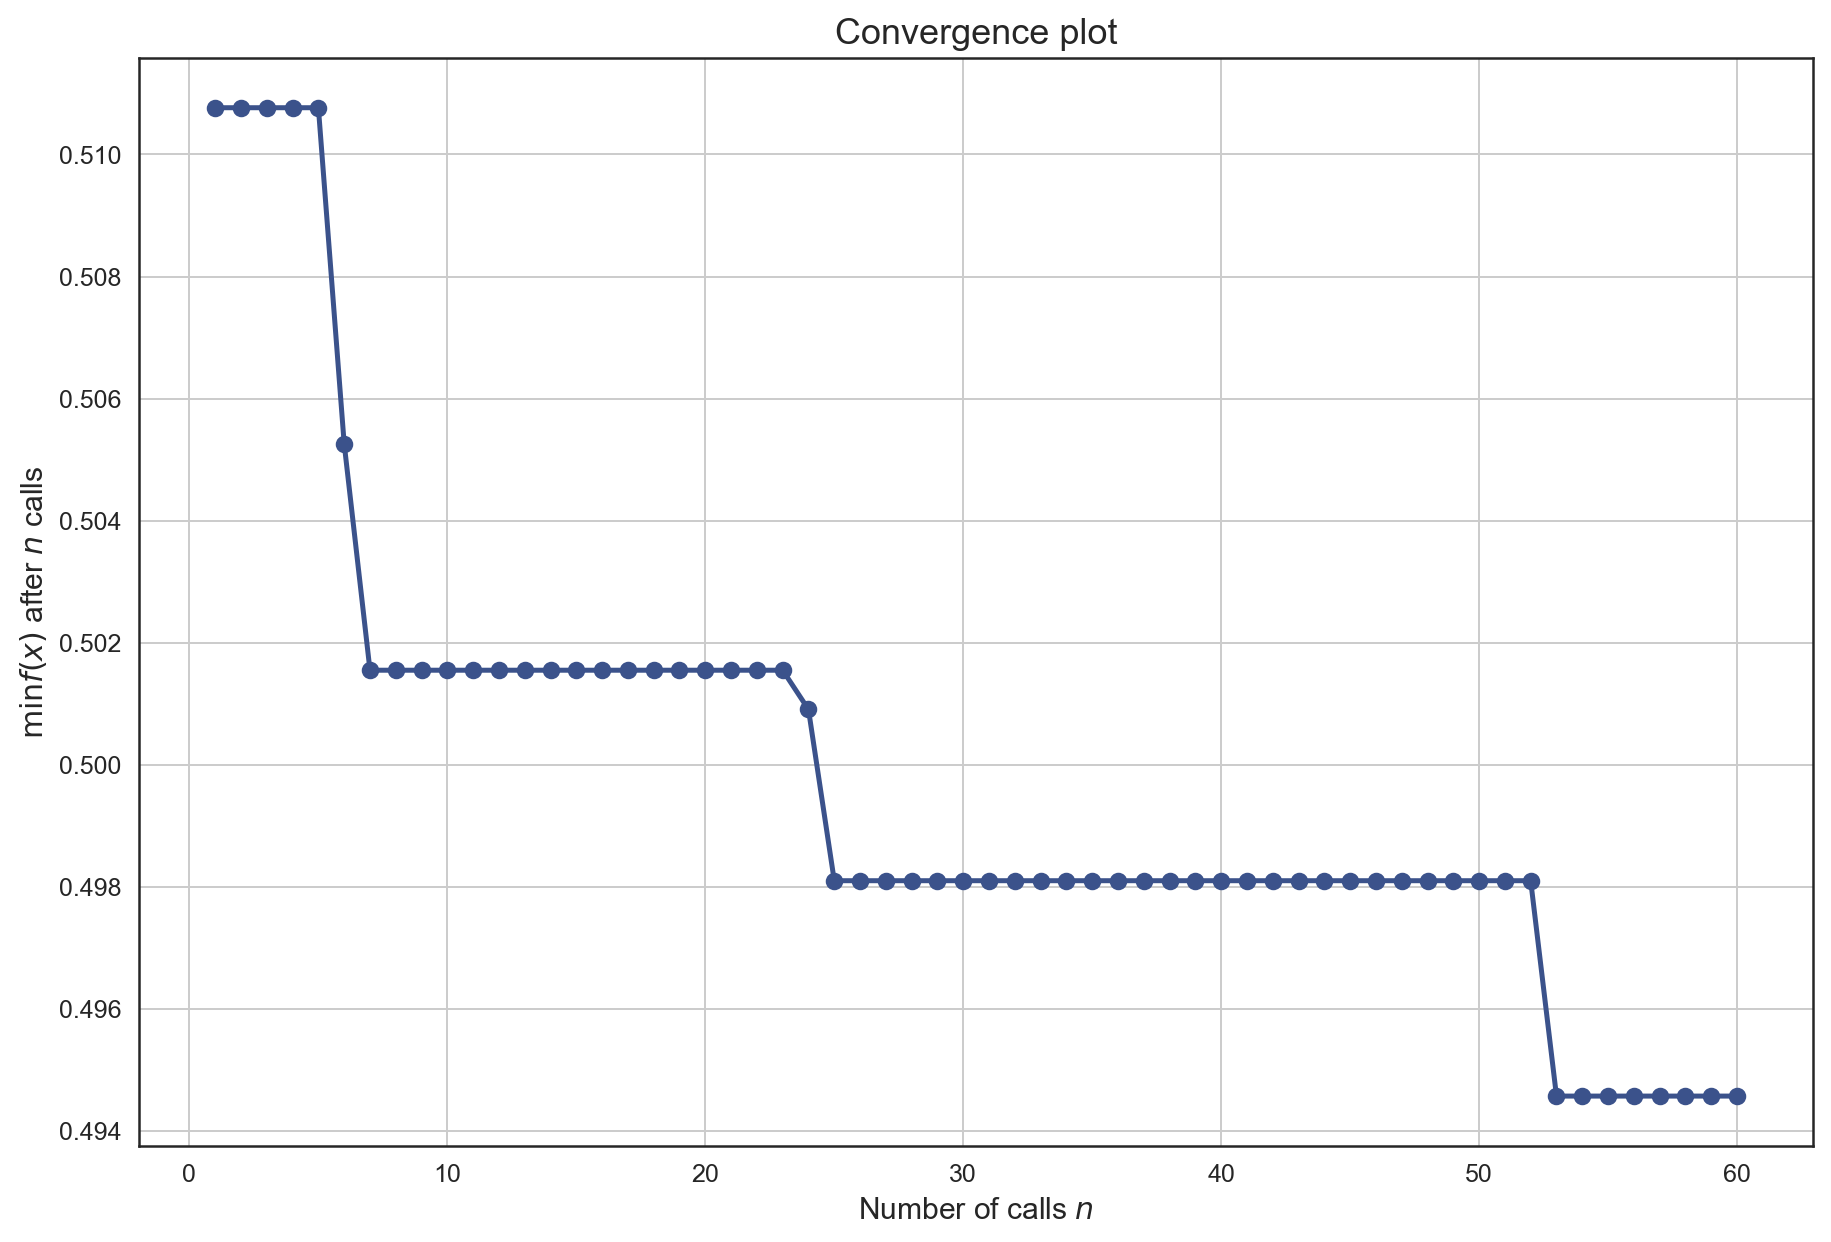

In [61]:
fig,ax = plt.subplots(figsize = (12,8),dpi=180)
plot_convergence(clf_gp,ax=ax);

In [62]:
params_names = ['hidden_layers','units','l2_rate','dropout_rate']
best_params = {name:x for name,x in zip(params_names,clf_gp.x)}
best_params


{'hidden_layers': 6,
 'units': 48,
 'l2_rate': 7.513350030416837e-05,
 'dropout_rate': 0.10457289653606582}

In [63]:
print(f"Best score={clf_gp.fun:.4f}" )

# for key,value in zip(best_params.keys(),clf_gp.x):
#     print(f"{key} is {value} \n")
#     best_params[key] = value

Best score=0.4946


In [90]:
# Now fit the best model using Keras Classifier Wrapper
paras_ann = best_params
ann_clf = KerasClassifier(build_fn=ann, **paras_ann)
ann_clf.fit(**fit_params)

Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 4s 59us/sample - loss: 0.6408 - accuracy: 0.7119 - val_loss: 0.5632 - val_accuracy: 0.7561
Epoch 2/100
61858/61858 [==============================] - 3s 47us/sample - loss: 0.5905 - accuracy: 0.7356 - val_loss: 0.5459 - val_accuracy: 0.7681
Epoch 3/100
61858/61858 [==============================] - 3s 49us/sample - loss: 0.5759 - accuracy: 0.7402 - val_loss: 0.5588 - val_accuracy: 0.7548
Epoch 4/100
61858/61858 [==============================] - 3s 52us/sample - loss: 0.5676 - accuracy: 0.7419 - val_loss: 0.5242 - val_accuracy: 0.7729
Epoch 5/100
61858/61858 [==============================] - 3s 50us/sample - loss: 0.5599 - accuracy: 0.7425 - val_loss: 0.5241 - val_accuracy: 0.7704
Epoch 6/100
61858/61858 [==============================] - 3s 49us/sample - loss: 0.5547 - accuracy: 0.7422 - val_loss: 0.5285 - val_accuracy: 0.7722
Epoch 7/100
61858/61858 [==========================


 Calssification Report of LGBMClassifier
              precision    recall  f1-score   support

          No       0.95      0.87      0.91      3657
         Yes       0.39      0.64      0.48       462

    accuracy                           0.85      4119
   macro avg       0.67      0.76      0.70      4119
weighted avg       0.89      0.85      0.86      4119

confusion_matrix of LGBMClassifier
[[0.8717528  0.1282472 ]
 [0.36147186 0.63852814]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.89      0.92      3657
         Yes       0.41      0.61      0.49       462

    accuracy                           0.86      4119
   macro avg       0.68      0.75      0.70      4119
weighted avg       0.89      0.86      0.87      4119

confusion_matrix of XGBClassifier
[[0.88925349 0.11074651]
 [0.38961039 0.61038961]]



 Calssification Report of XGBRFClassifier
              precision    recall  f1-score  

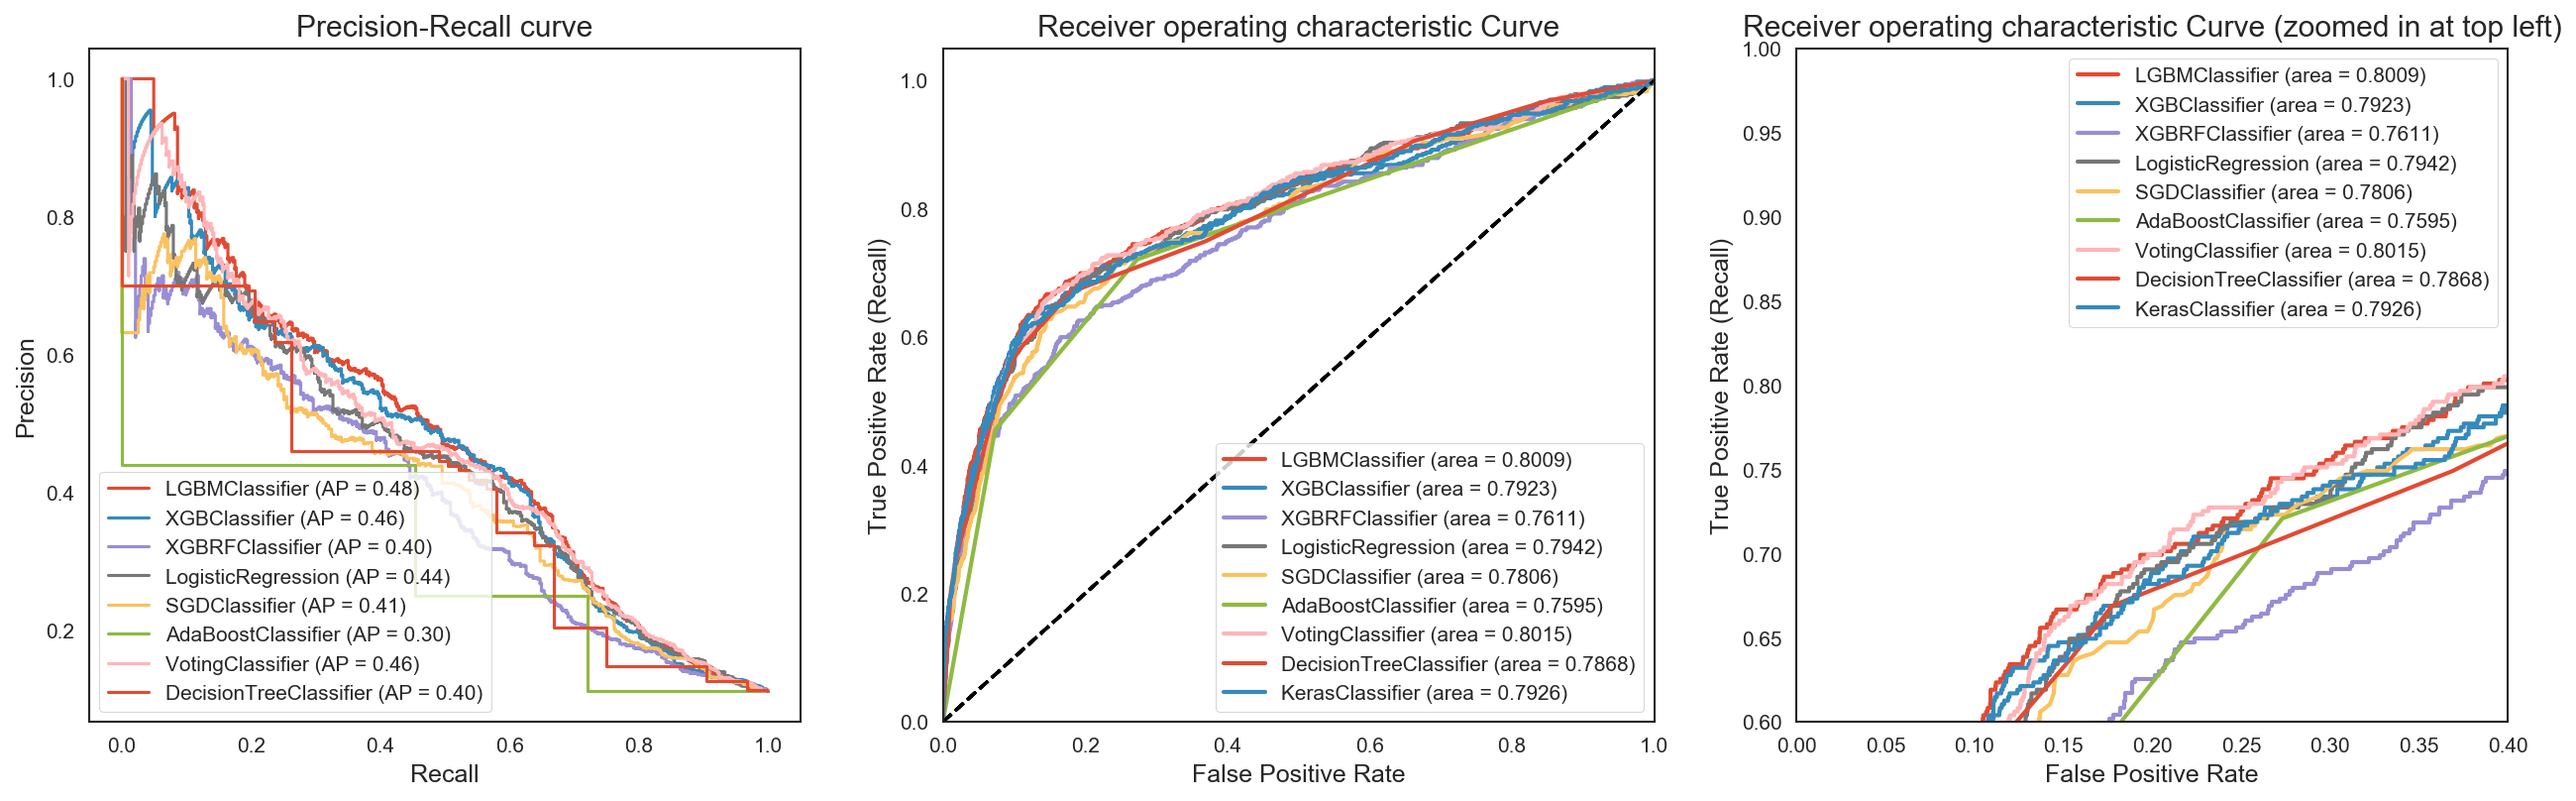

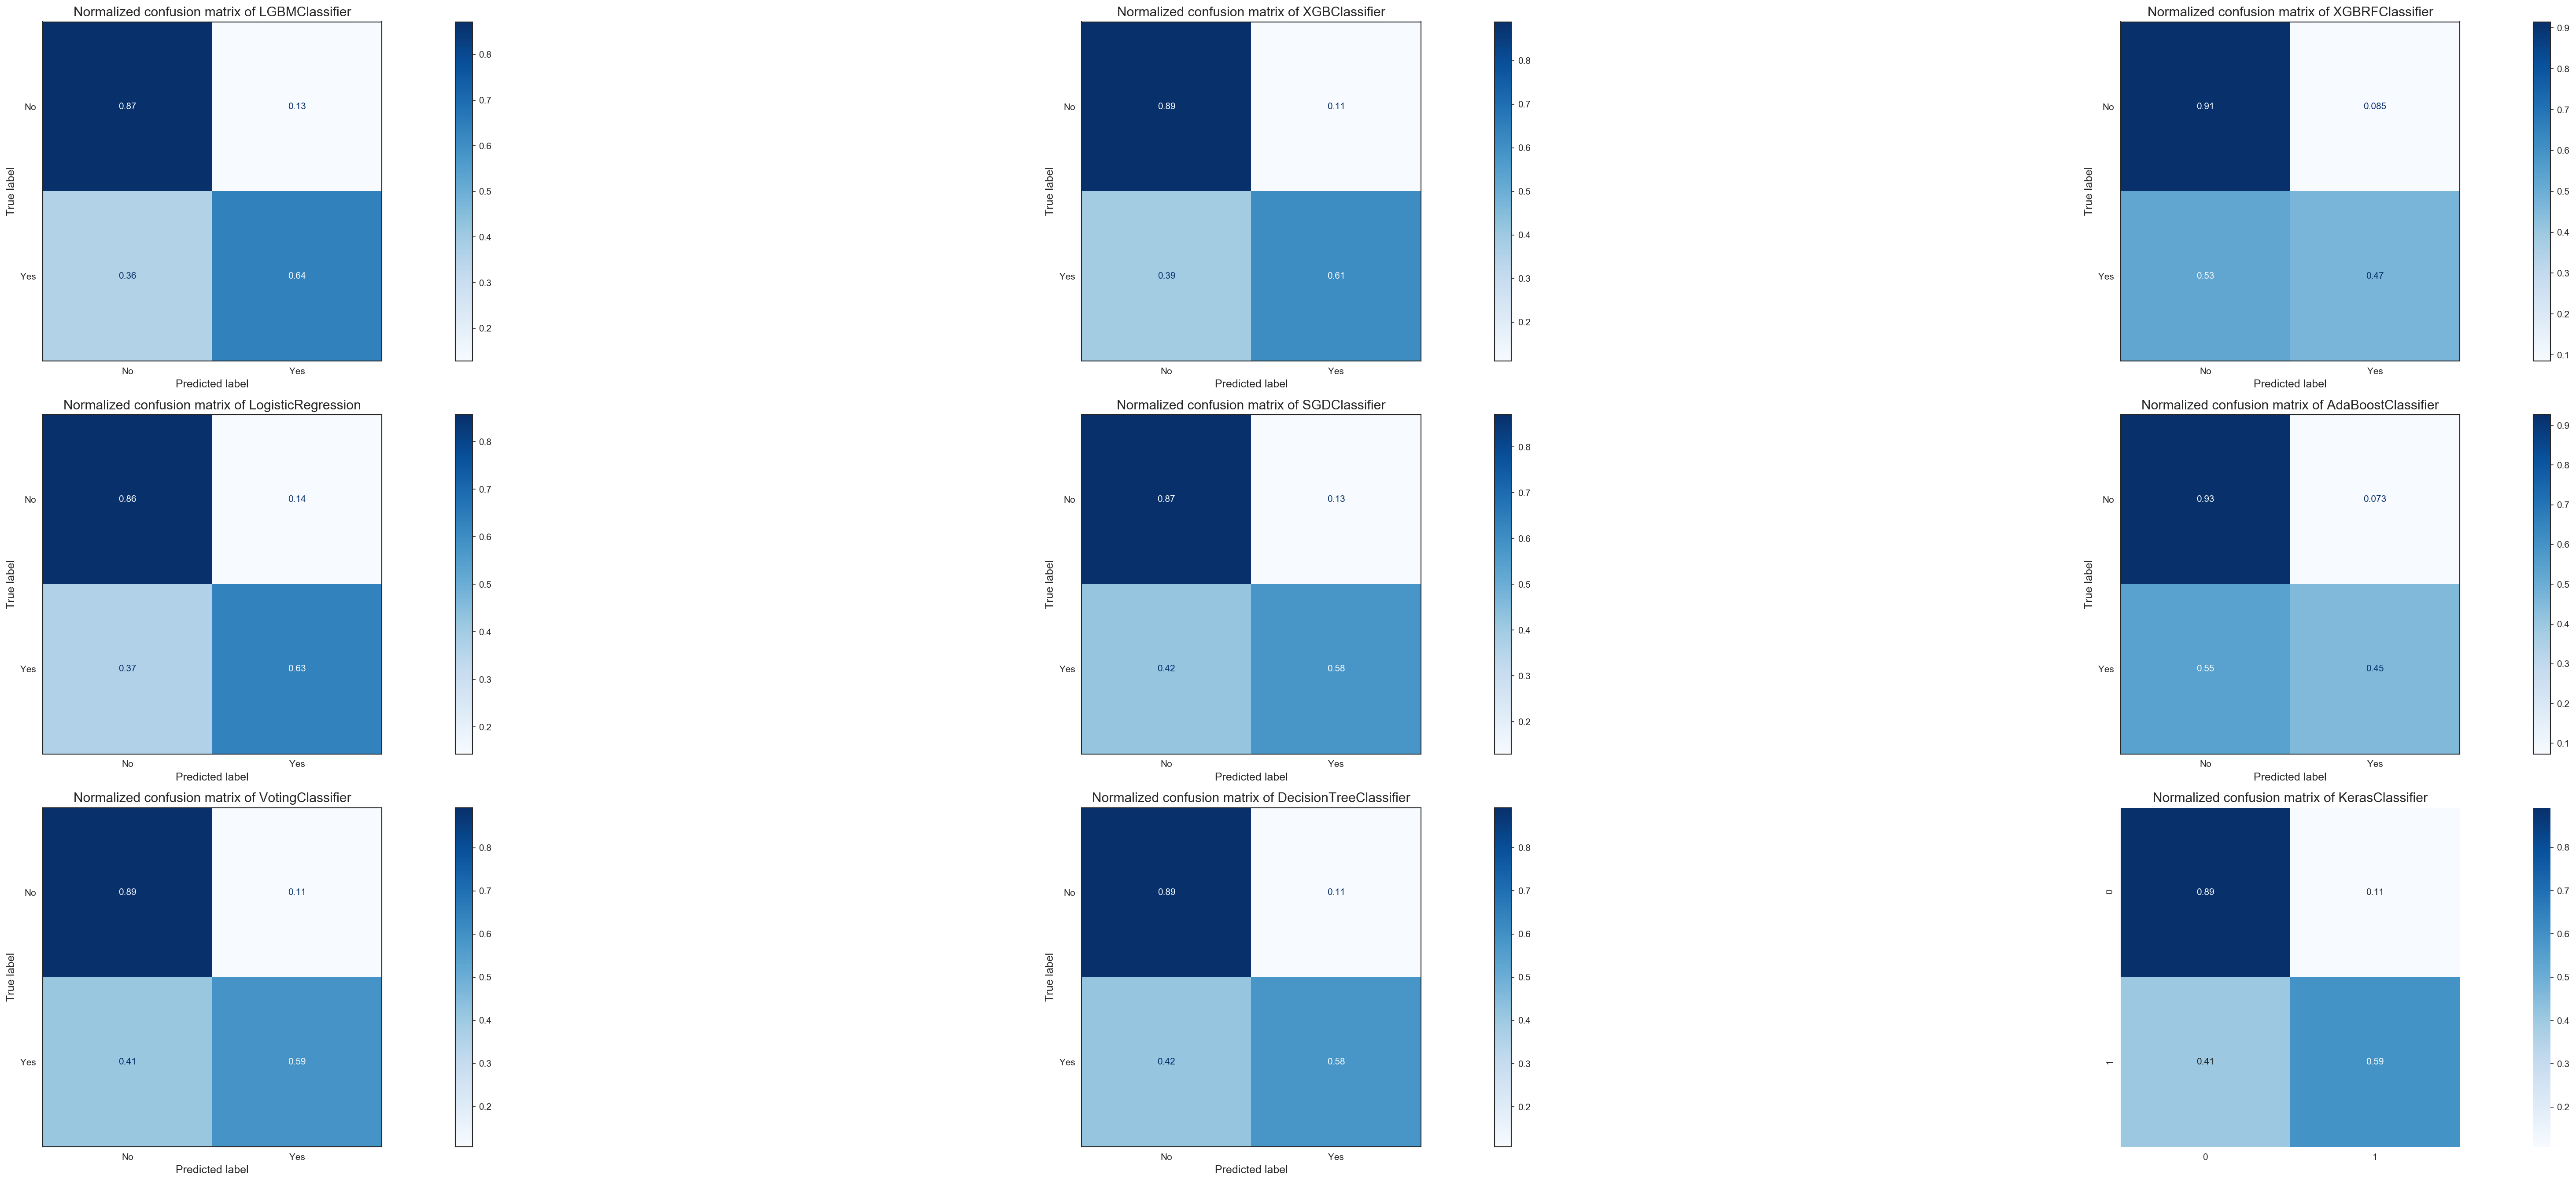

In [92]:
binary_testing([lgb_clf,xgb_clf,
                rf_clf,log_clf,
                sdg_clf,ada_clf,voting_clf,
                tree_clf,ann_clf],X_test,y_test)

In [95]:
# ann_clf.save('ann_clf.h5')

# ann_clf = load_model('ann_clf.h5')

# 5.9 Conclusion
- Voting Classifier >= LightGBM >= Logistic >= Nural Network > others

In [94]:
for model,name in zip([lgb_clf,xgb_clf,rf_clf,log_clf,
                sdg_clf,ada_clf,voting_clf,tree_clf,ann_clf],
                     ['lgb_clf','xgb_clf','rf_clf','log_clf',
                'sdg_clf','ada_clf','voting_clf','tree_clf']):
    dump(model, f'{name}.joblib') 

# xgb_clf = load('xgb_clf.joblib')

In [186]:
def compare_voting(sample,X_test,y_test,voting_clf):
    # Plot class probabilities calculated by the VotingClassifier
    # predict class probabilities for all classifiers
    probas = [c.predict_proba(X_test) for c in voting_clf.estimators_ + [voting_clf]]

    # get class probabilities for the first sample in the dataset
    class1_1 = [pr[sample, 0] for pr in probas]
    class2_1 = [pr[sample, 1] for pr in probas]


    # plotting

    N = len(voting_clf.estimators_)+1  # number of groups
    ind = np.arange(N)  # group positions
    width = 0.35  # bar width

    fig, ax = plt.subplots(figsize = (12,8))

    # bars for classifier 1-6
    p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
                color='green', edgecolor='k')
    p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
                color='lightgreen', edgecolor='k')

    # bars for VotingClassifier
    p3 = ax.bar(ind, [0]*(N-1)+[class1_1[-1]], width,
                color='blue', edgecolor='k')
    p4 = ax.bar(ind + width, [0]*(N-1)+[class2_1[-1]], width,
                color='steelblue', edgecolor='k')

    # plot annotations
    plt.axvline(5.8, color='k', linestyle='dashed')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(['LGBMClassifier\nweight 1',
                        'XGBClassifier\nweight 1',
                        'XGBRFClassifier\nweight 1',
                        'SGDClassifier\nweight 1',
                        'LogisticRegression\nweight 1',
                        'AdaBoostClassifier\nweight 1',
                        'VotingClassifier\n(average probabilities)'],
                       rotation=40,
                       ha='right')
    plt.ylim([0, 1])
    plt.title(f'Class probabilities for sample {sample} by different classifiers. Actual class is {y_test.iloc[sample]}')
    plt.legend([p1[0], p2[0]], ['0', '1'], loc='upper left')
    plt.tight_layout()
    plt.show()

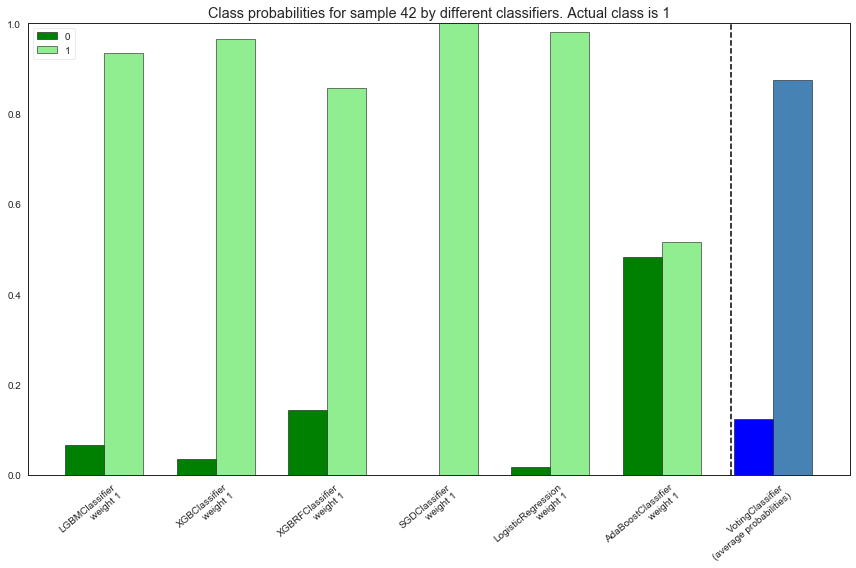

In [187]:
compare_voting(42,X_test,y_test,voting_clf)

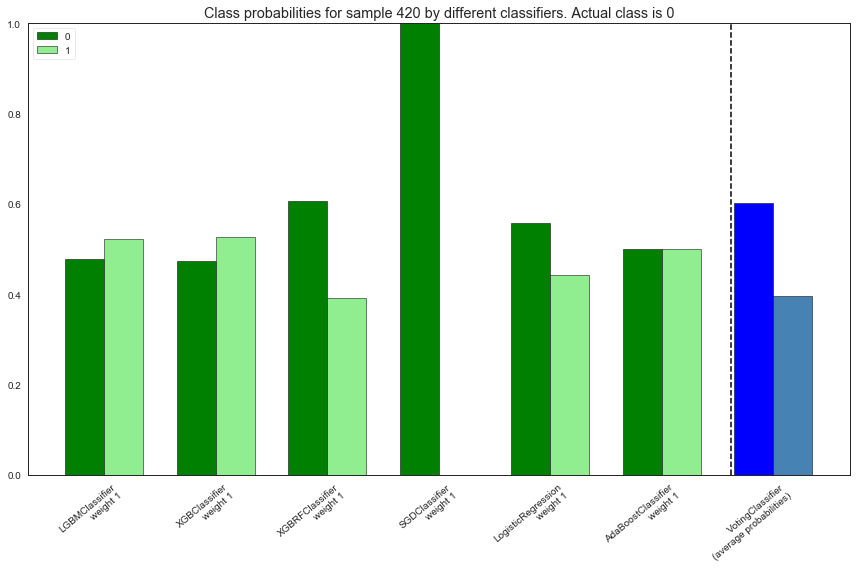

In [188]:
compare_voting(420,X_test,y_test,voting_clf)

# 6. Choose the Decision Threshold

In [29]:
# with the light GBM

def find_threshold(model,X,y,roc = True):

    # predict probabilities
    yhat = model.predict_proba(X)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]


    fig,ax = plt.subplots(figsize = (12,8),dpi = 180)
    name = model.__class__.__name__ 
    if roc:

        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(y, yhat)

        # plot the roc curve for the model
        ax.plot([0,1], [0,1], linestyle='--')
        ax.plot(fpr, tpr, marker='.', label=name+ f' AUC = ({auc(fpr,tpr):.4f})')
        # axis labels
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')


        # get the best threshold
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f, J-Stats=%.4f' % (best_thresh, J[ix]))

        ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', 
                   s = 100,label=f'Best Threshold = {best_thresh:.4f}')
        
        ax.plot([fpr[ix], fpr[ix]], [0., tpr[ix]], "y:")
        ax.plot([0, fpr[ix]], [tpr[ix], tpr[ix]], "y:")
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.legend()
    else: 
        # calculate pr-curve
        precision, recall, thresholds = precision_recall_curve(y, yhat)
        average_precision = average_precision_score(y, yhat)

        # convert to f score
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)

        best_thresh = thresholds[ix]

        print('Best Threshold=%f, F-Score=%.4f' % (best_thresh, fscore[ix]))


        # plot the pr-curve for the model
        no_skill = len(y[y==1]) / len(y)

        ax.plot([0,1], [no_skill,no_skill], linestyle='--')
        ax.plot(recall, precision, marker='.', label=f'{name} AP = ({average_precision:.4f})')
        ax.plot([recall[ix], recall[ix]], [0., precision[ix]], "y:")
        ax.plot([0, recall[ix]], [precision[ix], precision[ix]], "y:")
        ax.scatter(recall[ix], precision[ix], marker='o', 
                   s = 100, color='black', label=f'Best Threshold = {best_thresh:.4f}')
        # axis labels
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.legend()
        # show the plot
    return best_thresh

Best Threshold=0.539070, J-Stats=0.5158
Best Threshold=0.540446, F-Score=0.4983


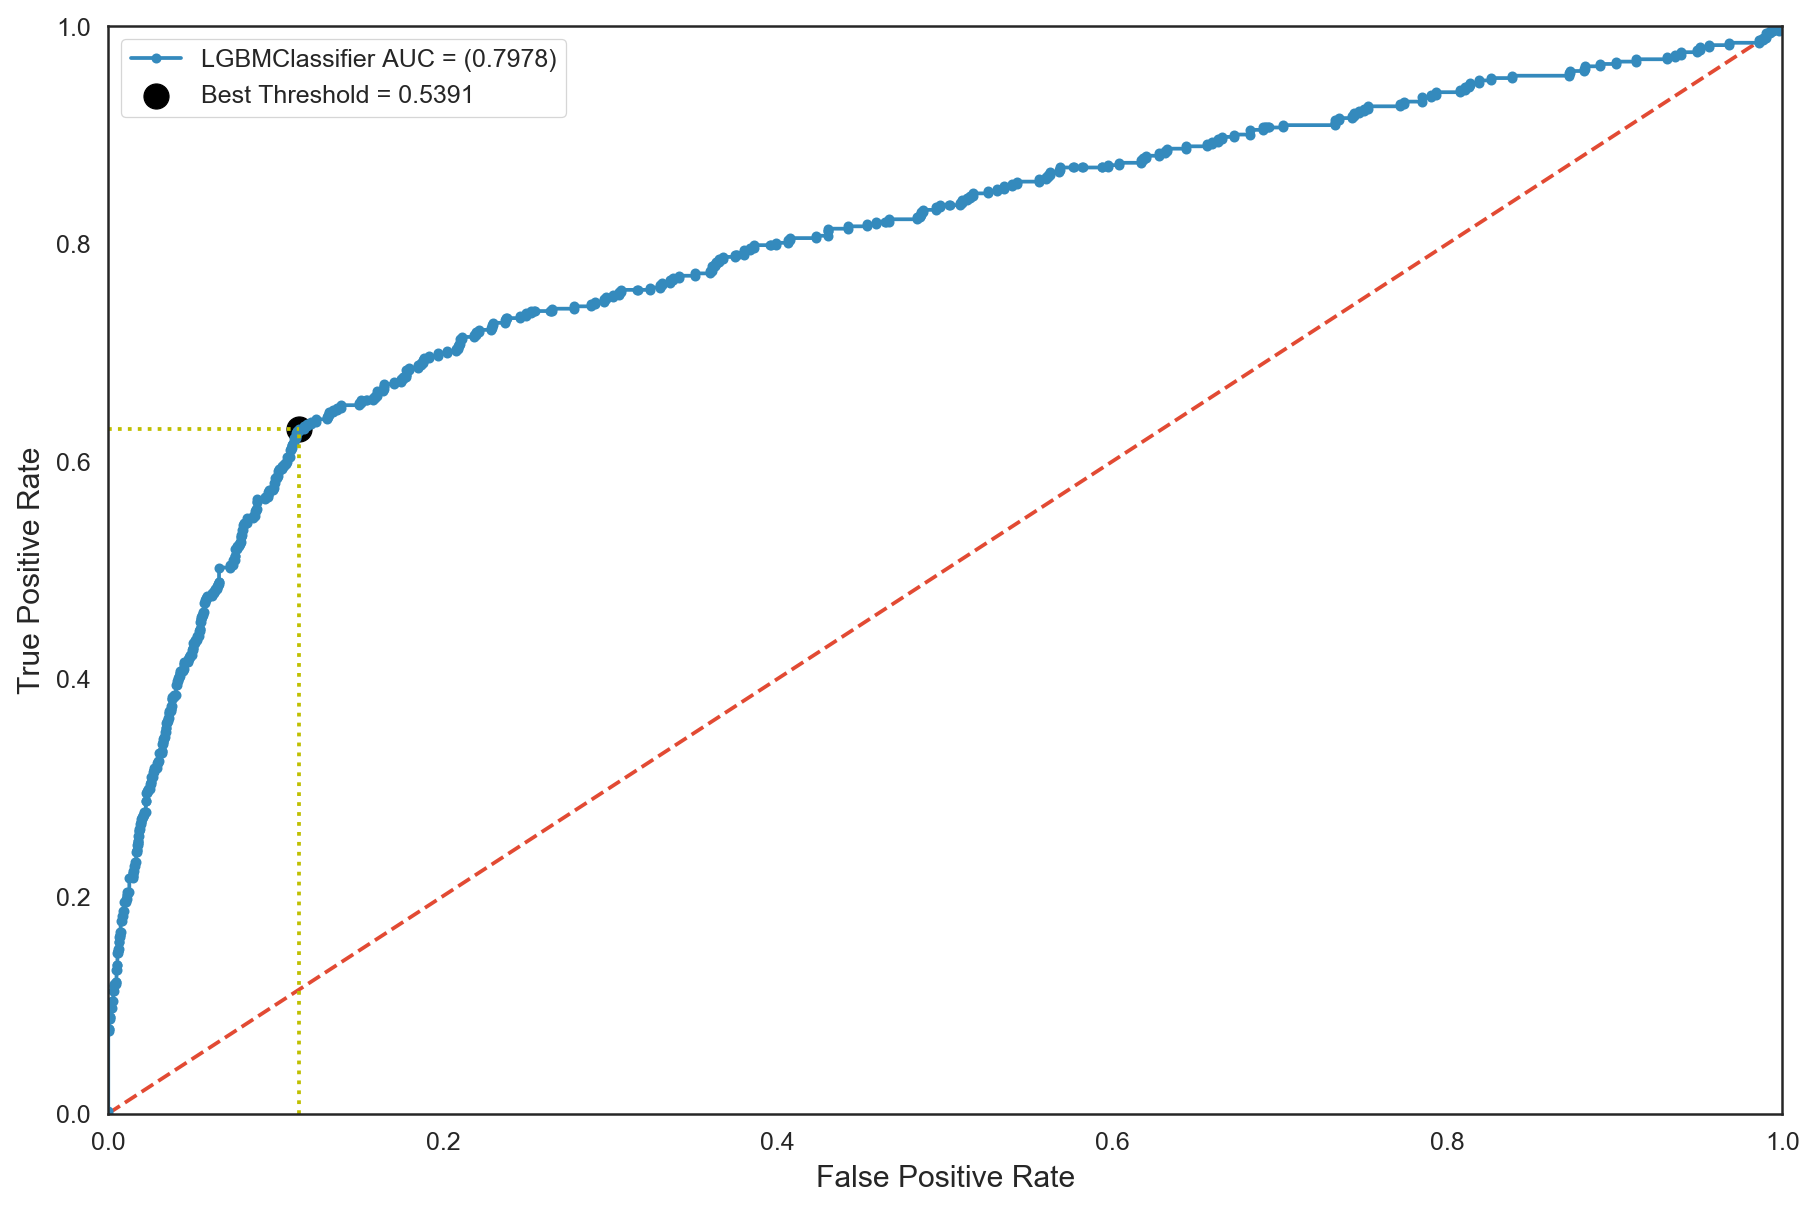

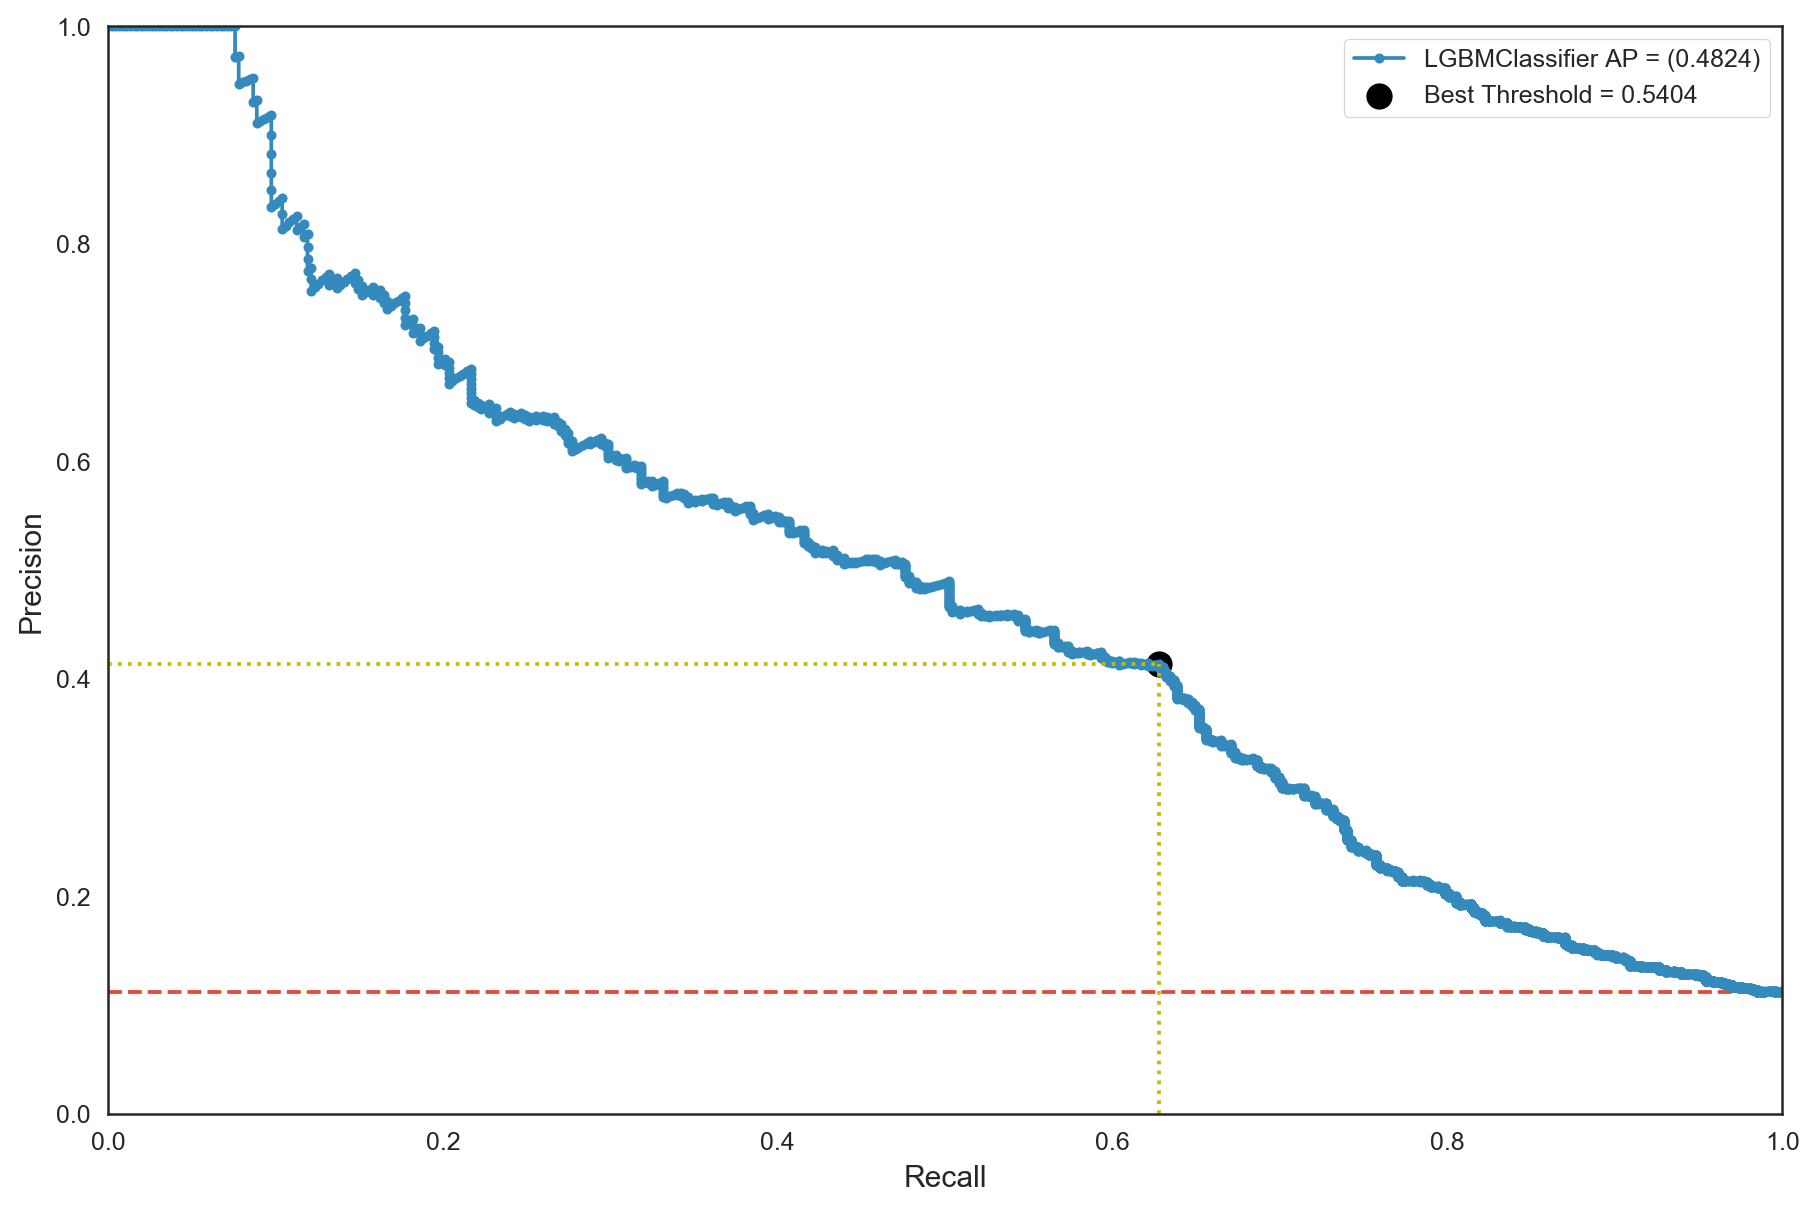

In [30]:
find_threshold(lgb_clf,X_test,y_test,roc=True);
find_threshold(lgb_clf,X_test,y_test,roc=False);

- Choose 0.539070 as the threshold

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend( fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([0, 1, 0, 1])             # Not shown

# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, lgb_clf.predict_proba(X_test)[:, 1])

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds1[ix]
  
precisions, recalls, thresholds = precision_recall_curve(y_test, lgb_clf.predict_proba(X_test)[:, 1])
ix = np.argwhere(thresholds==best_thresh)[0][0]
recall_ix = recalls[ix]
precision_ix = precisions[ix]

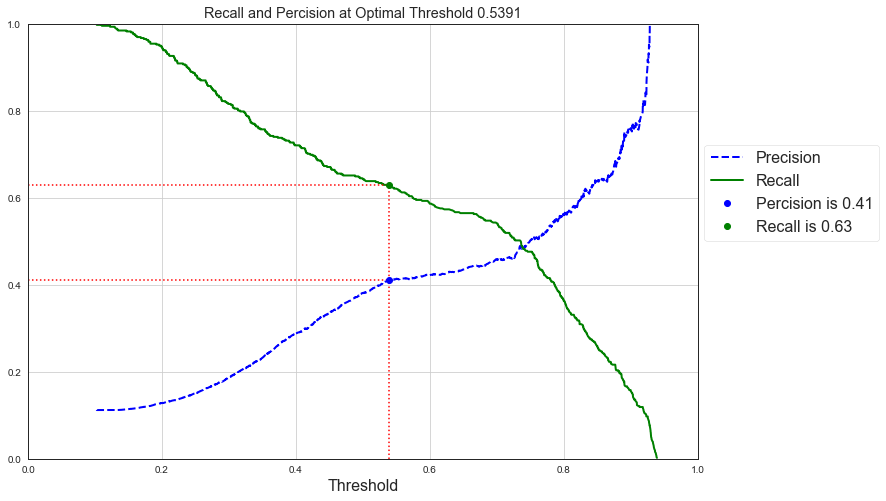

In [32]:
fig,ax = plt.subplots(figsize=(12, 8))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
ax.plot([best_thresh, best_thresh], [0., recall_ix], "r:")                 # Not shown
ax.plot([0, best_thresh], [recall_ix, recall_ix], "r:")                                # Not shown
ax.plot([0, best_thresh], [precision_ix, precision_ix], "r:")# Not shown
ax.plot([best_thresh], [precision_ix], "bo",label = f'Percision is {precision_ix:.2f}')                                             # Not shown
ax.plot([best_thresh], [recall_ix], "go",label = f'Recall is {recall_ix:.2f}') # Not shown
ax.legend(loc =(1.01,0.5) ,fontsize=16)
ax.set_title(f'Recall and Percision at Optimal Threshold {best_thresh:.4f}')
plt.show()

# 6. Feature Interpretation

In [133]:
df_train = pd.DataFrame(np.hstack((X_train,y_train.values.reshape(-1,1))),
                        columns=df.drop('y',axis = 1).columns.to_list()+['y'])

In [102]:
coefficients = pd.concat([pd.DataFrame(df.drop('y',axis = 1).columns,columns=['Variable']),
                          pd.DataFrame(np.transpose(log_clf.coef_),columns=['Coefficient'])], axis = 1)
coefficients.sort_values('Coefficient')

Variable  Coefficient
4                    emp.var.rate    -2.379173
36              contact_telephone    -0.656053
40                      month_jun    -0.493016
43                      month_nov    -0.483818
42                      month_may    -0.446014
2                           pdays    -0.357653
30                default_unknown    -0.199283
11                  job_housemaid    -0.122405
46                day_of_week_mon    -0.122393
1                        campaign    -0.108026
31                    default_yes    -0.065128
19                    job_unknown    -0.056323
3                        previous    -0.051348
32                housing_unknown    -0.048408
34                   loan_unknown    -0.048408
33                    housing_yes    -0.046238
15                   job_services    -0.043711
9                 job_blue-collar    -0.031395
0                             age    -0.025027
14              job_self-employed    -0.001709
48                day_of_week_tue     0.011247
35                       loan_yes     0.012340
8                     nr.employed     0.014733
47                day_of_week_thu     0.038964
24             education_basic.9y     0.039933
17                 job_technician     0.045078
12                 job_management     0.047682
20                marital_married     0.058657
27  education_professional.course     0.069672
10               job_entrepreneur     0.084521
25          education_high.school     0.090333
29              education_unknown     0.103475
49                day_of_week_wed     0.106451
21                 marital_single     0.109160
18                 job_unemployed     0.134256
7                       euribor3m     0.151575
39                      month_jul     0.172975
28    education_university.degree     0.181381
44                      month_oct     0.192603
23             education_basic.6y     0.211351
45                      month_sep     0.221311
22                marital_unknown     0.256880
16                    job_student     0.261934
13                    job_retired     0.334203
50           poutcome_nonexistent     0.440738
38                      month_dec     0.458540
26           education_illiterate     0.479087
37                      month_aug     0.618994
6                   cons.conf.idx     0.704475
51               poutcome_success     0.747593
5                  cons.price.idx     1.099623
41                      month_mar     1.473298

In [112]:
paras_log

{'C': 100000.0,
 'l1_ratio': 1,
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': 46,
 'solver': 'saga',
 'verbose': 1}

In [147]:
lgb.__version__

'2.3.0'

In [143]:
import statsmodels.api as sm

In [135]:
logistic = sm.GLM(df_train['y'],df_train.drop('y',axis =1), family=sm.families.Binomial())
res = logistic.fit_regularized(L1_wt = 1,alpha =1/100000 )
print(res.summary())

NotImplementedError: 

In [146]:
res.params

age                             -0.018681
campaign                        -0.115765
pdays                           -0.361012
previous                        -0.039901
emp.var.rate                    -1.136223
cons.price.idx                   0.524546
cons.conf.idx                    0.322364
euribor3m                       -0.412601
nr.employed                      0.009607
job_blue-collar                 -0.022965
job_entrepreneur                 0.090248
job_housemaid                   -0.103459
job_management                   0.046636
job_retired                      0.354760
job_self-employed                0.000000
job_services                    -0.038323
job_student                      0.293365
job_technician                   0.040411
job_unemployed                   0.136261
job_unknown                      0.000000
marital_married                  0.082261
marital_single                   0.130790
marital_unknown                  0.301430
education_basic.6y               0

In [144]:
sm.__version__

'0.11.0'

### Random Forest

In [111]:
X = X_test.copy()
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (12,8),dpi = 120)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


AttributeError: 'XGBRFClassifier' object has no attribute 'estimators_'

# 8. Time Series Prediction Testing

In [ ]:
# TODO